In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
# PROJECT_ROOT_DIR = "."
# CHAPTER_ID = "deep"

# def save_fig(fig_id, tight_layout=True):
#     path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
#     print("Saving figure", fig_id)
#     if tight_layout:
#         plt.tight_layout()
#     plt.savefig(path, format='png', dpi=300)

深层神经网络的问题：
* 首先，梯度消失/爆炸问题
* 庞大网络，训练慢
* 参数越多，越容易过拟合

在本章，我们会回顾每一个问题，并且介绍科学解决方案。我们会从梯度消失问题开始，探索这类问题目前最流行的解决方案。接着会研究一下相较平坦梯度下降能够在训练大模型时做到明显提速的各种优化器。最后，我们会浏览一下几个流行的针对大型神经网络的正则化技术。

有了这些工具，我们就能训练比较深的网络：欢迎来到深度学习！

# 梯度消失/爆炸问题

我们可以通过反向传播算法来从输出层反向作用到输入层，传播梯度误差。

不幸的是，梯度经常会随着算法进展到更低层次时变得越来越小。导致的结果是，梯度下降在更低层网络连接权值更新方面基本没有改变，而且训练不会收敛到好的结果，这就是梯度消失问题。

在一些例子中会发生相反的现象，梯度会越来越大，导致很多层的权值疯狂增大，使得算法发散，这就是梯度爆炸，经常出现在循环神经网络中。

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

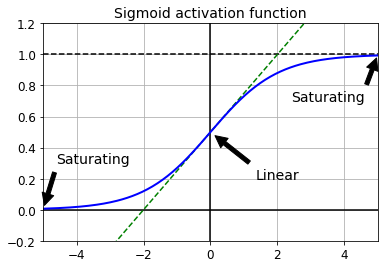

In [13]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-') # 从 (-5,0) -> (5,0)
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

## Xavier初始化和He初始化

* Logistic uniform: $ r = \sqrt{\dfrac{6}{n_\text{inputs} + n_\text{outputs}}} $
* Logistic normal: $ \sigma = \sqrt{\dfrac{2}{n_\text{inputs} + n_\text{outputs}}} $
* Hyperbolic tangent uniform: $ r = 4 \sqrt{\dfrac{6}{n_\text{inputs} + n_\text{outputs}}} $
* Hyperbolic tangent normal: $ \sigma = 4 \sqrt{\dfrac{2}{n_\text{inputs} + n_\text{outputs}}} $
* ReLU (and its variants) uniform: $ r = \sqrt{2} \sqrt{\dfrac{6}{n_\text{inputs} + n_\text{outputs}}} $
* ReLU (and its variants) normal: $ \sigma = \sqrt{2} \sqrt{\dfrac{2}{n_\text{inputs} + n_\text{outputs}}} $

In [2]:
import tensorflow as tf

In [15]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [16]:
he_init = tf.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                          kernel_initializer=he_init, name="hidden1")

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


## 非饱和激活函数

Clorot和Bengio在2010年的论文中提出一个观点，梯度消失/爆炸问题一部分的原因是选错了激活函数。人类根据仿生，假定Sigmoid函数是一个绝佳的选择，然后现在看来，其他很多激活函数表现更好，尤其是relu函数，出现这种结果的原因最主要是因为它并不稀释正值(同时运算速度很快)

然而，Relu会出现dying Relu问题：在训练过程中，一些神经元实际上已经死了，即它们只会输出0.

其改进为leaky Relu，给负值添加一个很小的坡度，这会使该节点进入昏迷期，但最后还是有机会醒过来，有论文表明，leaky Relu总是优于Relu。

然后是PRelu，将负值坡度作为训练参数。

最后2015年有人提出新的激活函数ELU，在测试中，这总是优于前面所有的Relu的变种：训练时间减小，测试集表现更好。ELU和其他变种很像，只是有几个明显的不同。
* 第一，负值输出接近0，缓和梯度消失，超参数为当z很大时，ELU函数接近的值，一般为1.
* 第二，对于z<0有非0的梯度，避免节点死亡
* 整体平滑，提高梯度下降

ELU激活函数的缺陷是计算速度慢，但是在训练过程中收敛速度快。

2017年，又有人提出了SELU函数，在训练过程中，利用selu激活函数和lecun初始化，由一堆密集层组成的神经网络会自我规范化：在训练过程中，每一层的输出往往保持相同的均值和方差，从而解决了梯度消失/爆炸问题。因此，对于这样的神经网络，这个激活函数比其他的激活函数表现得非常好，所以你应该尝试一下。不幸的是，selu激活函数的自规范化特性很容易被破坏：不能使用1或2正则化、正则辍学、最大范数、跳跃连接或其他非顺序拓扑（因此递归神经网络不会自规范化）。然而，在实践中，它与连续cnn非常好地配合使用。如果你打破了自我规范化，selu不一定会优于其他激活函数。

默认的SELU有`scale`和`alpha`两个超参数,elu超参数（scale和alpha）的调整方式是，每个神经元的平均输出保持接近0，标准偏差保持接近1（假设输入也用平均值0和标准偏差1标准化）。使用此激活函数，即使是1000层深的神经网络，也会在所有层上保留大致的平均值0和标准差1，从而避免爆炸/消失梯度问题：

In [17]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

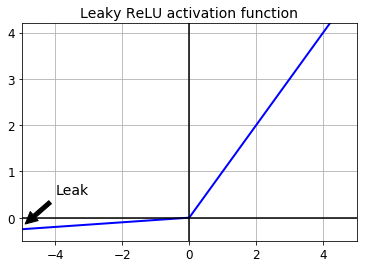

In [20]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

plt.show()

In [21]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [22]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")

使用Leaky relu来训练

In [23]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [24]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [25]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [26]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [27]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [28]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [29]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [31]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [32]:
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
            print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Batch accuracy: 0.86 Validation accuracy: 0.9048
5 Batch accuracy: 0.94 Validation accuracy: 0.9496
10 Batch accuracy: 0.92 Validation accuracy: 0.9654
15 Batch accuracy: 0.94 Validation accuracy: 0.9714
20 Batch accuracy: 1.0 Validation accuracy: 0.9762
25 Batch accuracy: 1.0 Validation accuracy: 0.9776
30 Batch accuracy: 0.98 Validation accuracy: 0.978
35 Batch accuracy: 1.0 Validation accuracy: 0.9786


ELU训练

In [73]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

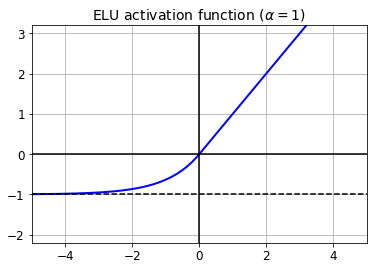

In [74]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

In [58]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [59]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [61]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.elu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [62]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [63]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [64]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [65]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [67]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [68]:
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
            print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Batch accuracy: 0.88 Validation accuracy: 0.9036
5 Batch accuracy: 0.94 Validation accuracy: 0.9338
10 Batch accuracy: 0.9 Validation accuracy: 0.9532
15 Batch accuracy: 0.9 Validation accuracy: 0.9622
20 Batch accuracy: 1.0 Validation accuracy: 0.9656
25 Batch accuracy: 1.0 Validation accuracy: 0.9698
30 Batch accuracy: 0.98 Validation accuracy: 0.9698
35 Batch accuracy: 0.98 Validation accuracy: 0.9726


SELU

In [78]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [79]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

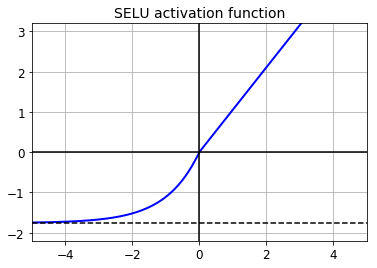

In [80]:
z = np.linspace(-5, 5, 200)
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

In [81]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


In [82]:
def selu(z, scale=alpha_0_1, alpha=scale_0_1):
    return scale * tf.where(z >= 0.0, z, alpha * tf.nn.elu(z))

In [85]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=selu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=selu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden2, activation=selu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden2, activation=selu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden2, activation=selu, name="hidden5")
    hidden6 = tf.layers.dense(hidden5, n_hidden2, activation=selu, name="hidden6")
    hidden7 = tf.layers.dense(hidden6, n_hidden2, activation=selu, name="hidden7")
    hidden8 = tf.layers.dense(hidden7, n_hidden2, activation=selu, name="hidden8")
    hidden9 = tf.layers.dense(hidden8, n_hidden2, activation=selu, name="hidden9")
    hidden10 = tf.layers.dense(hidden9, n_hidden2, activation=selu, name="hidden10")
    hidden11 = tf.layers.dense(hidden10, n_hidden2, activation=selu, name="hidden11")
    logits = tf.layers.dense(hidden11, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 40
batch_size = 50

将数据缩放到以0为均值，1为方差

In [86]:
means = X_train.mean(axis=0, keepdims=True)
stds = X_train.std(axis=0, keepdims=True) + 1e-10
X_val_scaled = (X_valid - means) / stds

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch_scaled = (X_batch - means) / stds
            sess.run(training_op, feed_dict={X: X_batch_scaled, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch_scaled, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_val_scaled, y: y_valid})
            print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./my_model_final_selu.ckpt")

0 Batch accuracy: 0.96 Validation accuracy: 0.9332
5 Batch accuracy: 0.98 Validation accuracy: 0.9588
10 Batch accuracy: 1.0 Validation accuracy: 0.9626
15 Batch accuracy: 1.0 Validation accuracy: 0.962
20 Batch accuracy: 1.0 Validation accuracy: 0.9672
25 Batch accuracy: 1.0 Validation accuracy: 0.967
30 Batch accuracy: 1.0 Validation accuracy: 0.9674
35 Batch accuracy: 1.0 Validation accuracy: 0.9674


## 批量归一化

在激活函数之前，添加一个操作，简单零中心化和归一化输入，之后再通过每层的两个新参数(一个为了缩放，另一个为了移动)缩放和移动结果。

作者提出这个技术，考虑了饱和计划函数(比如tanh)和逻辑函数，网络对于权重参数不那么敏感,而且可以使用更高的学习率学习，但是批标准化也给模型增加了复杂度，此外模型网络的预测速度降低了。

一般而言，当梯度下降在每一层搜索最佳缩放和偏移量时，训练速度会非常慢，一旦找到，训练速度会迅速提升。

In [87]:
reset_graph()

import tensorflow as tf

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

training = tf.placeholder_with_default(False, shape=(), name='training')

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = tf.layers.batch_normalization(logits_before_bn, training=training,
                                       momentum=0.9)

Instructions for updating:
Use keras.layers.batch_normalization instead.


In [88]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
training = tf.placeholder_with_default(False, shape=(), name='training')

In [89]:
from functools import partial
# 避免重复使用相同的超参数
my_batch_norm_layer = partial(tf.layers.batch_normalization,
                              training=training, momentum=0.9)

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)
hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)
logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = my_batch_norm_layer(logits_before_bn)

In [90]:
reset_graph()

batch_norm_momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn"):
    he_init = tf.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn = my_dense_layer(bn2, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Instructions for updating:
Use tf.cast instead.


In [91]:
n_epochs = 20
batch_size = 200

In [92]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.8952
1 Validation accuracy: 0.9202
2 Validation accuracy: 0.9318
3 Validation accuracy: 0.9422
4 Validation accuracy: 0.9468
5 Validation accuracy: 0.954
6 Validation accuracy: 0.9568
7 Validation accuracy: 0.96
8 Validation accuracy: 0.962
9 Validation accuracy: 0.9638
10 Validation accuracy: 0.9662
11 Validation accuracy: 0.9682
12 Validation accuracy: 0.9672
13 Validation accuracy: 0.9696
14 Validation accuracy: 0.9706
15 Validation accuracy: 0.9704
16 Validation accuracy: 0.9718
17 Validation accuracy: 0.9726
18 Validation accuracy: 0.9738
19 Validation accuracy: 0.9742


## 梯度裁剪

一个流行的减轻梯度爆炸问题的技术是在反向传播过程中，简单的裁剪梯度，从而保证不会超过这个阈值，对于循环神经网络非常有效。一般而言，大家倾向于批标准化，但是了解梯度裁剪还是很有必要的

In [93]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [94]:
learning_rate = 0.01

In [96]:
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

In [97]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [98]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [99]:
n_epochs = 20
batch_size = 200

In [100]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.288
1 Validation accuracy: 0.794
2 Validation accuracy: 0.8796
3 Validation accuracy: 0.9058
4 Validation accuracy: 0.9164
5 Validation accuracy: 0.9218
6 Validation accuracy: 0.929
7 Validation accuracy: 0.9356
8 Validation accuracy: 0.938
9 Validation accuracy: 0.9416
10 Validation accuracy: 0.9458
11 Validation accuracy: 0.9472
12 Validation accuracy: 0.9476
13 Validation accuracy: 0.9534
14 Validation accuracy: 0.9568
15 Validation accuracy: 0.9566
16 Validation accuracy: 0.9578
17 Validation accuracy: 0.959
18 Validation accuracy: 0.962
19 Validation accuracy: 0.9614


# 重用预训练图层

从头开始训练非常庞大的DNN并不明智，我们可以重用能处理相似问题的神经网络的底层网络，这就是迁移学习。

## 重用TensorFlow模型

In [103]:
reset_graph()

In [104]:
saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

In [105]:
for op in tf.get_default_graph().get_operations():
    print(op.name)

X
y
hidden1/kernel/Initializer/random_uniform/shape
hidden1/kernel/Initializer/random_uniform/min
hidden1/kernel/Initializer/random_uniform/max
hidden1/kernel/Initializer/random_uniform/RandomUniform
hidden1/kernel/Initializer/random_uniform/sub
hidden1/kernel/Initializer/random_uniform/mul
hidden1/kernel/Initializer/random_uniform
hidden1/kernel
hidden1/kernel/Assign
hidden1/kernel/read
hidden1/bias/Initializer/zeros
hidden1/bias
hidden1/bias/Assign
hidden1/bias/read
dnn/hidden1/MatMul
dnn/hidden1/BiasAdd
dnn/hidden1/Relu
hidden2/kernel/Initializer/random_uniform/shape
hidden2/kernel/Initializer/random_uniform/min
hidden2/kernel/Initializer/random_uniform/max
hidden2/kernel/Initializer/random_uniform/RandomUniform
hidden2/kernel/Initializer/random_uniform/sub
hidden2/kernel/Initializer/random_uniform/mul
hidden2/kernel/Initializer/random_uniform
hidden2/kernel
hidden2/kernel/Assign
hidden2/kernel/read
hidden2/bias/Initializer/zeros
hidden2/bias
hidden2/bias/Assign
hidden2/bias/read
dn

In [ ]:
# from tensorflow_graph_in_jupyter import show_graph
# show_graph(tf.get_default_graph())

对之前的模型做进一步的包裹输入参数和一些计算节点

In [116]:
X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")

training_op = tf.get_default_graph().get_operation_by_name("GradientDescent")

In [117]:
for op in (X, y, accuracy, training_op):
    tf.add_to_collection("my_important_ops", op)

In [118]:
X, y, accuracy, training_op = tf.get_collection("my_important_ops")

In [119]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")
    # continue training the model...

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


In [120]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")
    print(tf.get_collection("my_important_ops"))
    X, y, accuracy, training_op = tf.get_collection("my_important_ops")
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")    

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
[<tf.Tensor 'X:0' shape=(?, 784) dtype=float32>, <tf.Tensor 'y:0' shape=<unknown> dtype=int32>, <tf.Tensor 'eval/accuracy:0' shape=() dtype=float32>, <tf.Operation 'GradientDescent' type=NoOp>]
0 Validation accuracy: 0.9636
1 Validation accuracy: 0.9646
2 Validation accuracy: 0.9648
3 Validation accuracy: 0.9644
4 Validation accuracy: 0.9666
5 Validation accuracy: 0.967
6 Validation accuracy: 0.9682
7 Validation accuracy: 0.9668
8 Validation accuracy: 0.966
9 Validation accuracy: 0.9712
10 Validation accuracy: 0.9676
11 Validation accuracy: 0.9704
12 Validation accuracy: 0.971
13 Validation accuracy: 0.9708
14 Validation accuracy: 0.9692
15 Validation accuracy: 0.97
16 Validation accuracy: 0.9712
17 Validation accuracy: 0.9688
18 Validation accuracy: 0.9726
19 Validation accuracy: 0.971


如果可以接触源码，就不需要`import_meta_graph()`

In [112]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

saver = tf.train.Saver()

In [113]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")    

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9642
1 Validation accuracy: 0.9628
2 Validation accuracy: 0.9654
3 Validation accuracy: 0.9654
4 Validation accuracy: 0.9644
5 Validation accuracy: 0.9648
6 Validation accuracy: 0.9686
7 Validation accuracy: 0.9684
8 Validation accuracy: 0.968
9 Validation accuracy: 0.969
10 Validation accuracy: 0.9702
11 Validation accuracy: 0.971
12 Validation accuracy: 0.9668
13 Validation accuracy: 0.9702
14 Validation accuracy: 0.971
15 Validation accuracy: 0.9724
16 Validation accuracy: 0.9718
17 Validation accuracy: 0.971
18 Validation accuracy: 0.9712
19 Validation accuracy: 0.9712


如果可以接触源码，也可以使用部分和丢弃一些

In [121]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # reused
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # reused
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # reused
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [122]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):                                            # not shown in the book
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size): # not shown
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})        # not shown
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})     # not shown
        print(epoch, "Validation accuracy:", accuracy_val)                   # not shown

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9028
1 Validation accuracy: 0.9336
2 Validation accuracy: 0.943
3 Validation accuracy: 0.947
4 Validation accuracy: 0.9522
5 Validation accuracy: 0.9534
6 Validation accuracy: 0.9556
7 Validation accuracy: 0.9588
8 Validation accuracy: 0.9588
9 Validation accuracy: 0.9604
10 Validation accuracy: 0.9626
11 Validation accuracy: 0.962
12 Validation accuracy: 0.9642
13 Validation accuracy: 0.9662
14 Validation accuracy: 0.9664
15 Validation accuracy: 0.966
16 Validation accuracy: 0.9672
17 Validation accuracy: 0.9676
18 Validation accuracy: 0.9684
19 Validation accuracy: 0.9674


## 重用其他模型的框架

In [123]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

In [124]:
original_w = [[1., 2., 3.], [4., 5., 6.]] # Load the weights from the other framework
original_b = [7., 8., 9.]                 # Load the biases from the other framework

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] Build the rest of the model

# Get a handle on the assignment nodes for the hidden1 variables
graph = tf.get_default_graph()
assign_kernel = graph.get_operation_by_name("hidden1/kernel/Assign")
assign_bias = graph.get_operation_by_name("hidden1/bias/Assign")
init_kernel = assign_kernel.inputs[1]
init_bias = assign_bias.inputs[1]

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init, feed_dict={init_kernel: original_w, init_bias: original_b})
    # [...] Train the model on your new task
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))  # not shown in the book

[[ 61.  83. 105.]]


In [125]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

original_w = [[1., 2., 3.], [4., 5., 6.]] # Load the weights from the other framework
original_b = [7., 8., 9.]                 # Load the biases from the other framework

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] Build the rest of the model

# Get a handle on the variables of layer hidden1
with tf.variable_scope("", default_name="", reuse=True):  # root scope
    hidden1_weights = tf.get_variable("hidden1/kernel")
    hidden1_biases = tf.get_variable("hidden1/bias")

# Create dedicated placeholders and assignment nodes
original_weights = tf.placeholder(tf.float32, shape=(n_inputs, n_hidden1))
original_biases = tf.placeholder(tf.float32, shape=n_hidden1)
assign_hidden1_weights = tf.assign(hidden1_weights, original_weights)
assign_hidden1_biases = tf.assign(hidden1_biases, original_biases)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    sess.run(assign_hidden1_weights, feed_dict={original_weights: original_w})
    sess.run(assign_hidden1_biases, feed_dict={original_biases: original_b})
    # [...] Train the model on your new task
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))

[[ 61.  83. 105.]]


In [126]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden1")

[<tf.Variable 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>,
 <tf.Variable 'hidden1/bias:0' shape=(3,) dtype=float32_ref>]

In [127]:
tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")

<tf.Tensor 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>

In [128]:
tf.get_default_graph().get_tensor_by_name("hidden1/bias:0")

<tf.Tensor 'hidden1/bias:0' shape=(3,) dtype=float32_ref>

## 冻结低层

第一个DNN的底层可能已经学会了检测图像中低级特征，这对于图像分类任务都是有用的，因此我们可以直接重用这些特征。通常来说，底层权重被固定，那么高层的权重就比较容易训练。

In [129]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # reused
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # reused
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # reused
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [130]:
# 第一种方法，将需要训练的参数进行梯度下降
with tf.name_scope("train"):                                         # not shown in the book
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)     # not shown
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                   scope="hidden[34]|outputs")
    training_op = optimizer.minimize(loss, var_list=train_vars)

In [131]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.8962
1 Validation accuracy: 0.9292
2 Validation accuracy: 0.94
3 Validation accuracy: 0.9438
4 Validation accuracy: 0.9482
5 Validation accuracy: 0.9506
6 Validation accuracy: 0.951
7 Validation accuracy: 0.9538
8 Validation accuracy: 0.9552
9 Validation accuracy: 0.9566
10 Validation accuracy: 0.9564
11 Validation accuracy: 0.9568
12 Validation accuracy: 0.957
13 Validation accuracy: 0.9576
14 Validation accuracy: 0.9592
15 Validation accuracy: 0.9576
16 Validation accuracy: 0.9572
17 Validation accuracy: 0.9602
18 Validation accuracy: 0.959
19 Validation accuracy: 0.9604


In [136]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [137]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # reused frozen
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # reused frozen
    hidden2_stop = tf.stop_gradient(hidden2) #对反向传播做截断
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # reused, not frozen
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # new!

In [138]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [139]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9014
1 Validation accuracy: 0.931
2 Validation accuracy: 0.9434
3 Validation accuracy: 0.9474
4 Validation accuracy: 0.9516
5 Validation accuracy: 0.952
6 Validation accuracy: 0.9524
7 Validation accuracy: 0.9556
8 Validation accuracy: 0.9554
9 Validation accuracy: 0.956
10 Validation accuracy: 0.957
11 Validation accuracy: 0.955
12 Validation accuracy: 0.9572
13 Validation accuracy: 0.9578
14 Validation accuracy: 0.9578
15 Validation accuracy: 0.9572
16 Validation accuracy: 0.9564
17 Validation accuracy: 0.9576
18 Validation accuracy: 0.9592
19 Validation accuracy: 0.9578


## 缓存冻结层

基于上述的冻结层，我们已经将原有的模型的第一层与第二层进行了冻结，那么表示他的权重并不发生变化。如果现在训练新的网络数据仍然从第一层开始，这样会增加很多计算的开销，由于前两层的权重已经不会改变了，这时明智的做法是将第二层的输出作为新的网络的输入。

In [140]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # reused frozen
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # reused frozen & cached
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # reused, not frozen
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [141]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [142]:
import numpy as np

n_batches = len(X_train) // batch_size

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")
    
    h2_cache = sess.run(hidden2, feed_dict={X: X_train})
    h2_cache_valid = sess.run(hidden2, feed_dict={X: X_valid}) # not shown in the book

    for epoch in range(n_epochs):
        shuffled_idx = np.random.permutation(len(X_train))
        hidden2_batches = np.array_split(h2_cache[shuffled_idx], n_batches)
        y_batches = np.array_split(y_train[shuffled_idx], n_batches)
        for hidden2_batch, y_batch in zip(hidden2_batches, y_batches):
            sess.run(training_op, feed_dict={hidden2:hidden2_batch, y:y_batch})

        accuracy_val = accuracy.eval(feed_dict={hidden2: h2_cache_valid, # not shown
                                                y: y_valid})             # not shown
        print(epoch, "Validation accuracy:", accuracy_val)               # not shown

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9014
1 Validation accuracy: 0.931
2 Validation accuracy: 0.9434
3 Validation accuracy: 0.9474
4 Validation accuracy: 0.9516
5 Validation accuracy: 0.952
6 Validation accuracy: 0.9524
7 Validation accuracy: 0.9556
8 Validation accuracy: 0.9554
9 Validation accuracy: 0.956
10 Validation accuracy: 0.957
11 Validation accuracy: 0.955
12 Validation accuracy: 0.9572
13 Validation accuracy: 0.9578
14 Validation accuracy: 0.9578
15 Validation accuracy: 0.9572
16 Validation accuracy: 0.9564
17 Validation accuracy: 0.9576
18 Validation accuracy: 0.9592
19 Validation accuracy: 0.9578


## 调整、丢弃或替换高层

原始模型的输出层经常被丢弃，还有高层特征。在新任务采用原始模型进行训练时，一般冻结全部，然后从上往下逐层解冻或者丢弃一些，然后尝试效果，也可以替换和添加，然后尝试效果。

## 模型动物园

我们可以用我们自己的模型，也可以去 [Model Zoo](https://github.com/tensorflow/models)里面寻找

## 无监督的预训练

如果我们要完成没有太多标记训练数据的复杂任务，可以先使用无监督学习(RBM或自动编码器)，每一层都基于提前训练好的图层的输出进行训练，然后使用监督学习微调网络。

## 辅助任务中的预训练

最后一个选择是在辅助任务中训练第一个简单的神经网络，重用该底层，继续训练。

# 快速优化器

一般而言，无脑用Adam优化就好。

## Momentum优化

简单而言就是梯度被当做加速度

In [143]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9)

## Nesterov梯度加速

简单而言，就是不是计算当前点的加速度，而是未来的加速度

In [ ]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9, use_nesterov=True)

## AdaGrad

可以衰减学习率，通过累计学习率

In [ ]:
optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)

## RMSProp

解决Ada降速太快，无法收敛到全局最优的问题，仅累计最近迭代的梯度。

In [ ]:
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate,
                                      momentum=0.9, decay=0.9, epsilon=1e-10)

## Adam优化

集合动量优化和RMSProp的优点，跟踪过去梯度的指数衰减平均值，同时也跟踪过去梯度平方的指数衰减平均律。

In [ ]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

## 学习速率调优

以一个高学习速率开始，然后一旦停止快速过程就降低学习率，会比最优固定学习速率更快的方案。这些策略很多：
1. 预定分段常数学习率
1. 性能调度，每一定步骤对错误进行验证，然后决定是否衰减学习率
1. 指数调度，学习率随迭代次数指数衰减，调节超参数 比率和迭代次数
1. 功率调度 和指数调度很像，但是学习速率降低很慢

In [145]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [146]:
with tf.name_scope("train"):       # not shown in the book
    initial_learning_rate = 0.1
    decay_steps = 10000
    decay_rate = 1/10
    global_step = tf.Variable(0, trainable=False, name="global_step")
    # 指数衰减学习率
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step,
                                               decay_steps, decay_rate)
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss, global_step=global_step)

In [147]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [148]:
n_epochs = 5
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.9578
1 Validation accuracy: 0.9722
2 Validation accuracy: 0.9778
3 Validation accuracy: 0.98
4 Validation accuracy: 0.9826


# 通过正则化避免过度拟合

主要有如下几种方法:
* 提早停止
* l1和l2正则化
* dropout
* 最大范数正则化
* 数据扩充

## 提前停止

当验证集的性能开始下降时，停止。

## L1和L2正则化

l1就是损失函数加参数绝对值和，l2就是平方和

In [149]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    logits = tf.layers.dense(hidden1, n_outputs, name="outputs")

In [150]:
W1 = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
W2 = tf.get_default_graph().get_tensor_by_name("outputs/kernel:0")

scale = 0.001 # l1 regularization hyperparameter

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")
    reg_losses = tf.reduce_sum(tf.abs(W1)) + tf.reduce_sum(tf.abs(W2)) 
    loss = tf.add(base_loss, scale * reg_losses, name="loss") # 损失+参数绝对值和

In [151]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [152]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.831
1 Validation accuracy: 0.871
2 Validation accuracy: 0.8838
3 Validation accuracy: 0.8934
4 Validation accuracy: 0.8966
5 Validation accuracy: 0.8988
6 Validation accuracy: 0.9016
7 Validation accuracy: 0.9044
8 Validation accuracy: 0.9058
9 Validation accuracy: 0.906
10 Validation accuracy: 0.9068
11 Validation accuracy: 0.9054
12 Validation accuracy: 0.907
13 Validation accuracy: 0.9084
14 Validation accuracy: 0.9088
15 Validation accuracy: 0.9064
16 Validation accuracy: 0.9066
17 Validation accuracy: 0.9066
18 Validation accuracy: 0.9066
19 Validation accuracy: 0.9052


更好的方法

In [153]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [154]:
scale = 0.001

In [155]:
my_dense_layer = partial(
    tf.layers.dense, activation=tf.nn.relu,
    kernel_regularizer=tf.contrib.layers.l1_regularizer(scale)) # 指定l1正则超参数

with tf.name_scope("dnn"):
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    hidden2 = my_dense_layer(hidden1, n_hidden2, name="hidden2")
    logits = my_dense_layer(hidden2, n_outputs, activation=None,
                            name="outputs")


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [156]:
with tf.name_scope("loss"):                                     # not shown in the book
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(  # not shown
        labels=y, logits=logits)                                # not shown
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")   # not shown
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES) # 获取l1超参数的值
    loss = tf.add_n([base_loss] + reg_losses, name="loss")     # 损失+参数绝对值和

In [157]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [158]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.8274
1 Validation accuracy: 0.8766
2 Validation accuracy: 0.8952
3 Validation accuracy: 0.9016
4 Validation accuracy: 0.908
5 Validation accuracy: 0.9096
6 Validation accuracy: 0.9124
7 Validation accuracy: 0.9154
8 Validation accuracy: 0.9178
9 Validation accuracy: 0.919
10 Validation accuracy: 0.92
11 Validation accuracy: 0.9224
12 Validation accuracy: 0.9212
13 Validation accuracy: 0.9228
14 Validation accuracy: 0.9222
15 Validation accuracy: 0.9216
16 Validation accuracy: 0.9218
17 Validation accuracy: 0.9228
18 Validation accuracy: 0.9216
19 Validation accuracy: 0.9214


## Dropout

另一种最受欢迎的正则化技术是dropout，非常暴力，效果非常好，随机暂时丢弃一些节点。

In [159]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [160]:
training = tf.placeholder_with_default(False, shape=(), name='training')

dropout_rate = 0.5  # == 1 - keep_prob
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                              name="hidden1")
    hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training=training)
    hidden2 = tf.layers.dense(hidden1_drop, n_hidden2, activation=tf.nn.relu,
                              name="hidden2")
    hidden2_drop = tf.layers.dropout(hidden2, dropout_rate, training=training)
    logits = tf.layers.dense(hidden2_drop, n_outputs, name="outputs")

Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [161]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [162]:
n_epochs = 20
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.9264
1 Validation accuracy: 0.9464
2 Validation accuracy: 0.9518
3 Validation accuracy: 0.9554
4 Validation accuracy: 0.9586
5 Validation accuracy: 0.962
6 Validation accuracy: 0.9614
7 Validation accuracy: 0.9656
8 Validation accuracy: 0.9694
9 Validation accuracy: 0.9712
10 Validation accuracy: 0.9704
11 Validation accuracy: 0.9712
12 Validation accuracy: 0.9702
13 Validation accuracy: 0.9726
14 Validation accuracy: 0.9736
15 Validation accuracy: 0.971
16 Validation accuracy: 0.9716
17 Validation accuracy: 0.9742
18 Validation accuracy: 0.9732
19 Validation accuracy: 0.9744


## 最大范数正则化

对每一个节点的权重参数做限制

In [163]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [164]:
threshold = 1.0
weights = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
# 限制节点权重值
clipped_weights = tf.clip_by_norm(weights, clip_norm=threshold, axes=1)
clip_weights = tf.assign(weights, clipped_weights)

In [165]:
weights2 = tf.get_default_graph().get_tensor_by_name("hidden2/kernel:0")
# 限制节点权重值
clipped_weights2 = tf.clip_by_norm(weights2, clip_norm=threshold, axes=1)
clip_weights2 = tf.assign(weights2, clipped_weights2)

In [166]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [167]:
n_epochs = 20
batch_size = 50

In [168]:
with tf.Session() as sess:                                              # not shown in the book
    init.run()                                                          # not shown
    for epoch in range(n_epochs):                                       # not shown
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size): # not shown
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            clip_weights.eval()
            clip_weights2.eval()                                        # not shown
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})   # not shown
        print(epoch, "Validation accuracy:", acc_valid)                 # not shown

    save_path = saver.save(sess, "./my_model_final.ckpt")               # not shown

0 Validation accuracy: 0.9566
1 Validation accuracy: 0.9704
2 Validation accuracy: 0.9722
3 Validation accuracy: 0.9764
4 Validation accuracy: 0.9772
5 Validation accuracy: 0.9778
6 Validation accuracy: 0.9822
7 Validation accuracy: 0.9808
8 Validation accuracy: 0.9808
9 Validation accuracy: 0.9822
10 Validation accuracy: 0.983
11 Validation accuracy: 0.9842
12 Validation accuracy: 0.982
13 Validation accuracy: 0.984
14 Validation accuracy: 0.9844
15 Validation accuracy: 0.985
16 Validation accuracy: 0.9848
17 Validation accuracy: 0.9846
18 Validation accuracy: 0.985
19 Validation accuracy: 0.9852


更好的方法

In [169]:
def max_norm_regularizer(threshold, axes=1, name="max_norm",
                         collection="max_norm"):
    def max_norm(weights):
        clipped = tf.clip_by_norm(weights, clip_norm=threshold, axes=axes)
        clip_weights = tf.assign(weights, clipped, name=name)
        tf.add_to_collection(collection, clip_weights)
        return None # there is no regularization loss term
    return max_norm

In [170]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [171]:
max_norm_reg = max_norm_regularizer(threshold=1.0)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [172]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [173]:
n_epochs = 20
batch_size = 50

In [174]:
clip_all_weights = tf.get_collection("max_norm")

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            sess.run(clip_all_weights)
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid}) # not shown
        print(epoch, "Validation accuracy:", acc_valid)               # not shown

    save_path = saver.save(sess, "./my_model_final.ckpt")             # not shown

0 Validation accuracy: 0.9558
1 Validation accuracy: 0.9698
2 Validation accuracy: 0.973
3 Validation accuracy: 0.975
4 Validation accuracy: 0.9762
5 Validation accuracy: 0.9782
6 Validation accuracy: 0.9798
7 Validation accuracy: 0.9796
8 Validation accuracy: 0.9812
9 Validation accuracy: 0.9812
10 Validation accuracy: 0.9824
11 Validation accuracy: 0.9808
12 Validation accuracy: 0.9814
13 Validation accuracy: 0.9822
14 Validation accuracy: 0.9828
15 Validation accuracy: 0.9816
16 Validation accuracy: 0.9814
17 Validation accuracy: 0.9826
18 Validation accuracy: 0.9822
19 Validation accuracy: 0.9814


## 数据扩充

模型训练的不好，那一定是数据不够多，让我们来增强数据集。通过种种方式，对数据集进行变换，扩增数据集数量。

# 实用指南

本章介绍了很多技术，如果搞不清，可以看这个表

| First Header  | Second Header |
| ------------- | ------------- |
| 初始化  | He初始化  |
| 激活函数  | ELU  |
| 标准化  | 批标准化  |
| 正则化  | dropoout  |
| 优化器  | Adam  |
| 学习速率调度  | None  |


* 如果找不到良好的学习率，可以尝试指数学习衰减(原本收敛慢，现在想提高学习率，然后收敛快了，正确性降低)
* 训练集小，就扩充数据集
* 需要稀疏模型，就加l1正则化，并且训练之后选择权重为0.如果想要更加稀疏，就用FTRL代替Adam，搭配l1正则化
* 如果想要运行时快，可能需要丢弃批标准化，同时使用leaky relu代替ELU激活函数。

有了这些准则，就可以开始训练深度神经网络……很有耐心的情况下。

如果只有一台设备，那么训练可能需要等待几天甚至几个月。下一章，将会介绍怎么使用分布式TensorFlow在许多服务器和GPU上训练。

# 练习

## 8.深度学习

用每100个神经元5个隐藏层，使用He初始化和ELU激活函数构建一个DNN

In [4]:
he_init = tf.variance_scaling_initializer()

def dnn(inputs, n_hidden_layers=5, n_neurons=100, name=None,
        activation=tf.nn.elu, initializer=he_init):
    with tf.variable_scope(name, "dnn"):
        for layer in range(n_hidden_layers):
            inputs = tf.layers.dense(inputs, n_neurons, activation=activation,
                                     kernel_initializer=initializer,
                                     name="hidden%d" % (layer + 1))
        return inputs

In [5]:
n_inputs = 28 * 28 # MNIST
n_outputs = 5

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X)

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
Y_proba = tf.nn.softmax(logits, name="Y_proba")

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


使用adam优化器和提前停止，尝试在MNIST上训练0-4之间的数字，定期检查模型点，最后保存最后的模型

In [6]:
learning_rate = 0.01

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss, name="training_op")

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [7]:
X_train1 = X_train[y_train < 5]
y_train1 = y_train[y_train < 5]
X_valid1 = X_valid[y_valid < 5]
y_valid1 = y_valid[y_valid < 5]
X_test1 = X_test[y_test < 5]
y_test1 = y_test[y_test < 5]

In [8]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train1))
        for rnd_indices in np.array_split(rnd_idx, len(X_train1) // batch_size):
            X_batch, y_batch = X_train1[rnd_indices], y_train1[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid1, y: y_valid1})
        if loss_val < best_loss:
            save_path = saver.save(sess, "./my_mnist_model_0_to_4.ckpt")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    saver.restore(sess, "./my_mnist_model_0_to_4.ckpt")
    acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

0	Validation loss: 0.170243	Best loss: 0.170243	Accuracy: 97.11%
1	Validation loss: 0.090956	Best loss: 0.090956	Accuracy: 97.50%
2	Validation loss: 1.207547	Best loss: 0.090956	Accuracy: 38.39%
3	Validation loss: 1.212253	Best loss: 0.090956	Accuracy: 39.05%
4	Validation loss: 0.850490	Best loss: 0.090956	Accuracy: 60.48%
5	Validation loss: 0.174748	Best loss: 0.090956	Accuracy: 96.68%
6	Validation loss: 0.351392	Best loss: 0.090956	Accuracy: 94.80%
7	Validation loss: 0.254603	Best loss: 0.090956	Accuracy: 95.07%
8	Validation loss: 0.203032	Best loss: 0.090956	Accuracy: 95.70%
9	Validation loss: 0.491665	Best loss: 0.090956	Accuracy: 86.90%
10	Validation loss: 1.289185	Best loss: 0.090956	Accuracy: 39.48%
11	Validation loss: 1.281717	Best loss: 0.090956	Accuracy: 42.38%
12	Validation loss: 1.134424	Best loss: 0.090956	Accuracy: 39.48%
13	Validation loss: 1.882940	Best loss: 0.090956	Accuracy: 91.20%
14	Validation loss: 0.298495	Best loss: 0.090956	Accuracy: 91.01%
15	Validation loss: 

定义一个DNN的sklearn的模型

In [9]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError

class DNNClassifier(BaseEstimator, ClassifierMixin):
    # 初始化超参数
    def __init__(self, n_hidden_layers=5, n_neurons=100, optimizer_class=tf.train.AdamOptimizer,
                 learning_rate=0.01, batch_size=20, activation=tf.nn.elu, initializer=he_init,
                 batch_norm_momentum=None, dropout_rate=None, random_state=None):
        """
            Initialize the DNNClassifier by simply storing all the hyperparameters.
            n_hidden_layers=5,  网络层数
            n_neurons=100,  神经元个数
            optimizer_class=tf.train.AdamOptimizer 优化器,
            learning_rate=0.01,  学习率
            batch_size=20,  每一次训练批量
            activation=tf.nn.elu,  激活函数
            initializer=he_init, 参数初始化方式
            batch_norm_momentum=None,  是否批标准化
            dropout_rate=None,  是否dropout
            random_state=None 随机值
        """
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.optimizer_class = optimizer_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation = activation
        self.initializer = initializer
        self.batch_norm_momentum = batch_norm_momentum
        self.dropout_rate = dropout_rate
        self.random_state = random_state
        self._session = None
    # 定义模型
    def _dnn(self, inputs):
        """Build the hidden layers, with support for batch normalization and dropout."""
        for layer in range(self.n_hidden_layers):
#             是否是同dropout
            if self.dropout_rate:
                inputs = tf.layers.dropout(inputs, self.dropout_rate, training=self._training)
            inputs = tf.layers.dense(inputs, self.n_neurons,
                                     kernel_initializer=self.initializer,
                                     name="hidden%d" % (layer + 1))
#             是否批标准化
            if self.batch_norm_momentum:
                inputs = tf.layers.batch_normalization(inputs, momentum=self.batch_norm_momentum,
                                                       training=self._training)
            inputs = self.activation(inputs, name="hidden%d_out" % (layer + 1))
        return inputs
#   构建计算图
    def _build_graph(self, n_inputs, n_outputs):
        """Build the same model as earlier"""
        # 是否固定随机值
        if self.random_state is not None:
            tf.set_random_seed(self.random_state)
            np.random.seed(self.random_state)
#         输出参数
        X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
        y = tf.placeholder(tf.int32, shape=(None), name="y")
#         如果批标准化或者dropout，那么需要定义区分训练和测试的超参数
        if self.batch_norm_momentum or self.dropout_rate:
            self._training = tf.placeholder_with_default(False, shape=(), name='training')
        else:
            self._training = None

        dnn_outputs = self._dnn(X)

        logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
        Y_proba = tf.nn.softmax(logits, name="Y_proba")

        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                                  logits=logits)
        loss = tf.reduce_mean(xentropy, name="loss")

        optimizer = self.optimizer_class(learning_rate=self.learning_rate)
        training_op = optimizer.minimize(loss)
#       验证结果
        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

        init = tf.global_variables_initializer()
        saver = tf.train.Saver()

        # Make the important operations available easily through instance variables
        self._X, self._y = X, y
        self._Y_proba, self._loss = Y_proba, loss
        self._training_op, self._accuracy = training_op, accuracy
        self._init, self._saver = init, saver

    def close_session(self):
        if self._session:
            self._session.close()
# 获取模型参数
    def _get_model_params(self):
        """Get all variable values (used for early stopping, faster than saving to disk)"""
        with self._graph.as_default():
            gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name: value for gvar, value in zip(gvars, self._session.run(gvars))}
# 给模型参数赋值
    def _restore_model_params(self, model_params):
        """Set all variables to the given values (for early stopping, faster than loading from disk)"""
        gvar_names = list(model_params.keys())
        assign_ops = {gvar_name: self._graph.get_operation_by_name(gvar_name + "/Assign")
                      for gvar_name in gvar_names}
        init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
        feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
        self._session.run(assign_ops, feed_dict=feed_dict)
# 训练
    def fit(self, X, y, n_epochs=100, X_valid=None, y_valid=None):
        """Fit the model to the training set. If X_valid and y_valid are provided, use early stopping."""
        self.close_session()

        # infer n_inputs and n_outputs from the training set.
        # 输入和输出数据的维度
        n_inputs = X.shape[1]
        self.classes_ = np.unique(y)
        n_outputs = len(self.classes_)
        
        # Translate the labels vector to a vector of sorted class indices, containing
        # integers from 0 to n_outputs - 1.
        # For example, if y is equal to [8, 8, 9, 5, 7, 6, 6, 6], then the sorted class
        # labels (self.classes_) will be equal to [5, 6, 7, 8, 9], and the labels vector
        # will be translated to [3, 3, 4, 0, 2, 1, 1, 1]
        # 将数据结果和标签对齐
        self.class_to_index_ = {label: index
                                for index, label in enumerate(self.classes_)}
        y = np.array([self.class_to_index_[label]
                      for label in y], dtype=np.int32)
        
        self._graph = tf.Graph()
        with self._graph.as_default():
            self._build_graph(n_inputs, n_outputs)
            # extra ops for batch normalization
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

        # needed in case of early stopping
        max_checks_without_progress = 20
        checks_without_progress = 0
        best_loss = np.infty
        best_params = None
        
        # Now train the model!
        self._session = tf.Session(graph=self._graph)
        with self._session.as_default() as sess:
            self._init.run()
            for epoch in range(n_epochs):
                rnd_idx = np.random.permutation(len(X))
                for rnd_indices in np.array_split(rnd_idx, len(X) // self.batch_size):
                    X_batch, y_batch = X[rnd_indices], y[rnd_indices]
                    feed_dict = {self._X: X_batch, self._y: y_batch}
                    if self._training is not None:
                        feed_dict[self._training] = True
                    sess.run(self._training_op, feed_dict=feed_dict)
                    if extra_update_ops:
                        sess.run(extra_update_ops, feed_dict=feed_dict)
                if X_valid is not None and y_valid is not None:
                    loss_val, acc_val = sess.run([self._loss, self._accuracy],
                                                 feed_dict={self._X: X_valid,
                                                            self._y: y_valid})
                    if loss_val < best_loss:
                        best_params = self._get_model_params()
                        best_loss = loss_val
                        checks_without_progress = 0
                    else:
                        checks_without_progress += 1
                    print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_val, best_loss, acc_val * 100))
                    if checks_without_progress > max_checks_without_progress:
                        print("Early stopping!")
                        break
                else:
                    loss_train, acc_train = sess.run([self._loss, self._accuracy],
                                                     feed_dict={self._X: X_batch,
                                                                self._y: y_batch})
                    print("{}\tLast training batch loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_train, acc_train * 100))
            # If we used early stopping then rollback to the best model found
            if best_params:
                self._restore_model_params(best_params)
            return self

    def predict_proba(self, X):
        if not self._session:
            raise NotFittedError("This %s instance is not fitted yet" % self.__class__.__name__)
        with self._session.as_default() as sess:
            return self._Y_proba.eval(feed_dict={self._X: X})

    def predict(self, X):
        class_indices = np.argmax(self.predict_proba(X), axis=1)
        return np.array([[self.classes_[class_index]]
                         for class_index in class_indices], np.int32)

    def save(self, path):
        self._saver.save(self._session, path)

In [10]:
dnn_clf = DNNClassifier(random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.297182	Best loss: 0.297182	Accuracy: 87.06%
1	Validation loss: 0.094552	Best loss: 0.094552	Accuracy: 97.69%
2	Validation loss: 0.124668	Best loss: 0.094552	Accuracy: 97.85%
3	Validation loss: 0.155978	Best loss: 0.094552	Accuracy: 96.52%
4	Validation loss: 0.143323	Best loss: 0.094552	Accuracy: 97.73%
5	Validation loss: 0.106396	Best loss: 0.094552	Accuracy: 97.85%
6	Validation loss: 0.172787	Best loss: 0.094552	Accuracy: 96.33%
7	Validation loss: 0.195093	Best loss: 0.094552	Accuracy: 95.86%
8	Validation loss: 0.138498	Best loss: 0.094552	Accuracy: 97.77%
9	Validation loss: 0.149798	Best loss: 0.094552	Accuracy: 96.87%
10	Validation loss: 0.159956	Best loss: 0.094552	Accuracy: 97.15%
11	Validation loss: 0.127047	Best loss: 0.094552	Accuracy: 97.42%
12	Validation loss: 0.111114	Best loss: 0.094552	Accuracy: 98.12%
13	Validation loss: 0.251291	Best loss: 0.094552	Accuracy: 97.26%
14	Validation loss: 0.965917	Best loss: 0.094552	Accuracy: 98.08%
15	Validation loss: 

DNNClassifier(activation=<function elu at 0x0000013027896D08>,
              batch_norm_momentum=None, batch_size=20, dropout_rate=None,
              initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x0000013041242CC0>,
              learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
              optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
              random_state=42)

In [11]:
from sklearn.metrics import accuracy_score

y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9873516248297334

交叉验证搜索超参数

In [12]:
from sklearn.model_selection import RandomizedSearchCV

def leaky_relu(alpha=0.01):
    def parametrized_leaky_relu(z, name=None):
        return tf.maximum(alpha * z, z, name=name)
    return parametrized_leaky_relu

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
}

rnd_search = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                cv=3, random_state=42, verbose=2)
rnd_search.fit(X_train1, y_train1, X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)

# If you have Scikit-Learn 0.18 or earlier, you should upgrade, or use the fit_params argument:
# fit_params = dict(X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)
# rnd_search = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
#                                 fit_params=fit_params, random_state=42, verbose=2)
# rnd_search.fit(X_train1, y_train1)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_neurons=10, learning_rate=0.05, batch_size=100, activation=<function elu at 0x0000013027896D08> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0	Validation loss: 0.286659	Best loss: 0.286659	Accuracy: 93.24%
1	Validation loss: 0.123074	Best loss: 0.123074	Accuracy: 97.30%
2	Validation loss: 0.120591	Best loss: 0.120591	Accuracy: 97.07%
3	Validation loss: 0.127779	Best loss: 0.120591	Accuracy: 96.91%
4	Validation loss: 0.106498	Best loss: 0.106498	Accuracy: 97.19%
5	Validation loss: 0.132649	Best loss: 0.106498	Accuracy: 96.76%
6	Validation loss: 0.216658	Best loss: 0.106498	Accuracy: 94.18%
7	Validation loss: 0.118795	Best loss: 0.106498	Accuracy: 96.72%
8	Validation loss: 0.104600	Best loss: 0.104600	Accuracy: 97.42%
9	Validation loss: 0.127365	Best loss: 0.104600	Accuracy: 96.48%
10	Validation loss: 0.162556	Best loss: 0.104600	Accuracy: 96.72%
11	Validation loss: 0.156763	Best loss: 0.104600	Accuracy: 96.36%
12	Validation loss: 0.189163	Best loss: 0.104600	Accuracy: 95.97%
13	Validation loss: 1.732670	Best loss: 0.104600	Accuracy: 18.73%
14	Validation loss: 1.621623	Best loss: 0.104600	Accuracy: 20.91%
15	Validation loss: 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.6s remaining:    0.0s


0	Validation loss: 0.185568	Best loss: 0.185568	Accuracy: 95.74%
1	Validation loss: 0.139123	Best loss: 0.139123	Accuracy: 97.11%
2	Validation loss: 0.139343	Best loss: 0.139123	Accuracy: 96.64%
3	Validation loss: 0.187580	Best loss: 0.139123	Accuracy: 96.25%
4	Validation loss: 1.337599	Best loss: 0.139123	Accuracy: 35.89%
5	Validation loss: 1.226708	Best loss: 0.139123	Accuracy: 43.90%
6	Validation loss: 0.794379	Best loss: 0.139123	Accuracy: 63.02%
7	Validation loss: 0.927424	Best loss: 0.139123	Accuracy: 62.63%
8	Validation loss: 0.427080	Best loss: 0.139123	Accuracy: 82.64%
9	Validation loss: 0.378933	Best loss: 0.139123	Accuracy: 87.84%
10	Validation loss: 0.438344	Best loss: 0.139123	Accuracy: 87.84%
11	Validation loss: 0.302510	Best loss: 0.139123	Accuracy: 92.34%
12	Validation loss: 0.294068	Best loss: 0.139123	Accuracy: 92.61%
13	Validation loss: 0.305502	Best loss: 0.139123	Accuracy: 93.67%
14	Validation loss: 0.296342	Best loss: 0.139123	Accuracy: 93.16%
15	Validation loss: 

24	Validation loss: 0.073166	Best loss: 0.047072	Accuracy: 98.51%
25	Validation loss: 0.090667	Best loss: 0.047072	Accuracy: 98.51%
26	Validation loss: 0.071127	Best loss: 0.047072	Accuracy: 98.51%
27	Validation loss: 0.068232	Best loss: 0.047072	Accuracy: 98.79%
28	Validation loss: 0.086966	Best loss: 0.047072	Accuracy: 98.55%
29	Validation loss: 0.093466	Best loss: 0.047072	Accuracy: 98.40%
30	Validation loss: 0.072190	Best loss: 0.047072	Accuracy: 98.36%
31	Validation loss: 0.054706	Best loss: 0.047072	Accuracy: 98.75%
32	Validation loss: 0.056956	Best loss: 0.047072	Accuracy: 99.06%
33	Validation loss: 0.075068	Best loss: 0.047072	Accuracy: 98.83%
Early stopping!
[CV]  n_neurons=30, learning_rate=0.02, batch_size=500, activation=<function relu at 0x00000130278C82F0>, total=   4.0s
[CV] n_neurons=30, learning_rate=0.02, batch_size=500, activation=<function relu at 0x00000130278C82F0> 
0	Validation loss: 0.101571	Best loss: 0.101571	Accuracy: 96.79%
1	Validation loss: 0.077615	Best l

16	Validation loss: 57.829742	Best loss: 1.332669	Accuracy: 87.69%
17	Validation loss: 92.127014	Best loss: 1.332669	Accuracy: 83.39%
18	Validation loss: 56.906239	Best loss: 1.332669	Accuracy: 90.27%
19	Validation loss: 43.442940	Best loss: 1.332669	Accuracy: 91.44%
20	Validation loss: 35.739700	Best loss: 1.332669	Accuracy: 92.26%
21	Validation loss: 47.444199	Best loss: 1.332669	Accuracy: 90.93%
22	Validation loss: 30.460556	Best loss: 1.332669	Accuracy: 92.14%
23	Validation loss: 62.849369	Best loss: 1.332669	Accuracy: 86.51%
24	Validation loss: 106.150658	Best loss: 1.332669	Accuracy: 82.68%
25	Validation loss: 22.031382	Best loss: 1.332669	Accuracy: 94.10%
26	Validation loss: 21.281651	Best loss: 1.332669	Accuracy: 94.06%
27	Validation loss: 35.518959	Best loss: 1.332669	Accuracy: 92.22%
28	Validation loss: 332.771240	Best loss: 1.332669	Accuracy: 70.29%
29	Validation loss: 199.423843	Best loss: 1.332669	Accuracy: 89.60%
30	Validation loss: 182.196609	Best loss: 1.332669	Accuracy

12	Validation loss: 0.089723	Best loss: 0.044543	Accuracy: 98.40%
13	Validation loss: 0.050373	Best loss: 0.044543	Accuracy: 98.94%
14	Validation loss: 0.063207	Best loss: 0.044543	Accuracy: 98.71%
15	Validation loss: 0.061967	Best loss: 0.044543	Accuracy: 98.48%
16	Validation loss: 0.050804	Best loss: 0.044543	Accuracy: 98.87%
17	Validation loss: 0.054421	Best loss: 0.044543	Accuracy: 98.94%
18	Validation loss: 0.067040	Best loss: 0.044543	Accuracy: 98.75%
19	Validation loss: 0.071517	Best loss: 0.044543	Accuracy: 98.67%
20	Validation loss: 0.053201	Best loss: 0.044543	Accuracy: 98.83%
21	Validation loss: 0.105249	Best loss: 0.044543	Accuracy: 98.36%
22	Validation loss: 0.074423	Best loss: 0.044543	Accuracy: 98.63%
23	Validation loss: 0.068925	Best loss: 0.044543	Accuracy: 98.75%
24	Validation loss: 0.080101	Best loss: 0.044543	Accuracy: 98.91%
25	Validation loss: 0.063945	Best loss: 0.044543	Accuracy: 98.67%
26	Validation loss: 0.052393	Best loss: 0.044543	Accuracy: 98.87%
27	Validat

2	Validation loss: 0.059086	Best loss: 0.059086	Accuracy: 98.08%
3	Validation loss: 0.069002	Best loss: 0.059086	Accuracy: 97.69%
4	Validation loss: 0.045229	Best loss: 0.045229	Accuracy: 98.44%
5	Validation loss: 0.059106	Best loss: 0.045229	Accuracy: 98.36%
6	Validation loss: 0.044585	Best loss: 0.044585	Accuracy: 98.67%
7	Validation loss: 0.068749	Best loss: 0.044585	Accuracy: 98.12%
8	Validation loss: 0.059593	Best loss: 0.044585	Accuracy: 98.05%
9	Validation loss: 0.057658	Best loss: 0.044585	Accuracy: 98.44%
10	Validation loss: 0.052160	Best loss: 0.044585	Accuracy: 98.79%
11	Validation loss: 0.074787	Best loss: 0.044585	Accuracy: 98.24%
12	Validation loss: 0.044402	Best loss: 0.044402	Accuracy: 98.87%
13	Validation loss: 0.065647	Best loss: 0.044402	Accuracy: 98.40%
14	Validation loss: 0.050278	Best loss: 0.044402	Accuracy: 98.98%
15	Validation loss: 0.057404	Best loss: 0.044402	Accuracy: 98.75%
16	Validation loss: 0.036566	Best loss: 0.036566	Accuracy: 98.94%
17	Validation loss

2	Validation loss: 0.065929	Best loss: 0.065929	Accuracy: 97.77%
3	Validation loss: 0.059004	Best loss: 0.059004	Accuracy: 97.89%
4	Validation loss: 0.071267	Best loss: 0.059004	Accuracy: 97.58%
5	Validation loss: 0.065772	Best loss: 0.059004	Accuracy: 97.89%
6	Validation loss: 0.048407	Best loss: 0.048407	Accuracy: 98.51%
7	Validation loss: 0.057426	Best loss: 0.048407	Accuracy: 98.24%
8	Validation loss: 0.053038	Best loss: 0.048407	Accuracy: 98.44%
9	Validation loss: 0.054297	Best loss: 0.048407	Accuracy: 98.63%
10	Validation loss: 0.055926	Best loss: 0.048407	Accuracy: 98.48%
11	Validation loss: 0.062578	Best loss: 0.048407	Accuracy: 98.67%
12	Validation loss: 0.057399	Best loss: 0.048407	Accuracy: 98.55%
13	Validation loss: 0.055379	Best loss: 0.048407	Accuracy: 98.48%
14	Validation loss: 0.082026	Best loss: 0.048407	Accuracy: 98.16%
15	Validation loss: 0.052226	Best loss: 0.048407	Accuracy: 98.94%
16	Validation loss: 0.068655	Best loss: 0.048407	Accuracy: 98.48%
17	Validation loss

20	Validation loss: 1.612159	Best loss: 1.609592	Accuracy: 20.91%
21	Validation loss: 1.657980	Best loss: 1.609592	Accuracy: 22.01%
22	Validation loss: 1.643385	Best loss: 1.609592	Accuracy: 19.27%
23	Validation loss: 1.647554	Best loss: 1.609592	Accuracy: 22.01%
24	Validation loss: 1.652203	Best loss: 1.609592	Accuracy: 18.73%
25	Validation loss: 1.610976	Best loss: 1.609592	Accuracy: 20.91%
26	Validation loss: 1.614100	Best loss: 1.609592	Accuracy: 20.91%
27	Validation loss: 1.614368	Best loss: 1.609592	Accuracy: 20.91%
28	Validation loss: 1.642985	Best loss: 1.609592	Accuracy: 19.08%
29	Validation loss: 1.614041	Best loss: 1.609592	Accuracy: 19.08%
30	Validation loss: 1.609285	Best loss: 1.609285	Accuracy: 22.01%
31	Validation loss: 1.634891	Best loss: 1.609285	Accuracy: 18.73%
32	Validation loss: 1.614004	Best loss: 1.609285	Accuracy: 19.08%
33	Validation loss: 1.619316	Best loss: 1.609285	Accuracy: 19.08%
34	Validation loss: 1.611677	Best loss: 1.609285	Accuracy: 22.01%
35	Validat

22	Validation loss: 0.110172	Best loss: 0.068132	Accuracy: 97.77%
23	Validation loss: 0.114563	Best loss: 0.068132	Accuracy: 97.34%
24	Validation loss: 0.086092	Best loss: 0.068132	Accuracy: 98.44%
25	Validation loss: 0.080857	Best loss: 0.068132	Accuracy: 98.08%
26	Validation loss: 0.076259	Best loss: 0.068132	Accuracy: 98.36%
27	Validation loss: 0.124868	Best loss: 0.068132	Accuracy: 97.07%
28	Validation loss: 0.102711	Best loss: 0.068132	Accuracy: 98.01%
29	Validation loss: 0.123985	Best loss: 0.068132	Accuracy: 98.08%
30	Validation loss: 0.097199	Best loss: 0.068132	Accuracy: 98.01%
Early stopping!
[CV]  n_neurons=30, learning_rate=0.02, batch_size=100, activation=<function relu at 0x00000130278C82F0>, total=  11.4s
[CV] n_neurons=30, learning_rate=0.02, batch_size=100, activation=<function relu at 0x00000130278C82F0> 
0	Validation loss: 0.129493	Best loss: 0.129493	Accuracy: 96.33%
1	Validation loss: 0.094825	Best loss: 0.094825	Accuracy: 97.42%
2	Validation loss: 0.076449	Best lo

0	Validation loss: 0.149458	Best loss: 0.149458	Accuracy: 95.62%
1	Validation loss: 0.486950	Best loss: 0.149458	Accuracy: 92.46%
2	Validation loss: 40.485909	Best loss: 0.149458	Accuracy: 34.79%
3	Validation loss: 0.797372	Best loss: 0.149458	Accuracy: 69.27%
4	Validation loss: 0.726711	Best loss: 0.149458	Accuracy: 70.37%
5	Validation loss: 0.691123	Best loss: 0.149458	Accuracy: 70.68%
6	Validation loss: 0.592586	Best loss: 0.149458	Accuracy: 76.11%
7	Validation loss: 0.552220	Best loss: 0.149458	Accuracy: 79.52%
8	Validation loss: 0.525094	Best loss: 0.149458	Accuracy: 82.10%
9	Validation loss: 0.513699	Best loss: 0.149458	Accuracy: 87.18%
10	Validation loss: 0.455321	Best loss: 0.149458	Accuracy: 84.75%
11	Validation loss: 0.359850	Best loss: 0.149458	Accuracy: 90.11%
12	Validation loss: 0.499970	Best loss: 0.149458	Accuracy: 84.87%
13	Validation loss: 0.296861	Best loss: 0.149458	Accuracy: 91.40%
14	Validation loss: 0.270053	Best loss: 0.149458	Accuracy: 92.34%
15	Validation loss:

0	Validation loss: 0.268236	Best loss: 0.268236	Accuracy: 94.37%
1	Validation loss: 39.892025	Best loss: 0.268236	Accuracy: 87.80%
2	Validation loss: 26.758085	Best loss: 0.268236	Accuracy: 92.46%
3	Validation loss: 1456.629028	Best loss: 0.268236	Accuracy: 89.56%
4	Validation loss: 467.250580	Best loss: 0.268236	Accuracy: 95.04%
5	Validation loss: 17701.101562	Best loss: 0.268236	Accuracy: 74.78%
6	Validation loss: 6640.722656	Best loss: 0.268236	Accuracy: 83.74%
7	Validation loss: 423.778259	Best loss: 0.268236	Accuracy: 95.97%
8	Validation loss: 1440.962891	Best loss: 0.268236	Accuracy: 94.76%
9	Validation loss: 4009.981201	Best loss: 0.268236	Accuracy: 95.97%
10	Validation loss: 576.706299	Best loss: 0.268236	Accuracy: 97.15%
11	Validation loss: 7294.192383	Best loss: 0.268236	Accuracy: 94.92%
12	Validation loss: 2333.135742	Best loss: 0.268236	Accuracy: 97.50%
13	Validation loss: 4040.301514	Best loss: 0.268236	Accuracy: 96.17%
14	Validation loss: 1662.249634	Best loss: 0.268236	A

44	Validation loss: 1.613647	Best loss: 0.129616	Accuracy: 20.91%
45	Validation loss: 1.610005	Best loss: 0.129616	Accuracy: 22.01%
46	Validation loss: 1.616667	Best loss: 0.129616	Accuracy: 19.27%
47	Validation loss: 1.612967	Best loss: 0.129616	Accuracy: 22.01%
48	Validation loss: 1.621187	Best loss: 0.129616	Accuracy: 20.91%
49	Validation loss: 1.617750	Best loss: 0.129616	Accuracy: 22.01%
50	Validation loss: 1.633085	Best loss: 0.129616	Accuracy: 22.01%
Early stopping!
[CV]  n_neurons=50, learning_rate=0.1, batch_size=500, activation=<function elu at 0x0000013027896D08>, total=   5.6s
[CV] n_neurons=50, learning_rate=0.1, batch_size=500, activation=<function elu at 0x0000013027896D08> 
0	Validation loss: 1.005198	Best loss: 1.005198	Accuracy: 59.15%
1	Validation loss: 0.485529	Best loss: 0.485529	Accuracy: 77.13%
2	Validation loss: 0.397545	Best loss: 0.397545	Accuracy: 81.24%
3	Validation loss: 0.345985	Best loss: 0.345985	Accuracy: 86.75%
4	Validation loss: 0.283486	Best loss: 0.

6	Validation loss: 2641.877686	Best loss: 0.155424	Accuracy: 57.90%
7	Validation loss: 952.098389	Best loss: 0.155424	Accuracy: 70.09%
8	Validation loss: 648.886719	Best loss: 0.155424	Accuracy: 81.67%
9	Validation loss: 637.500977	Best loss: 0.155424	Accuracy: 79.05%
10	Validation loss: 529.482422	Best loss: 0.155424	Accuracy: 85.11%
11	Validation loss: 1405.281372	Best loss: 0.155424	Accuracy: 75.33%
12	Validation loss: 1040.355469	Best loss: 0.155424	Accuracy: 84.01%
13	Validation loss: 29821.873047	Best loss: 0.155424	Accuracy: 57.19%
14	Validation loss: 15722.319336	Best loss: 0.155424	Accuracy: 77.64%
15	Validation loss: 6987.691895	Best loss: 0.155424	Accuracy: 84.36%
16	Validation loss: 7589.678711	Best loss: 0.155424	Accuracy: 82.88%
17	Validation loss: 5592.936035	Best loss: 0.155424	Accuracy: 86.16%
18	Validation loss: 3064.665283	Best loss: 0.155424	Accuracy: 91.20%
19	Validation loss: 3682.451904	Best loss: 0.155424	Accuracy: 88.70%
20	Validation loss: 3546.491455	Best los

30	Validation loss: 10079.817383	Best loss: 10.575747	Accuracy: 90.07%
31	Validation loss: 6040.648438	Best loss: 10.575747	Accuracy: 95.66%
32	Validation loss: 7544.652832	Best loss: 10.575747	Accuracy: 95.50%
33	Validation loss: 5900.631836	Best loss: 10.575747	Accuracy: 95.78%
34	Validation loss: 5379.775391	Best loss: 10.575747	Accuracy: 96.13%
35	Validation loss: 6332.415527	Best loss: 10.575747	Accuracy: 95.90%
36	Validation loss: 14791.840820	Best loss: 10.575747	Accuracy: 95.78%
37	Validation loss: 7348.526855	Best loss: 10.575747	Accuracy: 96.79%
Early stopping!
[CV]  n_neurons=70, learning_rate=0.1, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x00000131B3399B70>, total=  13.7s
[CV] n_neurons=70, learning_rate=0.1, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x00000131B3399B70> 
0	Validation loss: 0.211971	Best loss: 0.211971	Accuracy: 95.23%
1	Validation loss: 0.148760	Best loss: 0.148760	Accuracy

0	Validation loss: 1.846445	Best loss: 1.846445	Accuracy: 22.01%
1	Validation loss: 2.130400	Best loss: 1.846445	Accuracy: 22.01%
2	Validation loss: 2.189288	Best loss: 1.846445	Accuracy: 19.08%
3	Validation loss: 2.143517	Best loss: 1.846445	Accuracy: 19.27%
4	Validation loss: 3.101011	Best loss: 1.846445	Accuracy: 20.91%
5	Validation loss: 2.464392	Best loss: 1.846445	Accuracy: 20.91%
6	Validation loss: 2.003253	Best loss: 1.846445	Accuracy: 22.01%
7	Validation loss: 1.763754	Best loss: 1.763754	Accuracy: 22.01%
8	Validation loss: 1.700593	Best loss: 1.700593	Accuracy: 19.27%
9	Validation loss: 2.334473	Best loss: 1.700593	Accuracy: 22.01%
10	Validation loss: 1.853940	Best loss: 1.700593	Accuracy: 18.73%
11	Validation loss: 1.842181	Best loss: 1.700593	Accuracy: 19.27%
12	Validation loss: 2.091005	Best loss: 1.700593	Accuracy: 20.91%
13	Validation loss: 3.280340	Best loss: 1.700593	Accuracy: 19.08%
14	Validation loss: 2.147486	Best loss: 1.700593	Accuracy: 19.08%
15	Validation loss: 

25	Validation loss: 0.065273	Best loss: 0.045123	Accuracy: 98.55%
26	Validation loss: 0.089444	Best loss: 0.045123	Accuracy: 98.71%
27	Validation loss: 0.078712	Best loss: 0.045123	Accuracy: 98.83%
28	Validation loss: 0.082201	Best loss: 0.045123	Accuracy: 98.59%
29	Validation loss: 0.093566	Best loss: 0.045123	Accuracy: 98.59%
30	Validation loss: 0.093823	Best loss: 0.045123	Accuracy: 98.40%
Early stopping!
[CV]  n_neurons=90, learning_rate=0.02, batch_size=500, activation=<function elu at 0x0000013027896D08>, total=   3.7s
[CV] n_neurons=30, learning_rate=0.05, batch_size=50, activation=<function relu at 0x00000130278C82F0> 
0	Validation loss: 0.189790	Best loss: 0.189790	Accuracy: 95.47%
1	Validation loss: 0.174792	Best loss: 0.174792	Accuracy: 94.76%
2	Validation loss: 0.187206	Best loss: 0.174792	Accuracy: 94.92%
3	Validation loss: 1.044741	Best loss: 0.174792	Accuracy: 50.43%
4	Validation loss: 1.442530	Best loss: 0.174792	Accuracy: 30.18%
5	Validation loss: 1.189266	Best loss: 0

8	Validation loss: 0.603619	Best loss: 0.154259	Accuracy: 95.86%
9	Validation loss: 1.058398	Best loss: 0.154259	Accuracy: 92.42%
10	Validation loss: 766.554810	Best loss: 0.154259	Accuracy: 68.73%
11	Validation loss: 131.181061	Best loss: 0.154259	Accuracy: 81.94%
12	Validation loss: 60.282337	Best loss: 0.154259	Accuracy: 88.35%
13	Validation loss: 85.476540	Best loss: 0.154259	Accuracy: 81.04%
14	Validation loss: 60.270565	Best loss: 0.154259	Accuracy: 83.54%
15	Validation loss: 37.743568	Best loss: 0.154259	Accuracy: 91.56%
16	Validation loss: 32.664070	Best loss: 0.154259	Accuracy: 85.30%
17	Validation loss: 28.953903	Best loss: 0.154259	Accuracy: 89.44%
18	Validation loss: 15.543415	Best loss: 0.154259	Accuracy: 94.02%
19	Validation loss: 41.359726	Best loss: 0.154259	Accuracy: 84.44%
20	Validation loss: 12.070613	Best loss: 0.154259	Accuracy: 94.14%
21	Validation loss: 184.436203	Best loss: 0.154259	Accuracy: 88.90%
Early stopping!
[CV]  n_neurons=50, learning_rate=0.05, batch_s

18	Validation loss: 0.996504	Best loss: 0.128757	Accuracy: 56.76%
19	Validation loss: 0.940628	Best loss: 0.128757	Accuracy: 57.15%
20	Validation loss: 0.978386	Best loss: 0.128757	Accuracy: 54.65%
21	Validation loss: 1.227975	Best loss: 0.128757	Accuracy: 39.05%
22	Validation loss: 1.228509	Best loss: 0.128757	Accuracy: 36.43%
23	Validation loss: 1.339071	Best loss: 0.128757	Accuracy: 39.80%
24	Validation loss: 1.323905	Best loss: 0.128757	Accuracy: 37.29%
Early stopping!
[CV]  n_neurons=10, learning_rate=0.02, batch_size=10, activation=<function elu at 0x0000013027896D08>, total= 1.1min
[CV] n_neurons=140, learning_rate=0.05, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x00000131B3399B70> 
0	Validation loss: 405.558014	Best loss: 405.558014	Accuracy: 25.49%
1	Validation loss: 67.169121	Best loss: 67.169121	Accuracy: 34.60%
2	Validation loss: 12.199653	Best loss: 12.199653	Accuracy: 83.42%
3	Validation loss: 4.398761	Best loss: 4.398761	Accuracy

0	Validation loss: 2.420573	Best loss: 2.420573	Accuracy: 85.65%
1	Validation loss: 1.855328	Best loss: 1.855328	Accuracy: 93.43%
2	Validation loss: 0.401740	Best loss: 0.401740	Accuracy: 92.14%
3	Validation loss: 0.190629	Best loss: 0.190629	Accuracy: 95.97%
4	Validation loss: 0.207692	Best loss: 0.190629	Accuracy: 95.00%
5	Validation loss: 0.183586	Best loss: 0.183586	Accuracy: 95.66%
6	Validation loss: 0.157933	Best loss: 0.157933	Accuracy: 96.05%
7	Validation loss: 0.182676	Best loss: 0.157933	Accuracy: 95.90%
8	Validation loss: 0.150278	Best loss: 0.150278	Accuracy: 97.11%
9	Validation loss: 0.148874	Best loss: 0.148874	Accuracy: 97.15%
10	Validation loss: 0.128240	Best loss: 0.128240	Accuracy: 97.81%
11	Validation loss: 0.136675	Best loss: 0.128240	Accuracy: 97.58%
12	Validation loss: 0.131818	Best loss: 0.128240	Accuracy: 97.81%
13	Validation loss: 0.123718	Best loss: 0.123718	Accuracy: 97.65%
14	Validation loss: 0.113613	Best loss: 0.113613	Accuracy: 98.05%
15	Validation loss: 

28	Validation loss: 0.702317	Best loss: 0.254804	Accuracy: 66.11%
29	Validation loss: 0.746444	Best loss: 0.254804	Accuracy: 66.81%
30	Validation loss: 0.635349	Best loss: 0.254804	Accuracy: 69.74%
31	Validation loss: 0.608048	Best loss: 0.254804	Accuracy: 70.41%
32	Validation loss: 0.625337	Best loss: 0.254804	Accuracy: 69.98%
33	Validation loss: 0.696008	Best loss: 0.254804	Accuracy: 69.08%
34	Validation loss: 0.601591	Best loss: 0.254804	Accuracy: 70.52%
35	Validation loss: 0.674762	Best loss: 0.254804	Accuracy: 69.04%
Early stopping!
[CV]  n_neurons=10, learning_rate=0.05, batch_size=100, activation=<function relu at 0x00000130278C82F0>, total=  11.1s
[CV] n_neurons=10, learning_rate=0.02, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x0000013025918620> 
0	Validation loss: 0.207486	Best loss: 0.207486	Accuracy: 94.53%
1	Validation loss: 0.130806	Best loss: 0.130806	Accuracy: 96.01%
2	Validation loss: 0.109362	Best loss: 0.109362	Accuracy: 97.2

1	Validation loss: 0.121132	Best loss: 0.098726	Accuracy: 96.79%
2	Validation loss: 0.074012	Best loss: 0.074012	Accuracy: 97.77%
3	Validation loss: 0.080687	Best loss: 0.074012	Accuracy: 97.93%
4	Validation loss: 0.062638	Best loss: 0.062638	Accuracy: 98.32%
5	Validation loss: 0.097149	Best loss: 0.062638	Accuracy: 97.97%
6	Validation loss: 0.128561	Best loss: 0.062638	Accuracy: 96.99%
7	Validation loss: 0.080228	Best loss: 0.062638	Accuracy: 98.40%
8	Validation loss: 0.120043	Best loss: 0.062638	Accuracy: 97.46%
9	Validation loss: 1.837420	Best loss: 0.062638	Accuracy: 19.08%
10	Validation loss: 1.641888	Best loss: 0.062638	Accuracy: 20.91%
11	Validation loss: 1.648387	Best loss: 0.062638	Accuracy: 18.73%
12	Validation loss: 1.608178	Best loss: 0.062638	Accuracy: 22.01%
13	Validation loss: 1.609807	Best loss: 0.062638	Accuracy: 20.91%
14	Validation loss: 1.648815	Best loss: 0.062638	Accuracy: 19.08%
15	Validation loss: 1.622395	Best loss: 0.062638	Accuracy: 22.01%
16	Validation loss:

39	Validation loss: 0.399800	Best loss: 0.070962	Accuracy: 97.62%
40	Validation loss: 0.454981	Best loss: 0.070962	Accuracy: 97.42%
41	Validation loss: 0.443876	Best loss: 0.070962	Accuracy: 96.87%
42	Validation loss: 0.395222	Best loss: 0.070962	Accuracy: 97.81%
43	Validation loss: 0.339136	Best loss: 0.070962	Accuracy: 97.34%
44	Validation loss: 0.158511	Best loss: 0.070962	Accuracy: 97.19%
45	Validation loss: 0.167728	Best loss: 0.070962	Accuracy: 97.26%
Early stopping!
[CV]  n_neurons=30, learning_rate=0.02, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x00000131B3399B70>, total=  15.8s
[CV] n_neurons=30, learning_rate=0.02, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x00000131B3399B70> 
0	Validation loss: 0.115612	Best loss: 0.115612	Accuracy: 97.11%
1	Validation loss: 0.097775	Best loss: 0.097775	Accuracy: 97.42%
2	Validation loss: 0.075490	Best loss: 0.075490	Accuracy: 98.01%
3	Validation loss: 0.114

5	Validation loss: 3.768910	Best loss: 1.723657	Accuracy: 20.91%
6	Validation loss: 2.849375	Best loss: 1.723657	Accuracy: 19.27%
7	Validation loss: 2.189889	Best loss: 1.723657	Accuracy: 19.27%
8	Validation loss: 2.355795	Best loss: 1.723657	Accuracy: 22.01%
9	Validation loss: 2.365116	Best loss: 1.723657	Accuracy: 22.01%
10	Validation loss: 2.420498	Best loss: 1.723657	Accuracy: 18.73%
11	Validation loss: 3.555950	Best loss: 1.723657	Accuracy: 19.08%
12	Validation loss: 2.996891	Best loss: 1.723657	Accuracy: 22.01%
13	Validation loss: 4.298510	Best loss: 1.723657	Accuracy: 22.01%
14	Validation loss: 2.652843	Best loss: 1.723657	Accuracy: 19.27%
15	Validation loss: 2.918090	Best loss: 1.723657	Accuracy: 19.27%
16	Validation loss: 2.217013	Best loss: 1.723657	Accuracy: 20.91%
17	Validation loss: 3.325439	Best loss: 1.723657	Accuracy: 20.91%
18	Validation loss: 2.570696	Best loss: 1.723657	Accuracy: 19.27%
19	Validation loss: 3.622933	Best loss: 1.723657	Accuracy: 22.01%
20	Validation l

20	Validation loss: 0.135729	Best loss: 0.115693	Accuracy: 96.99%
21	Validation loss: 0.156100	Best loss: 0.115693	Accuracy: 96.83%
22	Validation loss: 0.142632	Best loss: 0.115693	Accuracy: 96.48%
23	Validation loss: 0.174001	Best loss: 0.115693	Accuracy: 96.33%
24	Validation loss: 0.149130	Best loss: 0.115693	Accuracy: 96.64%
25	Validation loss: 0.151976	Best loss: 0.115693	Accuracy: 96.83%
26	Validation loss: 0.172784	Best loss: 0.115693	Accuracy: 96.72%
27	Validation loss: 0.152673	Best loss: 0.115693	Accuracy: 96.60%
28	Validation loss: 0.148791	Best loss: 0.115693	Accuracy: 96.60%
29	Validation loss: 0.153219	Best loss: 0.115693	Accuracy: 96.79%
30	Validation loss: 0.137053	Best loss: 0.115693	Accuracy: 96.76%
31	Validation loss: 0.153529	Best loss: 0.115693	Accuracy: 96.52%
32	Validation loss: 0.145729	Best loss: 0.115693	Accuracy: 96.64%
33	Validation loss: 0.145149	Best loss: 0.115693	Accuracy: 96.91%
Early stopping!
[CV]  n_neurons=50, learning_rate=0.1, batch_size=500, activ

2	Validation loss: 0.093398	Best loss: 0.093398	Accuracy: 96.83%
3	Validation loss: 0.082891	Best loss: 0.082891	Accuracy: 97.62%
4	Validation loss: 0.082261	Best loss: 0.082261	Accuracy: 97.58%
5	Validation loss: 0.098244	Best loss: 0.082261	Accuracy: 97.42%
6	Validation loss: 0.080250	Best loss: 0.080250	Accuracy: 97.69%
7	Validation loss: 0.060287	Best loss: 0.060287	Accuracy: 98.28%
8	Validation loss: 0.077089	Best loss: 0.060287	Accuracy: 97.85%
9	Validation loss: 0.050042	Best loss: 0.050042	Accuracy: 98.48%
10	Validation loss: 0.069918	Best loss: 0.050042	Accuracy: 98.24%
11	Validation loss: 0.041573	Best loss: 0.041573	Accuracy: 98.79%
12	Validation loss: 0.057515	Best loss: 0.041573	Accuracy: 98.44%
13	Validation loss: 0.060654	Best loss: 0.041573	Accuracy: 98.40%
14	Validation loss: 0.090401	Best loss: 0.041573	Accuracy: 97.85%
15	Validation loss: 0.044894	Best loss: 0.041573	Accuracy: 98.83%
16	Validation loss: 0.043452	Best loss: 0.041573	Accuracy: 98.83%
17	Validation loss

14	Validation loss: 0.097390	Best loss: 0.052425	Accuracy: 97.46%
15	Validation loss: 0.102819	Best loss: 0.052425	Accuracy: 98.20%
16	Validation loss: 0.082986	Best loss: 0.052425	Accuracy: 98.51%
17	Validation loss: 0.068907	Best loss: 0.052425	Accuracy: 98.40%
18	Validation loss: 0.087706	Best loss: 0.052425	Accuracy: 98.24%
19	Validation loss: 0.061942	Best loss: 0.052425	Accuracy: 98.55%
20	Validation loss: 0.081852	Best loss: 0.052425	Accuracy: 98.48%
21	Validation loss: 0.096207	Best loss: 0.052425	Accuracy: 98.08%
22	Validation loss: 0.069288	Best loss: 0.052425	Accuracy: 98.20%
23	Validation loss: 0.072354	Best loss: 0.052425	Accuracy: 98.36%
24	Validation loss: 0.108472	Best loss: 0.052425	Accuracy: 98.36%
25	Validation loss: 0.105172	Best loss: 0.052425	Accuracy: 98.40%
26	Validation loss: 0.079905	Best loss: 0.052425	Accuracy: 98.51%
27	Validation loss: 0.082383	Best loss: 0.052425	Accuracy: 98.71%
28	Validation loss: 0.074201	Best loss: 0.052425	Accuracy: 98.51%
29	Validat

2	Validation loss: 0.097748	Best loss: 0.097748	Accuracy: 97.03%
3	Validation loss: 0.096805	Best loss: 0.096805	Accuracy: 97.26%
4	Validation loss: 0.090745	Best loss: 0.090745	Accuracy: 97.73%
5	Validation loss: 0.074742	Best loss: 0.074742	Accuracy: 98.05%
6	Validation loss: 0.082061	Best loss: 0.074742	Accuracy: 97.69%
7	Validation loss: 0.072546	Best loss: 0.072546	Accuracy: 97.97%
8	Validation loss: 0.068285	Best loss: 0.068285	Accuracy: 98.12%
9	Validation loss: 0.066001	Best loss: 0.066001	Accuracy: 98.44%
10	Validation loss: 0.079451	Best loss: 0.066001	Accuracy: 98.24%
11	Validation loss: 0.074592	Best loss: 0.066001	Accuracy: 98.36%
12	Validation loss: 0.078373	Best loss: 0.066001	Accuracy: 97.85%
13	Validation loss: 0.074790	Best loss: 0.066001	Accuracy: 97.93%
14	Validation loss: 0.077348	Best loss: 0.066001	Accuracy: 97.97%
15	Validation loss: 0.083888	Best loss: 0.066001	Accuracy: 98.55%
16	Validation loss: 0.085840	Best loss: 0.066001	Accuracy: 97.69%
17	Validation loss

0	Validation loss: 0.126317	Best loss: 0.126317	Accuracy: 96.56%
1	Validation loss: 0.089101	Best loss: 0.089101	Accuracy: 98.05%
2	Validation loss: 0.119378	Best loss: 0.089101	Accuracy: 96.21%
3	Validation loss: 3.606440	Best loss: 0.089101	Accuracy: 96.05%
4	Validation loss: 0.766735	Best loss: 0.089101	Accuracy: 97.42%
5	Validation loss: 0.611599	Best loss: 0.089101	Accuracy: 95.78%
6	Validation loss: 0.352274	Best loss: 0.089101	Accuracy: 96.60%
7	Validation loss: 0.299764	Best loss: 0.089101	Accuracy: 96.52%
8	Validation loss: 0.513802	Best loss: 0.089101	Accuracy: 96.64%
9	Validation loss: 0.352949	Best loss: 0.089101	Accuracy: 95.78%
10	Validation loss: 0.224573	Best loss: 0.089101	Accuracy: 97.46%
11	Validation loss: 0.223340	Best loss: 0.089101	Accuracy: 97.69%
12	Validation loss: 0.278384	Best loss: 0.089101	Accuracy: 96.95%
13	Validation loss: 0.710317	Best loss: 0.089101	Accuracy: 97.19%
14	Validation loss: 0.402436	Best loss: 0.089101	Accuracy: 97.58%
15	Validation loss: 

13	Validation loss: 18.508339	Best loss: 8.206367	Accuracy: 92.89%
14	Validation loss: 107205992.000000	Best loss: 8.206367	Accuracy: 59.62%
15	Validation loss: 1638395.750000	Best loss: 8.206367	Accuracy: 91.16%
16	Validation loss: 1892217.500000	Best loss: 8.206367	Accuracy: 88.94%
17	Validation loss: 732073.250000	Best loss: 8.206367	Accuracy: 93.71%
18	Validation loss: 929888.500000	Best loss: 8.206367	Accuracy: 93.32%
19	Validation loss: 437757.812500	Best loss: 8.206367	Accuracy: 94.14%
20	Validation loss: 358779.750000	Best loss: 8.206367	Accuracy: 94.25%
21	Validation loss: 438817.781250	Best loss: 8.206367	Accuracy: 94.02%
22	Validation loss: 330292.250000	Best loss: 8.206367	Accuracy: 95.07%
23	Validation loss: 377891.812500	Best loss: 8.206367	Accuracy: 94.21%
24	Validation loss: 857096.937500	Best loss: 8.206367	Accuracy: 92.69%
25	Validation loss: 375616.218750	Best loss: 8.206367	Accuracy: 95.04%
26	Validation loss: 234846.703125	Best loss: 8.206367	Accuracy: 95.47%
27	Va

24	Validation loss: 1.629342	Best loss: 0.066375	Accuracy: 19.27%
25	Validation loss: 1.614087	Best loss: 0.066375	Accuracy: 19.08%
Early stopping!
[CV]  n_neurons=50, learning_rate=0.02, batch_size=100, activation=<function elu at 0x0000013027896D08>, total=   8.1s
[CV] n_neurons=50, learning_rate=0.02, batch_size=100, activation=<function elu at 0x0000013027896D08> 
0	Validation loss: 0.097463	Best loss: 0.097463	Accuracy: 97.42%
1	Validation loss: 0.077950	Best loss: 0.077950	Accuracy: 97.85%
2	Validation loss: 0.102744	Best loss: 0.077950	Accuracy: 97.85%
3	Validation loss: 0.271769	Best loss: 0.077950	Accuracy: 93.35%
4	Validation loss: 0.086878	Best loss: 0.077950	Accuracy: 98.28%
5	Validation loss: 0.075926	Best loss: 0.075926	Accuracy: 98.12%
6	Validation loss: 0.095218	Best loss: 0.075926	Accuracy: 97.93%
7	Validation loss: 0.121193	Best loss: 0.075926	Accuracy: 97.89%
8	Validation loss: 0.091336	Best loss: 0.075926	Accuracy: 98.36%
9	Validation loss: 0.132580	Best loss: 0.075

32	Validation loss: 0.148511	Best loss: 0.127541	Accuracy: 95.90%
33	Validation loss: 0.147105	Best loss: 0.127541	Accuracy: 96.05%
Early stopping!
[CV]  n_neurons=10, learning_rate=0.02, batch_size=100, activation=<function relu at 0x00000130278C82F0>, total=  10.6s
[CV] n_neurons=10, learning_rate=0.02, batch_size=100, activation=<function relu at 0x00000130278C82F0> 
0	Validation loss: 0.126185	Best loss: 0.126185	Accuracy: 96.40%
1	Validation loss: 0.159852	Best loss: 0.126185	Accuracy: 95.62%
2	Validation loss: 0.134440	Best loss: 0.126185	Accuracy: 96.29%
3	Validation loss: 0.104340	Best loss: 0.104340	Accuracy: 97.38%
4	Validation loss: 0.127072	Best loss: 0.104340	Accuracy: 96.87%
5	Validation loss: 0.113346	Best loss: 0.104340	Accuracy: 96.99%
6	Validation loss: 0.105353	Best loss: 0.104340	Accuracy: 97.54%
7	Validation loss: 0.120251	Best loss: 0.104340	Accuracy: 96.13%
8	Validation loss: 0.098109	Best loss: 0.098109	Accuracy: 97.62%
9	Validation loss: 0.111777	Best loss: 0.0

13	Validation loss: 0.334084	Best loss: 0.131136	Accuracy: 93.98%
14	Validation loss: 0.583624	Best loss: 0.131136	Accuracy: 79.20%
15	Validation loss: 0.298952	Best loss: 0.131136	Accuracy: 93.24%
16	Validation loss: 0.799503	Best loss: 0.131136	Accuracy: 58.68%
17	Validation loss: 0.740842	Best loss: 0.131136	Accuracy: 58.84%
18	Validation loss: 0.533906	Best loss: 0.131136	Accuracy: 77.68%
19	Validation loss: 0.521727	Best loss: 0.131136	Accuracy: 75.25%
20	Validation loss: 0.487731	Best loss: 0.131136	Accuracy: 79.01%
21	Validation loss: 0.458307	Best loss: 0.131136	Accuracy: 76.43%
22	Validation loss: 0.499639	Best loss: 0.131136	Accuracy: 77.87%
Early stopping!
[CV]  n_neurons=30, learning_rate=0.02, batch_size=10, activation=<function relu at 0x00000130278C82F0>, total= 1.1min
[CV] n_neurons=120, learning_rate=0.01, batch_size=100, activation=<function relu at 0x00000130278C82F0> 
0	Validation loss: 0.073309	Best loss: 0.073309	Accuracy: 98.01%
1	Validation loss: 0.073743	Best l

10	Validation loss: 1.185775	Best loss: 0.163294	Accuracy: 40.15%
11	Validation loss: 1.140233	Best loss: 0.163294	Accuracy: 43.04%
12	Validation loss: 0.879450	Best loss: 0.163294	Accuracy: 56.18%
13	Validation loss: 0.848056	Best loss: 0.163294	Accuracy: 58.48%
14	Validation loss: 1.160751	Best loss: 0.163294	Accuracy: 54.07%
15	Validation loss: 0.875426	Best loss: 0.163294	Accuracy: 57.78%
16	Validation loss: 0.828537	Best loss: 0.163294	Accuracy: 58.01%
17	Validation loss: 0.603482	Best loss: 0.163294	Accuracy: 74.51%
18	Validation loss: 0.615127	Best loss: 0.163294	Accuracy: 76.00%
19	Validation loss: 0.568947	Best loss: 0.163294	Accuracy: 77.13%
20	Validation loss: 0.637047	Best loss: 0.163294	Accuracy: 76.08%
21	Validation loss: 0.554886	Best loss: 0.163294	Accuracy: 75.68%
22	Validation loss: 0.572077	Best loss: 0.163294	Accuracy: 77.33%
23	Validation loss: 0.533052	Best loss: 0.163294	Accuracy: 75.96%
Early stopping!
[CV]  n_neurons=120, learning_rate=0.01, batch_size=10, acti

20	Validation loss: 0.685618	Best loss: 0.660061	Accuracy: 94.21%
21	Validation loss: 0.628833	Best loss: 0.628833	Accuracy: 95.97%
22	Validation loss: 0.603676	Best loss: 0.603676	Accuracy: 95.07%
23	Validation loss: 0.583259	Best loss: 0.583259	Accuracy: 96.44%
24	Validation loss: 0.797171	Best loss: 0.583259	Accuracy: 95.97%
25	Validation loss: 0.580031	Best loss: 0.580031	Accuracy: 96.91%
26	Validation loss: 0.712197	Best loss: 0.580031	Accuracy: 96.72%
27	Validation loss: 0.524745	Best loss: 0.524745	Accuracy: 96.95%
28	Validation loss: 0.452383	Best loss: 0.452383	Accuracy: 96.13%
29	Validation loss: 0.495437	Best loss: 0.452383	Accuracy: 95.93%
30	Validation loss: 0.848920	Best loss: 0.452383	Accuracy: 94.29%
31	Validation loss: 0.826111	Best loss: 0.452383	Accuracy: 95.74%
32	Validation loss: 1.425694	Best loss: 0.452383	Accuracy: 95.47%
33	Validation loss: 0.821382	Best loss: 0.452383	Accuracy: 93.55%
34	Validation loss: 0.328985	Best loss: 0.328985	Accuracy: 97.26%
35	Validat

22	Validation loss: 0.115606	Best loss: 0.037047	Accuracy: 98.16%
23	Validation loss: 17.690912	Best loss: 0.037047	Accuracy: 51.56%
24	Validation loss: 1.006980	Best loss: 0.037047	Accuracy: 92.85%
25	Validation loss: 0.171912	Best loss: 0.037047	Accuracy: 96.36%
26	Validation loss: 0.119731	Best loss: 0.037047	Accuracy: 97.30%
27	Validation loss: 0.109943	Best loss: 0.037047	Accuracy: 97.62%
28	Validation loss: 0.097583	Best loss: 0.037047	Accuracy: 97.81%
29	Validation loss: 0.104639	Best loss: 0.037047	Accuracy: 97.62%
30	Validation loss: 0.096519	Best loss: 0.037047	Accuracy: 97.69%
31	Validation loss: 0.087948	Best loss: 0.037047	Accuracy: 98.05%
32	Validation loss: 0.098834	Best loss: 0.037047	Accuracy: 97.69%
33	Validation loss: 0.088303	Best loss: 0.037047	Accuracy: 97.93%
34	Validation loss: 0.091805	Best loss: 0.037047	Accuracy: 98.05%
Early stopping!
[CV]  n_neurons=140, learning_rate=0.01, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 

22	Validation loss: 1.750338	Best loss: 1.647474	Accuracy: 19.27%
23	Validation loss: 2.205183	Best loss: 1.647474	Accuracy: 18.73%
24	Validation loss: 1.718396	Best loss: 1.647474	Accuracy: 22.01%
25	Validation loss: 1.836215	Best loss: 1.647474	Accuracy: 22.01%
26	Validation loss: 1.777828	Best loss: 1.647474	Accuracy: 22.01%
27	Validation loss: 1.763804	Best loss: 1.647474	Accuracy: 19.27%
28	Validation loss: 1.860309	Best loss: 1.647474	Accuracy: 19.27%
29	Validation loss: 1.954945	Best loss: 1.647474	Accuracy: 18.73%
30	Validation loss: 1.838278	Best loss: 1.647474	Accuracy: 18.73%
31	Validation loss: 1.988403	Best loss: 1.647474	Accuracy: 22.01%
32	Validation loss: 2.001386	Best loss: 1.647474	Accuracy: 19.27%
Early stopping!
[CV]  n_neurons=30, learning_rate=0.05, batch_size=10, activation=<function elu at 0x0000013027896D08>, total= 1.5min
[CV] n_neurons=30, learning_rate=0.05, batch_size=10, activation=<function elu at 0x0000013027896D08> 
0	Validation loss: 1.654345	Best loss

11	Validation loss: 1.155706	Best loss: 0.241346	Accuracy: 86.94%
12	Validation loss: 1.165990	Best loss: 0.241346	Accuracy: 88.98%
13	Validation loss: 4075.797607	Best loss: 0.241346	Accuracy: 23.18%
14	Validation loss: 4.554105	Best loss: 0.241346	Accuracy: 55.98%
15	Validation loss: 2.367421	Best loss: 0.241346	Accuracy: 58.60%
16	Validation loss: 8.306478	Best loss: 0.241346	Accuracy: 33.46%
17	Validation loss: 4.466206	Best loss: 0.241346	Accuracy: 56.76%
18	Validation loss: 2.312016	Best loss: 0.241346	Accuracy: 61.18%
19	Validation loss: 2.132517	Best loss: 0.241346	Accuracy: 62.08%
20	Validation loss: 1.844207	Best loss: 0.241346	Accuracy: 69.39%
21	Validation loss: 3.043756	Best loss: 0.241346	Accuracy: 55.39%
Early stopping!
[CV]  n_neurons=100, learning_rate=0.05, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x0000013025918620>, total=   8.1s
[CV] n_neurons=100, learning_rate=0.02, batch_size=50, activation=<function leaky_relu.<locals>

13	Validation loss: 2.118674	Best loss: 1.666480	Accuracy: 19.08%
14	Validation loss: 2.516824	Best loss: 1.666480	Accuracy: 20.91%
15	Validation loss: 1.914144	Best loss: 1.666480	Accuracy: 22.01%
16	Validation loss: 2.225629	Best loss: 1.666480	Accuracy: 18.73%
17	Validation loss: 1.658233	Best loss: 1.658233	Accuracy: 20.91%
18	Validation loss: 2.221773	Best loss: 1.658233	Accuracy: 19.08%
19	Validation loss: 2.665044	Best loss: 1.658233	Accuracy: 22.01%
20	Validation loss: 2.008371	Best loss: 1.658233	Accuracy: 22.01%
21	Validation loss: 2.444499	Best loss: 1.658233	Accuracy: 20.91%
22	Validation loss: 2.119731	Best loss: 1.658233	Accuracy: 22.01%
23	Validation loss: 2.245318	Best loss: 1.658233	Accuracy: 19.27%
24	Validation loss: 1.920224	Best loss: 1.658233	Accuracy: 20.91%
25	Validation loss: 1.993324	Best loss: 1.658233	Accuracy: 20.91%
26	Validation loss: 1.718370	Best loss: 1.658233	Accuracy: 19.08%
27	Validation loss: 2.015471	Best loss: 1.658233	Accuracy: 18.73%
28	Validat

0	Validation loss: 0.102346	Best loss: 0.102346	Accuracy: 96.91%
1	Validation loss: 0.062035	Best loss: 0.062035	Accuracy: 98.08%
2	Validation loss: 0.063369	Best loss: 0.062035	Accuracy: 97.97%
3	Validation loss: 0.060676	Best loss: 0.060676	Accuracy: 98.08%
4	Validation loss: 0.057493	Best loss: 0.057493	Accuracy: 98.51%
5	Validation loss: 0.060426	Best loss: 0.057493	Accuracy: 98.44%
6	Validation loss: 0.048925	Best loss: 0.048925	Accuracy: 98.28%
7	Validation loss: 0.045967	Best loss: 0.045967	Accuracy: 98.75%
8	Validation loss: 0.050112	Best loss: 0.045967	Accuracy: 98.63%
9	Validation loss: 0.041664	Best loss: 0.041664	Accuracy: 98.87%
10	Validation loss: 0.054002	Best loss: 0.041664	Accuracy: 98.79%
11	Validation loss: 0.054499	Best loss: 0.041664	Accuracy: 98.59%
12	Validation loss: 0.056955	Best loss: 0.041664	Accuracy: 98.55%
13	Validation loss: 0.060332	Best loss: 0.041664	Accuracy: 98.51%
14	Validation loss: 0.043767	Best loss: 0.041664	Accuracy: 98.83%
15	Validation loss: 

11	Validation loss: 2.013106	Best loss: 1.639538	Accuracy: 18.73%
12	Validation loss: 1.851850	Best loss: 1.639538	Accuracy: 20.91%
13	Validation loss: 1.684990	Best loss: 1.639538	Accuracy: 22.01%
14	Validation loss: 1.849372	Best loss: 1.639538	Accuracy: 22.01%
15	Validation loss: 1.898461	Best loss: 1.639538	Accuracy: 18.73%
16	Validation loss: 1.727975	Best loss: 1.639538	Accuracy: 20.91%
17	Validation loss: 2.303201	Best loss: 1.639538	Accuracy: 19.08%
18	Validation loss: 1.823828	Best loss: 1.639538	Accuracy: 19.08%
19	Validation loss: 1.694793	Best loss: 1.639538	Accuracy: 19.08%
20	Validation loss: 1.682857	Best loss: 1.639538	Accuracy: 19.08%
21	Validation loss: 2.551566	Best loss: 1.639538	Accuracy: 20.91%
22	Validation loss: 1.644502	Best loss: 1.639538	Accuracy: 20.91%
Early stopping!
[CV]  n_neurons=70, learning_rate=0.1, batch_size=50, activation=<function elu at 0x0000013027896D08>, total=  13.4s
[CV] n_neurons=70, learning_rate=0.1, batch_size=50, activation=<function e

1	Validation loss: 1.788882	Best loss: 0.138139	Accuracy: 19.08%
2	Validation loss: 1.616737	Best loss: 0.138139	Accuracy: 20.91%
3	Validation loss: 1.669459	Best loss: 0.138139	Accuracy: 18.73%
4	Validation loss: 1.702275	Best loss: 0.138139	Accuracy: 19.27%
5	Validation loss: 1.627918	Best loss: 0.138139	Accuracy: 20.91%
6	Validation loss: 1.703310	Best loss: 0.138139	Accuracy: 19.27%
7	Validation loss: 1.829223	Best loss: 0.138139	Accuracy: 18.73%
8	Validation loss: 1.848099	Best loss: 0.138139	Accuracy: 18.73%
9	Validation loss: 1.742569	Best loss: 0.138139	Accuracy: 20.91%
10	Validation loss: 1.757558	Best loss: 0.138139	Accuracy: 19.08%
11	Validation loss: 1.664488	Best loss: 0.138139	Accuracy: 22.01%
12	Validation loss: 1.828013	Best loss: 0.138139	Accuracy: 20.91%
13	Validation loss: 1.665233	Best loss: 0.138139	Accuracy: 19.08%
14	Validation loss: 1.661751	Best loss: 0.138139	Accuracy: 19.08%
15	Validation loss: 1.733261	Best loss: 0.138139	Accuracy: 19.08%
16	Validation loss:

5	Validation loss: 1.615893	Best loss: 1.608690	Accuracy: 22.01%
6	Validation loss: 1.615373	Best loss: 1.608690	Accuracy: 22.01%
7	Validation loss: 1.615399	Best loss: 1.608690	Accuracy: 18.73%
8	Validation loss: 1.612343	Best loss: 1.608690	Accuracy: 22.01%
9	Validation loss: 1.610829	Best loss: 1.608690	Accuracy: 22.01%
10	Validation loss: 1.611877	Best loss: 1.608690	Accuracy: 22.01%
11	Validation loss: 1.612860	Best loss: 1.608690	Accuracy: 22.01%
12	Validation loss: 1.610815	Best loss: 1.608690	Accuracy: 20.91%
13	Validation loss: 1.620048	Best loss: 1.608690	Accuracy: 19.27%
14	Validation loss: 1.612821	Best loss: 1.608690	Accuracy: 22.01%
15	Validation loss: 1.615503	Best loss: 1.608690	Accuracy: 22.01%
16	Validation loss: 1.628744	Best loss: 1.608690	Accuracy: 18.73%
17	Validation loss: 1.625351	Best loss: 1.608690	Accuracy: 19.08%
18	Validation loss: 1.609345	Best loss: 1.608690	Accuracy: 20.91%
19	Validation loss: 1.613123	Best loss: 1.608690	Accuracy: 19.08%
20	Validation l

42	Validation loss: 28643652.000000	Best loss: 0.147067	Accuracy: 19.27%
43	Validation loss: 116534848.000000	Best loss: 0.147067	Accuracy: 19.27%
44	Validation loss: 1896918.750000	Best loss: 0.147067	Accuracy: 45.00%
45	Validation loss: 722278.750000	Best loss: 0.147067	Accuracy: 53.01%
46	Validation loss: 164039.187500	Best loss: 0.147067	Accuracy: 64.97%
47	Validation loss: 124646.179688	Best loss: 0.147067	Accuracy: 72.75%
48	Validation loss: 85472.867188	Best loss: 0.147067	Accuracy: 73.03%
49	Validation loss: 67209.898438	Best loss: 0.147067	Accuracy: 75.37%
50	Validation loss: 55072.550781	Best loss: 0.147067	Accuracy: 79.40%
51	Validation loss: 110608.601562	Best loss: 0.147067	Accuracy: 75.02%
52	Validation loss: 71109.570312	Best loss: 0.147067	Accuracy: 75.29%
53	Validation loss: 37764.347656	Best loss: 0.147067	Accuracy: 84.99%
54	Validation loss: 35765.789062	Best loss: 0.147067	Accuracy: 84.05%
55	Validation loss: 31033.107422	Best loss: 0.147067	Accuracy: 86.36%
56	Vali

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 62.2min finished


0	Validation loss: 0.069621	Best loss: 0.069621	Accuracy: 98.12%
1	Validation loss: 0.050563	Best loss: 0.050563	Accuracy: 98.40%
2	Validation loss: 0.042818	Best loss: 0.042818	Accuracy: 98.91%
3	Validation loss: 0.061125	Best loss: 0.042818	Accuracy: 98.16%
4	Validation loss: 0.044167	Best loss: 0.042818	Accuracy: 98.59%
5	Validation loss: 0.041982	Best loss: 0.041982	Accuracy: 98.87%
6	Validation loss: 0.036920	Best loss: 0.036920	Accuracy: 98.98%
7	Validation loss: 0.031289	Best loss: 0.031289	Accuracy: 99.18%
8	Validation loss: 0.051803	Best loss: 0.031289	Accuracy: 98.98%
9	Validation loss: 0.042392	Best loss: 0.031289	Accuracy: 98.94%
10	Validation loss: 0.045203	Best loss: 0.031289	Accuracy: 98.75%
11	Validation loss: 0.033064	Best loss: 0.031289	Accuracy: 98.94%
12	Validation loss: 0.045873	Best loss: 0.031289	Accuracy: 99.06%
13	Validation loss: 0.046464	Best loss: 0.031289	Accuracy: 98.79%
14	Validation loss: 0.056397	Best loss: 0.031289	Accuracy: 98.79%
15	Validation loss: 

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=DNNClassifier(activation=<function elu at 0x0000013027896D08>,
                                           batch_norm_momentum=None,
                                           batch_size=20, dropout_rate=None,
                                           initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x0000013041242CC0>,
                                           learning_rate=0.01,
                                           n_hidden_layers=5, n_neurons=100,
                                           optimizer_class=<class 'tensorf...
                                                       <function leaky_relu.<locals>.parametrized_leaky_relu at 0x0000013025918620>,
                                                       <function leaky_relu.<locals>.parametrized_leaky_relu at 0x00000131B3399B70>],
                                        'batch_size': [10, 50, 100, 500],
           

In [13]:
rnd_search.best_params_

{'n_neurons': 90,
 'learning_rate': 0.01,
 'batch_size': 500,
 'activation': <function __main__.leaky_relu.<locals>.parametrized_leaky_relu(z, name=None)>}

In [14]:
y_pred = rnd_search.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9892975287020821

In [15]:
rnd_search.best_estimator_.save("./my_best_mnist_model_0_to_4")

In [16]:
dnn_clf = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                        n_neurons=140, random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.083501	Best loss: 0.083501	Accuracy: 97.54%
1	Validation loss: 0.051913	Best loss: 0.051913	Accuracy: 98.44%
2	Validation loss: 0.044070	Best loss: 0.044070	Accuracy: 98.51%
3	Validation loss: 0.055985	Best loss: 0.044070	Accuracy: 98.40%
4	Validation loss: 0.043384	Best loss: 0.043384	Accuracy: 98.51%
5	Validation loss: 0.054590	Best loss: 0.043384	Accuracy: 98.67%
6	Validation loss: 0.037550	Best loss: 0.037550	Accuracy: 99.02%
7	Validation loss: 0.058001	Best loss: 0.037550	Accuracy: 98.75%
8	Validation loss: 0.033041	Best loss: 0.033041	Accuracy: 98.91%
9	Validation loss: 0.060878	Best loss: 0.033041	Accuracy: 98.51%
10	Validation loss: 0.058504	Best loss: 0.033041	Accuracy: 98.79%
11	Validation loss: 0.079055	Best loss: 0.033041	Accuracy: 98.48%
12	Validation loss: 0.040542	Best loss: 0.033041	Accuracy: 99.06%
13	Validation loss: 0.049087	Best loss: 0.033041	Accuracy: 98.98%
14	Validation loss: 0.043807	Best loss: 0.033041	Accuracy: 98.91%
15	Validation loss: 

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x00000131B6C846A8>,
              batch_norm_momentum=None, batch_size=500, dropout_rate=None,
              initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x0000013041242CC0>,
              learning_rate=0.01, n_hidden_layers=5, n_neurons=140,
              optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
              random_state=42)

In [17]:
y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9920217941233703

尝试添加批标准化，再来

In [18]:
dnn_clf_bn = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                           n_neurons=90, random_state=42,
                           batch_norm_momentum=0.95)
dnn_clf_bn.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use tf.cast instead.
0	Validation loss: 0.044991	Best loss: 0.044991	Accuracy: 98.71%
1	Validation loss: 0.038801	Best loss: 0.038801	Accuracy: 98.67%
2	Validation loss: 0.038598	Best loss: 0.038598	Accuracy: 98.91%
3	Validation loss: 0.069569	Best loss: 0.038598	Accuracy: 97.58%
4	Validation loss: 0.056699	Best loss: 0.038598	Accuracy: 98.44%
5	Validation loss: 0.033293	Best loss: 0.033293	Accuracy: 98.79%
6	Validation loss: 0.035859	Best loss: 0.033293	Accuracy: 98.98%
7	Validation loss: 0.028731	Best loss: 0.028731	Accuracy: 99.26%
8	Validation loss: 0.038481	Best loss: 0.028731	Accuracy: 99.14%
9	Validation loss: 0.027905	Best loss: 0.027905	Accuracy: 99.34%
10	Validation loss: 0.051913	Best loss: 0.027905	Accuracy: 98.59%
11	Validation loss: 0.037121	Best loss: 0.027905	Accuracy: 98.91%
12	Validation loss: 0.036288	Best loss: 0.027905	Accuracy: 99.26%
13	Validation loss: 0.032389	Be

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x00000131B899A620>,
              batch_norm_momentum=0.95, batch_size=500, dropout_rate=None,
              initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x0000013041242CC0>,
              learning_rate=0.01, n_hidden_layers=5, n_neurons=90,
              optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
              random_state=42)

In [19]:
y_pred = dnn_clf_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9941622883829538

In [20]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "batch_norm_momentum": [0.9, 0.95, 0.98, 0.99, 0.999],
}

rnd_search_bn = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50, cv=3,
                                   random_state=42, verbose=2)
rnd_search_bn.fit(X_train1, y_train1, X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)

# If you have Scikit-Learn 0.18 or earlier, you should upgrade, or use the fit_params argument:
# fit_params = dict(X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)
# rnd_search_bn = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
#                                    fit_params=fit_params, random_state=42, verbose=2)
# rnd_search_bn.fit(X_train1, y_train1)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_neurons=70, learning_rate=0.01, batch_size=50, batch_norm_momentum=0.99, activation=<function relu at 0x00000130278C82F0> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0	Validation loss: 0.109807	Best loss: 0.109807	Accuracy: 97.50%
1	Validation loss: 0.075441	Best loss: 0.075441	Accuracy: 98.08%
2	Validation loss: 0.094208	Best loss: 0.075441	Accuracy: 97.77%
3	Validation loss: 0.068134	Best loss: 0.068134	Accuracy: 98.08%
4	Validation loss: 0.056180	Best loss: 0.056180	Accuracy: 98.20%
5	Validation loss: 0.041651	Best loss: 0.041651	Accuracy: 98.94%
6	Validation loss: 0.042806	Best loss: 0.041651	Accuracy: 98.71%
7	Validation loss: 0.051499	Best loss: 0.041651	Accuracy: 98.67%
8	Validation loss: 0.041128	Best loss: 0.041128	Accuracy: 98.79%
9	Validation loss: 0.049314	Best loss: 0.041128	Accuracy: 98.71%
10	Validation loss: 0.048240	Best loss: 0.041128	Accuracy: 98.63%
11	Validation loss: 0.051138	Best loss: 0.041128	Accuracy: 98.91%
12	Validation loss: 0.045838	Best loss: 0.041128	Accuracy: 99.02%
13	Validation loss: 0.039577	Best loss: 0.039577	Accuracy: 98.94%
14	Validation loss: 0.052058	Best loss: 0.039577	Accuracy: 98.71%
15	Validation loss: 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min remaining:    0.0s


0	Validation loss: 0.098469	Best loss: 0.098469	Accuracy: 97.34%
1	Validation loss: 0.072711	Best loss: 0.072711	Accuracy: 98.20%
2	Validation loss: 0.059985	Best loss: 0.059985	Accuracy: 98.48%
3	Validation loss: 0.042210	Best loss: 0.042210	Accuracy: 98.63%
4	Validation loss: 0.066488	Best loss: 0.042210	Accuracy: 98.32%
5	Validation loss: 0.049259	Best loss: 0.042210	Accuracy: 98.51%
6	Validation loss: 0.049017	Best loss: 0.042210	Accuracy: 98.63%
7	Validation loss: 0.049211	Best loss: 0.042210	Accuracy: 98.55%
8	Validation loss: 0.048343	Best loss: 0.042210	Accuracy: 98.83%
9	Validation loss: 0.058696	Best loss: 0.042210	Accuracy: 98.75%
10	Validation loss: 0.048273	Best loss: 0.042210	Accuracy: 98.67%
11	Validation loss: 0.075906	Best loss: 0.042210	Accuracy: 98.44%
12	Validation loss: 0.055642	Best loss: 0.042210	Accuracy: 98.75%
13	Validation loss: 0.038560	Best loss: 0.038560	Accuracy: 98.98%
14	Validation loss: 0.041075	Best loss: 0.038560	Accuracy: 99.02%
15	Validation loss: 

27	Validation loss: 0.045627	Best loss: 0.036222	Accuracy: 98.67%
28	Validation loss: 0.048337	Best loss: 0.036222	Accuracy: 98.67%
29	Validation loss: 0.035431	Best loss: 0.035431	Accuracy: 99.10%
30	Validation loss: 0.039394	Best loss: 0.035431	Accuracy: 98.91%
31	Validation loss: 0.038963	Best loss: 0.035431	Accuracy: 99.06%
32	Validation loss: 0.050256	Best loss: 0.035431	Accuracy: 98.87%
33	Validation loss: 0.057472	Best loss: 0.035431	Accuracy: 98.51%
34	Validation loss: 0.039840	Best loss: 0.035431	Accuracy: 99.06%
35	Validation loss: 0.050442	Best loss: 0.035431	Accuracy: 98.79%
36	Validation loss: 0.039910	Best loss: 0.035431	Accuracy: 98.94%
37	Validation loss: 0.063413	Best loss: 0.035431	Accuracy: 98.91%
38	Validation loss: 0.043506	Best loss: 0.035431	Accuracy: 98.79%
39	Validation loss: 0.035629	Best loss: 0.035431	Accuracy: 98.79%
40	Validation loss: 0.047716	Best loss: 0.035431	Accuracy: 98.91%
41	Validation loss: 0.040663	Best loss: 0.035431	Accuracy: 98.94%
42	Validat

47	Validation loss: 0.032248	Best loss: 0.025781	Accuracy: 99.18%
48	Validation loss: 0.046493	Best loss: 0.025781	Accuracy: 98.71%
49	Validation loss: 0.045317	Best loss: 0.025781	Accuracy: 98.98%
50	Validation loss: 0.038860	Best loss: 0.025781	Accuracy: 99.10%
51	Validation loss: 0.049700	Best loss: 0.025781	Accuracy: 98.75%
52	Validation loss: 0.032604	Best loss: 0.025781	Accuracy: 99.10%
53	Validation loss: 0.041206	Best loss: 0.025781	Accuracy: 98.98%
54	Validation loss: 0.052516	Best loss: 0.025781	Accuracy: 98.75%
55	Validation loss: 0.037798	Best loss: 0.025781	Accuracy: 99.06%
56	Validation loss: 0.033858	Best loss: 0.025781	Accuracy: 99.14%
Early stopping!
[CV]  n_neurons=90, learning_rate=0.02, batch_size=10, batch_norm_momentum=0.9, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x00000131B4EE07B8>, total=11.6min
[CV] n_neurons=30, learning_rate=0.01, batch_size=100, batch_norm_momentum=0.95, activation=<function leaky_relu.<locals>.parametrized_leaky_

15	Validation loss: 0.047507	Best loss: 0.041321	Accuracy: 98.87%
16	Validation loss: 0.040704	Best loss: 0.040704	Accuracy: 98.91%
17	Validation loss: 0.041501	Best loss: 0.040704	Accuracy: 99.06%
18	Validation loss: 0.043376	Best loss: 0.040704	Accuracy: 98.94%
19	Validation loss: 0.057059	Best loss: 0.040704	Accuracy: 98.83%
20	Validation loss: 0.056862	Best loss: 0.040704	Accuracy: 98.79%
21	Validation loss: 0.041731	Best loss: 0.040704	Accuracy: 99.06%
22	Validation loss: 0.040069	Best loss: 0.040069	Accuracy: 99.10%
23	Validation loss: 0.051232	Best loss: 0.040069	Accuracy: 98.91%
24	Validation loss: 0.051562	Best loss: 0.040069	Accuracy: 98.40%
25	Validation loss: 0.034036	Best loss: 0.034036	Accuracy: 99.14%
26	Validation loss: 0.038252	Best loss: 0.034036	Accuracy: 99.14%
27	Validation loss: 0.063599	Best loss: 0.034036	Accuracy: 98.36%
28	Validation loss: 0.048649	Best loss: 0.034036	Accuracy: 98.83%
29	Validation loss: 0.048643	Best loss: 0.034036	Accuracy: 98.67%
30	Validat

27	Validation loss: 0.049451	Best loss: 0.036103	Accuracy: 98.36%
28	Validation loss: 0.045830	Best loss: 0.036103	Accuracy: 98.91%
29	Validation loss: 0.061430	Best loss: 0.036103	Accuracy: 98.63%
30	Validation loss: 0.055773	Best loss: 0.036103	Accuracy: 98.40%
31	Validation loss: 0.060265	Best loss: 0.036103	Accuracy: 98.44%
32	Validation loss: 0.038321	Best loss: 0.036103	Accuracy: 98.94%
33	Validation loss: 0.039974	Best loss: 0.036103	Accuracy: 98.91%
34	Validation loss: 0.056106	Best loss: 0.036103	Accuracy: 98.48%
35	Validation loss: 0.029763	Best loss: 0.029763	Accuracy: 99.02%
36	Validation loss: 0.049636	Best loss: 0.029763	Accuracy: 98.98%
37	Validation loss: 0.042037	Best loss: 0.029763	Accuracy: 98.79%
38	Validation loss: 0.045564	Best loss: 0.029763	Accuracy: 98.91%
39	Validation loss: 0.048823	Best loss: 0.029763	Accuracy: 98.71%
40	Validation loss: 0.037624	Best loss: 0.029763	Accuracy: 99.06%
41	Validation loss: 0.042224	Best loss: 0.029763	Accuracy: 98.91%
42	Validat

[CV] n_neurons=100, learning_rate=0.02, batch_size=100, batch_norm_momentum=0.98, activation=<function elu at 0x0000013027896D08> 
0	Validation loss: 0.150241	Best loss: 0.150241	Accuracy: 95.82%
1	Validation loss: 0.062492	Best loss: 0.062492	Accuracy: 97.97%
2	Validation loss: 0.054674	Best loss: 0.054674	Accuracy: 98.12%
3	Validation loss: 0.084197	Best loss: 0.054674	Accuracy: 97.69%
4	Validation loss: 0.095710	Best loss: 0.054674	Accuracy: 97.50%
5	Validation loss: 0.050640	Best loss: 0.050640	Accuracy: 98.67%
6	Validation loss: 0.078653	Best loss: 0.050640	Accuracy: 97.89%
7	Validation loss: 0.069349	Best loss: 0.050640	Accuracy: 98.08%
8	Validation loss: 0.050947	Best loss: 0.050640	Accuracy: 98.51%
9	Validation loss: 0.062398	Best loss: 0.050640	Accuracy: 98.55%
10	Validation loss: 0.045943	Best loss: 0.045943	Accuracy: 98.67%
11	Validation loss: 0.042452	Best loss: 0.042452	Accuracy: 98.83%
12	Validation loss: 0.041402	Best loss: 0.041402	Accuracy: 98.98%
13	Validation loss: 0

9	Validation loss: 0.089497	Best loss: 0.073505	Accuracy: 98.28%
10	Validation loss: 0.057782	Best loss: 0.057782	Accuracy: 98.91%
11	Validation loss: 0.055395	Best loss: 0.055395	Accuracy: 98.59%
12	Validation loss: 0.086865	Best loss: 0.055395	Accuracy: 98.71%
13	Validation loss: 4.540241	Best loss: 0.055395	Accuracy: 94.84%
14	Validation loss: 0.280896	Best loss: 0.055395	Accuracy: 97.62%
15	Validation loss: 0.122829	Best loss: 0.055395	Accuracy: 98.71%
16	Validation loss: 0.076999	Best loss: 0.055395	Accuracy: 98.87%
17	Validation loss: 0.083575	Best loss: 0.055395	Accuracy: 98.75%
18	Validation loss: 0.055692	Best loss: 0.055395	Accuracy: 99.10%
19	Validation loss: 0.076691	Best loss: 0.055395	Accuracy: 98.79%
20	Validation loss: 0.086221	Best loss: 0.055395	Accuracy: 98.91%
21	Validation loss: 0.090526	Best loss: 0.055395	Accuracy: 98.44%
22	Validation loss: 0.080059	Best loss: 0.055395	Accuracy: 98.87%
23	Validation loss: 0.053376	Best loss: 0.053376	Accuracy: 98.94%
24	Validati

2	Validation loss: 0.086304	Best loss: 0.086304	Accuracy: 97.62%
3	Validation loss: 0.067251	Best loss: 0.067251	Accuracy: 98.08%
4	Validation loss: 0.051332	Best loss: 0.051332	Accuracy: 98.28%
5	Validation loss: 0.071563	Best loss: 0.051332	Accuracy: 98.08%
6	Validation loss: 0.082904	Best loss: 0.051332	Accuracy: 97.62%
7	Validation loss: 0.065936	Best loss: 0.051332	Accuracy: 98.51%
8	Validation loss: 0.058867	Best loss: 0.051332	Accuracy: 98.48%
9	Validation loss: 0.067980	Best loss: 0.051332	Accuracy: 98.67%
10	Validation loss: 0.069570	Best loss: 0.051332	Accuracy: 98.32%
11	Validation loss: 0.101819	Best loss: 0.051332	Accuracy: 97.93%
12	Validation loss: 0.083580	Best loss: 0.051332	Accuracy: 98.24%
13	Validation loss: 0.107239	Best loss: 0.051332	Accuracy: 97.89%
14	Validation loss: 0.058558	Best loss: 0.051332	Accuracy: 98.79%
15	Validation loss: 0.059525	Best loss: 0.051332	Accuracy: 98.75%
16	Validation loss: 0.069720	Best loss: 0.051332	Accuracy: 98.71%
17	Validation loss

9	Validation loss: 0.043181	Best loss: 0.038187	Accuracy: 98.75%
10	Validation loss: 0.062579	Best loss: 0.038187	Accuracy: 98.55%
11	Validation loss: 0.057645	Best loss: 0.038187	Accuracy: 98.63%
12	Validation loss: 0.044746	Best loss: 0.038187	Accuracy: 98.71%
13	Validation loss: 0.046371	Best loss: 0.038187	Accuracy: 98.59%
14	Validation loss: 0.048737	Best loss: 0.038187	Accuracy: 98.87%
15	Validation loss: 0.064959	Best loss: 0.038187	Accuracy: 98.51%
16	Validation loss: 0.054384	Best loss: 0.038187	Accuracy: 98.91%
17	Validation loss: 0.045774	Best loss: 0.038187	Accuracy: 98.91%
18	Validation loss: 0.049671	Best loss: 0.038187	Accuracy: 98.63%
19	Validation loss: 0.061860	Best loss: 0.038187	Accuracy: 98.87%
20	Validation loss: 0.053237	Best loss: 0.038187	Accuracy: 98.71%
21	Validation loss: 0.055374	Best loss: 0.038187	Accuracy: 98.48%
22	Validation loss: 0.054230	Best loss: 0.038187	Accuracy: 98.87%
23	Validation loss: 0.047773	Best loss: 0.038187	Accuracy: 99.02%
24	Validati

29	Validation loss: 0.072470	Best loss: 0.042149	Accuracy: 98.87%
30	Validation loss: 0.056202	Best loss: 0.042149	Accuracy: 99.02%
31	Validation loss: 0.055316	Best loss: 0.042149	Accuracy: 98.87%
32	Validation loss: 0.053031	Best loss: 0.042149	Accuracy: 98.87%
33	Validation loss: 0.080768	Best loss: 0.042149	Accuracy: 98.63%
34	Validation loss: 0.068393	Best loss: 0.042149	Accuracy: 98.79%
35	Validation loss: 0.065308	Best loss: 0.042149	Accuracy: 98.87%
36	Validation loss: 0.053350	Best loss: 0.042149	Accuracy: 98.98%
37	Validation loss: 0.057763	Best loss: 0.042149	Accuracy: 98.71%
38	Validation loss: 0.064167	Best loss: 0.042149	Accuracy: 98.55%
39	Validation loss: 0.061264	Best loss: 0.042149	Accuracy: 98.79%
40	Validation loss: 0.070590	Best loss: 0.042149	Accuracy: 98.79%
41	Validation loss: 0.053087	Best loss: 0.042149	Accuracy: 98.94%
Early stopping!
[CV]  n_neurons=50, learning_rate=0.05, batch_size=100, batch_norm_momentum=0.9, activation=<function leaky_relu.<locals>.para

24	Validation loss: 0.069424	Best loss: 0.056813	Accuracy: 98.28%
25	Validation loss: 0.064280	Best loss: 0.056813	Accuracy: 98.51%
26	Validation loss: 0.065215	Best loss: 0.056813	Accuracy: 98.44%
27	Validation loss: 0.069024	Best loss: 0.056813	Accuracy: 98.12%
28	Validation loss: 0.073796	Best loss: 0.056813	Accuracy: 98.28%
29	Validation loss: 0.066895	Best loss: 0.056813	Accuracy: 98.44%
30	Validation loss: 0.069118	Best loss: 0.056813	Accuracy: 98.24%
31	Validation loss: 0.071324	Best loss: 0.056813	Accuracy: 98.36%
32	Validation loss: 0.069461	Best loss: 0.056813	Accuracy: 98.32%
33	Validation loss: 0.075641	Best loss: 0.056813	Accuracy: 98.40%
34	Validation loss: 0.091149	Best loss: 0.056813	Accuracy: 98.05%
35	Validation loss: 0.060970	Best loss: 0.056813	Accuracy: 98.51%
36	Validation loss: 0.074117	Best loss: 0.056813	Accuracy: 98.40%
37	Validation loss: 0.076835	Best loss: 0.056813	Accuracy: 98.32%
38	Validation loss: 0.097542	Best loss: 0.056813	Accuracy: 98.05%
Early stop

10	Validation loss: 0.066089	Best loss: 0.054608	Accuracy: 98.01%
11	Validation loss: 0.082689	Best loss: 0.054608	Accuracy: 97.73%
12	Validation loss: 0.059622	Best loss: 0.054608	Accuracy: 98.40%
13	Validation loss: 0.055584	Best loss: 0.054608	Accuracy: 98.48%
14	Validation loss: 0.051249	Best loss: 0.051249	Accuracy: 98.51%
15	Validation loss: 0.084763	Best loss: 0.051249	Accuracy: 98.05%
16	Validation loss: 0.056874	Best loss: 0.051249	Accuracy: 98.32%
17	Validation loss: 0.051284	Best loss: 0.051249	Accuracy: 98.55%
18	Validation loss: 0.057548	Best loss: 0.051249	Accuracy: 98.40%
19	Validation loss: 0.070252	Best loss: 0.051249	Accuracy: 98.28%
20	Validation loss: 0.071353	Best loss: 0.051249	Accuracy: 97.89%
21	Validation loss: 0.061182	Best loss: 0.051249	Accuracy: 98.48%
22	Validation loss: 0.070500	Best loss: 0.051249	Accuracy: 98.24%
23	Validation loss: 0.064759	Best loss: 0.051249	Accuracy: 98.44%
24	Validation loss: 0.066020	Best loss: 0.051249	Accuracy: 98.16%
25	Validat

0	Validation loss: 0.629223	Best loss: 0.629223	Accuracy: 96.64%
1	Validation loss: 0.223738	Best loss: 0.223738	Accuracy: 98.05%
2	Validation loss: 0.273771	Best loss: 0.223738	Accuracy: 97.85%
3	Validation loss: 0.125751	Best loss: 0.125751	Accuracy: 98.63%
4	Validation loss: 0.123242	Best loss: 0.123242	Accuracy: 98.44%
5	Validation loss: 0.145561	Best loss: 0.123242	Accuracy: 98.20%
6	Validation loss: 0.162856	Best loss: 0.123242	Accuracy: 98.05%
7	Validation loss: 0.123551	Best loss: 0.123242	Accuracy: 98.20%
8	Validation loss: 0.100876	Best loss: 0.100876	Accuracy: 98.67%
9	Validation loss: 0.130017	Best loss: 0.100876	Accuracy: 98.51%
10	Validation loss: 0.092302	Best loss: 0.092302	Accuracy: 98.67%
11	Validation loss: 0.168049	Best loss: 0.092302	Accuracy: 98.28%
12	Validation loss: 0.099337	Best loss: 0.092302	Accuracy: 98.20%
13	Validation loss: 0.085168	Best loss: 0.085168	Accuracy: 98.48%
14	Validation loss: 0.082291	Best loss: 0.082291	Accuracy: 98.55%
15	Validation loss: 

34	Validation loss: 0.064811	Best loss: 0.046504	Accuracy: 98.87%
35	Validation loss: 0.055461	Best loss: 0.046504	Accuracy: 98.98%
36	Validation loss: 0.043778	Best loss: 0.043778	Accuracy: 98.98%
37	Validation loss: 0.076181	Best loss: 0.043778	Accuracy: 98.36%
38	Validation loss: 0.057452	Best loss: 0.043778	Accuracy: 99.22%
39	Validation loss: 0.044234	Best loss: 0.043778	Accuracy: 99.06%
40	Validation loss: 0.051588	Best loss: 0.043778	Accuracy: 98.91%
41	Validation loss: 0.075403	Best loss: 0.043778	Accuracy: 98.91%
42	Validation loss: 0.072808	Best loss: 0.043778	Accuracy: 98.75%
43	Validation loss: 0.125081	Best loss: 0.043778	Accuracy: 98.40%
44	Validation loss: 0.077097	Best loss: 0.043778	Accuracy: 98.94%
45	Validation loss: 0.079313	Best loss: 0.043778	Accuracy: 98.79%
46	Validation loss: 0.074839	Best loss: 0.043778	Accuracy: 98.71%
47	Validation loss: 0.052617	Best loss: 0.043778	Accuracy: 99.06%
48	Validation loss: 0.057230	Best loss: 0.043778	Accuracy: 98.98%
49	Validat

11	Validation loss: 0.236869	Best loss: 0.168911	Accuracy: 94.21%
12	Validation loss: 0.128636	Best loss: 0.128636	Accuracy: 97.07%
13	Validation loss: 0.314264	Best loss: 0.128636	Accuracy: 93.24%
14	Validation loss: 0.176170	Best loss: 0.128636	Accuracy: 95.70%
15	Validation loss: 0.359852	Best loss: 0.128636	Accuracy: 92.53%
16	Validation loss: 0.097920	Best loss: 0.097920	Accuracy: 97.65%
17	Validation loss: 0.101872	Best loss: 0.097920	Accuracy: 97.73%
18	Validation loss: 0.452351	Best loss: 0.097920	Accuracy: 91.16%
19	Validation loss: 0.264554	Best loss: 0.097920	Accuracy: 95.15%
20	Validation loss: 0.157650	Best loss: 0.097920	Accuracy: 96.79%
21	Validation loss: 0.152935	Best loss: 0.097920	Accuracy: 97.03%
22	Validation loss: 0.227625	Best loss: 0.097920	Accuracy: 95.66%
23	Validation loss: 0.203836	Best loss: 0.097920	Accuracy: 95.93%
24	Validation loss: 0.132964	Best loss: 0.097920	Accuracy: 96.95%
25	Validation loss: 0.172416	Best loss: 0.097920	Accuracy: 96.09%
26	Validat

21	Validation loss: 0.046783	Best loss: 0.036663	Accuracy: 98.83%
22	Validation loss: 0.059964	Best loss: 0.036663	Accuracy: 98.63%
23	Validation loss: 0.062708	Best loss: 0.036663	Accuracy: 98.63%
24	Validation loss: 0.064895	Best loss: 0.036663	Accuracy: 98.83%
25	Validation loss: 0.042640	Best loss: 0.036663	Accuracy: 98.83%
26	Validation loss: 0.044842	Best loss: 0.036663	Accuracy: 99.06%
27	Validation loss: 0.061542	Best loss: 0.036663	Accuracy: 98.75%
28	Validation loss: 0.055117	Best loss: 0.036663	Accuracy: 98.98%
29	Validation loss: 0.045388	Best loss: 0.036663	Accuracy: 98.94%
30	Validation loss: 0.035783	Best loss: 0.035783	Accuracy: 99.26%
31	Validation loss: 0.053046	Best loss: 0.035783	Accuracy: 99.18%
32	Validation loss: 0.040987	Best loss: 0.035783	Accuracy: 99.02%
33	Validation loss: 0.034827	Best loss: 0.034827	Accuracy: 99.18%
34	Validation loss: 0.054391	Best loss: 0.034827	Accuracy: 98.75%
35	Validation loss: 0.052565	Best loss: 0.034827	Accuracy: 98.94%
36	Validat

7	Validation loss: 0.081479	Best loss: 0.055494	Accuracy: 97.89%
8	Validation loss: 0.073239	Best loss: 0.055494	Accuracy: 98.24%
9	Validation loss: 0.074024	Best loss: 0.055494	Accuracy: 98.44%
10	Validation loss: 0.063080	Best loss: 0.055494	Accuracy: 98.40%
11	Validation loss: 0.057207	Best loss: 0.055494	Accuracy: 98.59%
12	Validation loss: 0.076153	Best loss: 0.055494	Accuracy: 98.01%
13	Validation loss: 0.071136	Best loss: 0.055494	Accuracy: 98.24%
14	Validation loss: 0.068424	Best loss: 0.055494	Accuracy: 98.28%
15	Validation loss: 0.111240	Best loss: 0.055494	Accuracy: 97.22%
16	Validation loss: 0.120990	Best loss: 0.055494	Accuracy: 97.11%
17	Validation loss: 0.158582	Best loss: 0.055494	Accuracy: 97.30%
18	Validation loss: 0.062962	Best loss: 0.055494	Accuracy: 98.32%
19	Validation loss: 0.104358	Best loss: 0.055494	Accuracy: 98.12%
20	Validation loss: 0.077564	Best loss: 0.055494	Accuracy: 98.44%
21	Validation loss: 0.085886	Best loss: 0.055494	Accuracy: 98.55%
22	Validation

36	Validation loss: 0.057256	Best loss: 0.034469	Accuracy: 98.87%
37	Validation loss: 0.042285	Best loss: 0.034469	Accuracy: 99.06%
38	Validation loss: 0.045014	Best loss: 0.034469	Accuracy: 99.18%
39	Validation loss: 0.059045	Best loss: 0.034469	Accuracy: 98.87%
40	Validation loss: 0.079405	Best loss: 0.034469	Accuracy: 98.71%
41	Validation loss: 0.174105	Best loss: 0.034469	Accuracy: 97.77%
42	Validation loss: 0.151643	Best loss: 0.034469	Accuracy: 98.28%
43	Validation loss: 0.071442	Best loss: 0.034469	Accuracy: 98.87%
44	Validation loss: 0.074478	Best loss: 0.034469	Accuracy: 98.83%
Early stopping!
[CV]  n_neurons=140, learning_rate=0.05, batch_size=100, batch_norm_momentum=0.9, activation=<function elu at 0x0000013027896D08>, total=  53.0s
[CV] n_neurons=140, learning_rate=0.05, batch_size=100, batch_norm_momentum=0.9, activation=<function elu at 0x0000013027896D08> 
0	Validation loss: 0.105405	Best loss: 0.105405	Accuracy: 96.56%
1	Validation loss: 0.064897	Best loss: 0.064897	Ac

12	Validation loss: 0.057268	Best loss: 0.043806	Accuracy: 98.67%
13	Validation loss: 0.055112	Best loss: 0.043806	Accuracy: 98.67%
14	Validation loss: 0.107540	Best loss: 0.043806	Accuracy: 98.12%
15	Validation loss: 0.047287	Best loss: 0.043806	Accuracy: 99.06%
16	Validation loss: 0.054313	Best loss: 0.043806	Accuracy: 98.91%
17	Validation loss: 0.053625	Best loss: 0.043806	Accuracy: 98.98%
18	Validation loss: 0.192644	Best loss: 0.043806	Accuracy: 97.73%
19	Validation loss: 0.058450	Best loss: 0.043806	Accuracy: 98.63%
20	Validation loss: 0.065606	Best loss: 0.043806	Accuracy: 98.83%
21	Validation loss: 0.059145	Best loss: 0.043806	Accuracy: 98.91%
22	Validation loss: 0.057058	Best loss: 0.043806	Accuracy: 98.94%
23	Validation loss: 0.167528	Best loss: 0.043806	Accuracy: 98.24%
24	Validation loss: 0.090744	Best loss: 0.043806	Accuracy: 98.67%
25	Validation loss: 0.056968	Best loss: 0.043806	Accuracy: 99.06%
26	Validation loss: 0.081413	Best loss: 0.043806	Accuracy: 98.79%
27	Validat

18	Validation loss: 0.063775	Best loss: 0.047895	Accuracy: 98.40%
19	Validation loss: 0.066417	Best loss: 0.047895	Accuracy: 98.71%
20	Validation loss: 0.076648	Best loss: 0.047895	Accuracy: 98.67%
21	Validation loss: 0.078958	Best loss: 0.047895	Accuracy: 98.48%
22	Validation loss: 0.415841	Best loss: 0.047895	Accuracy: 90.70%
23	Validation loss: 0.044777	Best loss: 0.044777	Accuracy: 98.75%
24	Validation loss: 0.077696	Best loss: 0.044777	Accuracy: 98.59%
25	Validation loss: 0.077440	Best loss: 0.044777	Accuracy: 98.59%
26	Validation loss: 0.039524	Best loss: 0.039524	Accuracy: 99.02%
27	Validation loss: 0.080945	Best loss: 0.039524	Accuracy: 98.79%
28	Validation loss: 0.058927	Best loss: 0.039524	Accuracy: 98.94%
29	Validation loss: 0.059107	Best loss: 0.039524	Accuracy: 98.79%
30	Validation loss: 0.069398	Best loss: 0.039524	Accuracy: 98.59%
31	Validation loss: 0.068614	Best loss: 0.039524	Accuracy: 98.83%
32	Validation loss: 0.070236	Best loss: 0.039524	Accuracy: 98.79%
33	Validat

37	Validation loss: 0.056893	Best loss: 0.043186	Accuracy: 98.98%
38	Validation loss: 0.046467	Best loss: 0.043186	Accuracy: 99.10%
39	Validation loss: 0.055606	Best loss: 0.043186	Accuracy: 99.06%
40	Validation loss: 0.052888	Best loss: 0.043186	Accuracy: 99.10%
41	Validation loss: 0.058502	Best loss: 0.043186	Accuracy: 99.02%
Early stopping!
[CV]  n_neurons=70, learning_rate=0.1, batch_size=50, batch_norm_momentum=0.99, activation=<function relu at 0x00000130278C82F0>, total= 1.6min
[CV] n_neurons=100, learning_rate=0.05, batch_size=100, batch_norm_momentum=0.95, activation=<function relu at 0x00000130278C82F0> 
0	Validation loss: 0.081556	Best loss: 0.081556	Accuracy: 97.38%
1	Validation loss: 0.064299	Best loss: 0.064299	Accuracy: 98.16%
2	Validation loss: 0.096940	Best loss: 0.064299	Accuracy: 97.50%
3	Validation loss: 0.062544	Best loss: 0.062544	Accuracy: 98.16%
4	Validation loss: 0.054071	Best loss: 0.054071	Accuracy: 98.28%
5	Validation loss: 0.060481	Best loss: 0.054071	Accur

2	Validation loss: 0.051893	Best loss: 0.051893	Accuracy: 98.36%
3	Validation loss: 0.044985	Best loss: 0.044985	Accuracy: 98.63%
4	Validation loss: 0.057133	Best loss: 0.044985	Accuracy: 98.51%
5	Validation loss: 0.040494	Best loss: 0.040494	Accuracy: 98.79%
6	Validation loss: 0.060111	Best loss: 0.040494	Accuracy: 98.59%
7	Validation loss: 0.065565	Best loss: 0.040494	Accuracy: 97.81%
8	Validation loss: 0.070401	Best loss: 0.040494	Accuracy: 98.51%
9	Validation loss: 0.070556	Best loss: 0.040494	Accuracy: 98.48%
10	Validation loss: 0.043078	Best loss: 0.040494	Accuracy: 98.75%
11	Validation loss: 0.042738	Best loss: 0.040494	Accuracy: 98.79%
12	Validation loss: 0.056820	Best loss: 0.040494	Accuracy: 98.67%
13	Validation loss: 0.034974	Best loss: 0.034974	Accuracy: 99.14%
14	Validation loss: 0.042807	Best loss: 0.034974	Accuracy: 99.02%
15	Validation loss: 0.051870	Best loss: 0.034974	Accuracy: 98.71%
16	Validation loss: 0.050850	Best loss: 0.034974	Accuracy: 98.75%
17	Validation loss

32	Validation loss: 0.040614	Best loss: 0.034399	Accuracy: 99.02%
33	Validation loss: 0.045943	Best loss: 0.034399	Accuracy: 98.91%
34	Validation loss: 0.047845	Best loss: 0.034399	Accuracy: 99.06%
35	Validation loss: 0.040050	Best loss: 0.034399	Accuracy: 99.02%
36	Validation loss: 0.057341	Best loss: 0.034399	Accuracy: 98.91%
37	Validation loss: 0.064438	Best loss: 0.034399	Accuracy: 98.79%
38	Validation loss: 0.039726	Best loss: 0.034399	Accuracy: 99.37%
39	Validation loss: 0.055719	Best loss: 0.034399	Accuracy: 99.26%
40	Validation loss: 0.035668	Best loss: 0.034399	Accuracy: 99.18%
41	Validation loss: 0.031610	Best loss: 0.031610	Accuracy: 99.18%
42	Validation loss: 0.037952	Best loss: 0.031610	Accuracy: 99.14%
43	Validation loss: 0.040010	Best loss: 0.031610	Accuracy: 99.18%
44	Validation loss: 0.042242	Best loss: 0.031610	Accuracy: 99.22%
45	Validation loss: 0.049338	Best loss: 0.031610	Accuracy: 98.83%
46	Validation loss: 0.047543	Best loss: 0.031610	Accuracy: 98.87%
47	Validat

0	Validation loss: 0.093972	Best loss: 0.093972	Accuracy: 97.22%
1	Validation loss: 0.075684	Best loss: 0.075684	Accuracy: 97.34%
2	Validation loss: 0.064959	Best loss: 0.064959	Accuracy: 97.77%
3	Validation loss: 0.065260	Best loss: 0.064959	Accuracy: 98.20%
4	Validation loss: 0.068530	Best loss: 0.064959	Accuracy: 97.89%
5	Validation loss: 0.058719	Best loss: 0.058719	Accuracy: 98.08%
6	Validation loss: 0.061482	Best loss: 0.058719	Accuracy: 98.12%
7	Validation loss: 0.063918	Best loss: 0.058719	Accuracy: 98.08%
8	Validation loss: 0.050629	Best loss: 0.050629	Accuracy: 98.67%
9	Validation loss: 0.067183	Best loss: 0.050629	Accuracy: 98.20%
10	Validation loss: 0.057334	Best loss: 0.050629	Accuracy: 98.28%
11	Validation loss: 0.071694	Best loss: 0.050629	Accuracy: 98.32%
12	Validation loss: 0.056587	Best loss: 0.050629	Accuracy: 98.59%
13	Validation loss: 0.066939	Best loss: 0.050629	Accuracy: 98.48%
14	Validation loss: 0.063275	Best loss: 0.050629	Accuracy: 98.59%
15	Validation loss: 

44	Validation loss: 0.065744	Best loss: 0.038942	Accuracy: 98.91%
45	Validation loss: 0.048048	Best loss: 0.038942	Accuracy: 99.10%
46	Validation loss: 0.067136	Best loss: 0.038942	Accuracy: 98.94%
Early stopping!
[CV]  n_neurons=140, learning_rate=0.02, batch_size=100, batch_norm_momentum=0.95, activation=<function elu at 0x0000013027896D08>, total=  55.6s
[CV] n_neurons=140, learning_rate=0.02, batch_size=100, batch_norm_momentum=0.95, activation=<function elu at 0x0000013027896D08> 
0	Validation loss: 0.118800	Best loss: 0.118800	Accuracy: 96.40%
1	Validation loss: 0.059798	Best loss: 0.059798	Accuracy: 97.93%
2	Validation loss: 0.050499	Best loss: 0.050499	Accuracy: 98.44%
3	Validation loss: 0.083394	Best loss: 0.050499	Accuracy: 97.69%
4	Validation loss: 0.061173	Best loss: 0.050499	Accuracy: 98.05%
5	Validation loss: 0.039149	Best loss: 0.039149	Accuracy: 98.63%
6	Validation loss: 0.061305	Best loss: 0.039149	Accuracy: 98.36%
7	Validation loss: 0.062826	Best loss: 0.039149	Accura

0	Validation loss: 0.208657	Best loss: 0.208657	Accuracy: 95.00%
1	Validation loss: 0.080460	Best loss: 0.080460	Accuracy: 97.77%
2	Validation loss: 0.093847	Best loss: 0.080460	Accuracy: 98.05%
3	Validation loss: 0.136736	Best loss: 0.080460	Accuracy: 97.58%
4	Validation loss: 0.060488	Best loss: 0.060488	Accuracy: 98.59%
5	Validation loss: 0.110302	Best loss: 0.060488	Accuracy: 98.16%
6	Validation loss: 1.489479	Best loss: 0.060488	Accuracy: 95.50%
7	Validation loss: 0.099507	Best loss: 0.060488	Accuracy: 98.44%
8	Validation loss: 0.073484	Best loss: 0.060488	Accuracy: 98.40%
9	Validation loss: 0.042763	Best loss: 0.042763	Accuracy: 98.75%
10	Validation loss: 0.040066	Best loss: 0.040066	Accuracy: 99.10%
11	Validation loss: 0.069075	Best loss: 0.040066	Accuracy: 98.59%
12	Validation loss: 0.379615	Best loss: 0.040066	Accuracy: 97.26%
13	Validation loss: 0.782018	Best loss: 0.040066	Accuracy: 94.72%
14	Validation loss: 0.119490	Best loss: 0.040066	Accuracy: 98.01%
15	Validation loss: 

10	Validation loss: 0.118681	Best loss: 0.077869	Accuracy: 96.95%
11	Validation loss: 0.098319	Best loss: 0.077869	Accuracy: 97.50%
12	Validation loss: 0.104495	Best loss: 0.077869	Accuracy: 97.50%
13	Validation loss: 0.126680	Best loss: 0.077869	Accuracy: 96.60%
14	Validation loss: 0.092780	Best loss: 0.077869	Accuracy: 97.97%
15	Validation loss: 0.117376	Best loss: 0.077869	Accuracy: 97.46%
16	Validation loss: 0.100424	Best loss: 0.077869	Accuracy: 97.54%
17	Validation loss: 0.112730	Best loss: 0.077869	Accuracy: 97.73%
18	Validation loss: 0.117270	Best loss: 0.077869	Accuracy: 97.11%
19	Validation loss: 0.133289	Best loss: 0.077869	Accuracy: 97.30%
20	Validation loss: 0.082870	Best loss: 0.077869	Accuracy: 98.40%
21	Validation loss: 0.127387	Best loss: 0.077869	Accuracy: 97.34%
22	Validation loss: 0.102314	Best loss: 0.077869	Accuracy: 97.89%
23	Validation loss: 0.146530	Best loss: 0.077869	Accuracy: 97.26%
24	Validation loss: 0.130769	Best loss: 0.077869	Accuracy: 97.73%
25	Validat

4	Validation loss: 0.059194	Best loss: 0.058428	Accuracy: 98.44%
5	Validation loss: 0.080195	Best loss: 0.058428	Accuracy: 98.08%
6	Validation loss: 0.119388	Best loss: 0.058428	Accuracy: 97.26%
7	Validation loss: 0.066410	Best loss: 0.058428	Accuracy: 98.40%
8	Validation loss: 0.063131	Best loss: 0.058428	Accuracy: 98.63%
9	Validation loss: 0.078035	Best loss: 0.058428	Accuracy: 98.12%
10	Validation loss: 0.090717	Best loss: 0.058428	Accuracy: 98.01%
11	Validation loss: 0.082153	Best loss: 0.058428	Accuracy: 98.63%
12	Validation loss: 0.104642	Best loss: 0.058428	Accuracy: 98.63%
13	Validation loss: 0.068254	Best loss: 0.058428	Accuracy: 98.63%
14	Validation loss: 0.079112	Best loss: 0.058428	Accuracy: 98.20%
15	Validation loss: 0.094124	Best loss: 0.058428	Accuracy: 98.59%
16	Validation loss: 0.064897	Best loss: 0.058428	Accuracy: 98.63%
17	Validation loss: 0.048014	Best loss: 0.048014	Accuracy: 98.75%
18	Validation loss: 0.106603	Best loss: 0.048014	Accuracy: 98.79%
19	Validation lo

13	Validation loss: 0.033051	Best loss: 0.033051	Accuracy: 99.14%
14	Validation loss: 0.051771	Best loss: 0.033051	Accuracy: 98.83%
15	Validation loss: 0.044901	Best loss: 0.033051	Accuracy: 98.79%
16	Validation loss: 0.047269	Best loss: 0.033051	Accuracy: 98.59%
17	Validation loss: 0.041966	Best loss: 0.033051	Accuracy: 98.83%
18	Validation loss: 0.053364	Best loss: 0.033051	Accuracy: 98.59%
19	Validation loss: 0.052405	Best loss: 0.033051	Accuracy: 99.06%
20	Validation loss: 0.076532	Best loss: 0.033051	Accuracy: 98.67%
21	Validation loss: 0.050829	Best loss: 0.033051	Accuracy: 98.79%
22	Validation loss: 0.044604	Best loss: 0.033051	Accuracy: 99.10%
23	Validation loss: 0.048454	Best loss: 0.033051	Accuracy: 99.06%
24	Validation loss: 0.047046	Best loss: 0.033051	Accuracy: 99.02%
25	Validation loss: 0.048118	Best loss: 0.033051	Accuracy: 99.02%
26	Validation loss: 0.051736	Best loss: 0.033051	Accuracy: 98.71%
27	Validation loss: 0.044860	Best loss: 0.033051	Accuracy: 99.41%
28	Validat

9	Validation loss: 0.036375	Best loss: 0.036375	Accuracy: 98.98%
10	Validation loss: 0.038246	Best loss: 0.036375	Accuracy: 98.91%
11	Validation loss: 0.045661	Best loss: 0.036375	Accuracy: 98.91%
12	Validation loss: 0.057471	Best loss: 0.036375	Accuracy: 98.59%
13	Validation loss: 0.042317	Best loss: 0.036375	Accuracy: 98.87%
14	Validation loss: 0.042163	Best loss: 0.036375	Accuracy: 98.94%
15	Validation loss: 0.031416	Best loss: 0.031416	Accuracy: 99.34%
16	Validation loss: 0.037189	Best loss: 0.031416	Accuracy: 99.02%
17	Validation loss: 0.057214	Best loss: 0.031416	Accuracy: 98.83%
18	Validation loss: 0.042478	Best loss: 0.031416	Accuracy: 98.94%
19	Validation loss: 0.048679	Best loss: 0.031416	Accuracy: 98.91%
20	Validation loss: 0.034852	Best loss: 0.031416	Accuracy: 99.26%
21	Validation loss: 0.030750	Best loss: 0.030750	Accuracy: 99.30%
22	Validation loss: 0.048511	Best loss: 0.030750	Accuracy: 99.06%
23	Validation loss: 0.039099	Best loss: 0.030750	Accuracy: 99.06%
24	Validati

9	Validation loss: 0.074529	Best loss: 0.071476	Accuracy: 98.71%
10	Validation loss: 0.071934	Best loss: 0.071476	Accuracy: 98.40%
11	Validation loss: 0.076837	Best loss: 0.071476	Accuracy: 98.36%
12	Validation loss: 0.060654	Best loss: 0.060654	Accuracy: 98.79%
13	Validation loss: 0.058082	Best loss: 0.058082	Accuracy: 98.71%
14	Validation loss: 0.093724	Best loss: 0.058082	Accuracy: 98.24%
15	Validation loss: 0.079513	Best loss: 0.058082	Accuracy: 98.36%
16	Validation loss: 0.089976	Best loss: 0.058082	Accuracy: 98.36%
17	Validation loss: 0.082397	Best loss: 0.058082	Accuracy: 98.59%
18	Validation loss: 0.091350	Best loss: 0.058082	Accuracy: 98.36%
19	Validation loss: 0.065526	Best loss: 0.058082	Accuracy: 98.63%
20	Validation loss: 0.060525	Best loss: 0.058082	Accuracy: 98.51%
21	Validation loss: 0.075313	Best loss: 0.058082	Accuracy: 98.48%
22	Validation loss: 0.075967	Best loss: 0.058082	Accuracy: 98.83%
23	Validation loss: 0.068583	Best loss: 0.058082	Accuracy: 98.91%
24	Validati

11	Validation loss: 0.062189	Best loss: 0.060974	Accuracy: 98.55%
12	Validation loss: 0.080632	Best loss: 0.060974	Accuracy: 98.20%
13	Validation loss: 0.057170	Best loss: 0.057170	Accuracy: 98.67%
14	Validation loss: 0.064606	Best loss: 0.057170	Accuracy: 98.79%
15	Validation loss: 0.064548	Best loss: 0.057170	Accuracy: 98.63%
16	Validation loss: 0.053333	Best loss: 0.053333	Accuracy: 99.22%
17	Validation loss: 0.084979	Best loss: 0.053333	Accuracy: 98.28%
18	Validation loss: 0.072420	Best loss: 0.053333	Accuracy: 98.87%
19	Validation loss: 0.045089	Best loss: 0.045089	Accuracy: 98.98%
20	Validation loss: 0.055449	Best loss: 0.045089	Accuracy: 99.02%
21	Validation loss: 0.097177	Best loss: 0.045089	Accuracy: 98.32%
22	Validation loss: 0.072293	Best loss: 0.045089	Accuracy: 98.91%
23	Validation loss: 0.082581	Best loss: 0.045089	Accuracy: 98.51%
24	Validation loss: 0.053039	Best loss: 0.045089	Accuracy: 99.10%
25	Validation loss: 0.048262	Best loss: 0.045089	Accuracy: 99.14%
26	Validat

14	Validation loss: 0.049153	Best loss: 0.039864	Accuracy: 98.44%
15	Validation loss: 0.042166	Best loss: 0.039864	Accuracy: 98.71%
16	Validation loss: 0.048121	Best loss: 0.039864	Accuracy: 98.16%
17	Validation loss: 0.041690	Best loss: 0.039864	Accuracy: 98.83%
18	Validation loss: 0.038518	Best loss: 0.038518	Accuracy: 98.79%
19	Validation loss: 0.045456	Best loss: 0.038518	Accuracy: 98.36%
20	Validation loss: 0.039058	Best loss: 0.038518	Accuracy: 98.79%
21	Validation loss: 0.049430	Best loss: 0.038518	Accuracy: 98.67%
22	Validation loss: 0.041740	Best loss: 0.038518	Accuracy: 98.48%
23	Validation loss: 0.031129	Best loss: 0.031129	Accuracy: 99.02%
24	Validation loss: 0.032136	Best loss: 0.031129	Accuracy: 98.91%
25	Validation loss: 0.041061	Best loss: 0.031129	Accuracy: 98.87%
26	Validation loss: 0.039455	Best loss: 0.031129	Accuracy: 98.79%
27	Validation loss: 0.040123	Best loss: 0.031129	Accuracy: 98.63%
28	Validation loss: 0.040784	Best loss: 0.031129	Accuracy: 98.94%
29	Validat

0	Validation loss: 0.153492	Best loss: 0.153492	Accuracy: 95.00%
1	Validation loss: 0.079064	Best loss: 0.079064	Accuracy: 97.73%
2	Validation loss: 0.081800	Best loss: 0.079064	Accuracy: 97.42%
3	Validation loss: 0.102636	Best loss: 0.079064	Accuracy: 96.99%
4	Validation loss: 0.089188	Best loss: 0.079064	Accuracy: 97.07%
5	Validation loss: 0.089344	Best loss: 0.079064	Accuracy: 97.26%
6	Validation loss: 0.052380	Best loss: 0.052380	Accuracy: 98.40%
7	Validation loss: 0.055217	Best loss: 0.052380	Accuracy: 98.67%
8	Validation loss: 0.051970	Best loss: 0.051970	Accuracy: 98.44%
9	Validation loss: 0.085884	Best loss: 0.051970	Accuracy: 97.69%
10	Validation loss: 0.119399	Best loss: 0.051970	Accuracy: 97.15%
11	Validation loss: 0.050168	Best loss: 0.050168	Accuracy: 98.44%
12	Validation loss: 0.094858	Best loss: 0.050168	Accuracy: 97.77%
13	Validation loss: 0.060258	Best loss: 0.050168	Accuracy: 98.36%
14	Validation loss: 0.054080	Best loss: 0.050168	Accuracy: 98.55%
15	Validation loss: 

41	Validation loss: 0.068543	Best loss: 0.034396	Accuracy: 98.51%
42	Validation loss: 0.050705	Best loss: 0.034396	Accuracy: 98.67%
43	Validation loss: 0.071372	Best loss: 0.034396	Accuracy: 98.71%
44	Validation loss: 0.050000	Best loss: 0.034396	Accuracy: 98.94%
45	Validation loss: 0.038428	Best loss: 0.034396	Accuracy: 98.91%
46	Validation loss: 0.070824	Best loss: 0.034396	Accuracy: 98.51%
47	Validation loss: 0.075211	Best loss: 0.034396	Accuracy: 98.40%
Early stopping!
[CV]  n_neurons=120, learning_rate=0.05, batch_size=10, batch_norm_momentum=0.98, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x00000131B4EE07B8>, total= 9.5min
[CV] n_neurons=120, learning_rate=0.01, batch_size=50, batch_norm_momentum=0.99, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x00000131B4EE07B8> 
0	Validation loss: 0.110904	Best loss: 0.110904	Accuracy: 97.26%
1	Validation loss: 0.068592	Best loss: 0.068592	Accuracy: 98.20%
2	Validation loss: 0.071377	Best loss

11	Validation loss: 0.032860	Best loss: 0.026197	Accuracy: 99.30%
12	Validation loss: 0.062781	Best loss: 0.026197	Accuracy: 98.75%
13	Validation loss: 0.047187	Best loss: 0.026197	Accuracy: 98.98%
14	Validation loss: 0.069560	Best loss: 0.026197	Accuracy: 98.16%
15	Validation loss: 0.041329	Best loss: 0.026197	Accuracy: 98.91%
16	Validation loss: 0.046396	Best loss: 0.026197	Accuracy: 99.02%
17	Validation loss: 0.041692	Best loss: 0.026197	Accuracy: 98.91%
18	Validation loss: 0.038978	Best loss: 0.026197	Accuracy: 98.98%
19	Validation loss: 0.035701	Best loss: 0.026197	Accuracy: 99.06%
20	Validation loss: 0.043263	Best loss: 0.026197	Accuracy: 98.91%
21	Validation loss: 0.032676	Best loss: 0.026197	Accuracy: 99.22%
22	Validation loss: 0.035210	Best loss: 0.026197	Accuracy: 99.14%
23	Validation loss: 0.034628	Best loss: 0.026197	Accuracy: 99.14%
24	Validation loss: 0.028652	Best loss: 0.026197	Accuracy: 99.18%
25	Validation loss: 0.036657	Best loss: 0.026197	Accuracy: 99.14%
26	Validat

22	Validation loss: 0.497372	Best loss: 0.433354	Accuracy: 97.58%
23	Validation loss: 0.449631	Best loss: 0.433354	Accuracy: 97.93%
24	Validation loss: 0.525283	Best loss: 0.433354	Accuracy: 97.26%
25	Validation loss: 0.464866	Best loss: 0.433354	Accuracy: 98.24%
26	Validation loss: 0.395626	Best loss: 0.395626	Accuracy: 98.59%
27	Validation loss: 0.661499	Best loss: 0.395626	Accuracy: 97.26%
28	Validation loss: 0.417839	Best loss: 0.395626	Accuracy: 98.16%
29	Validation loss: 0.315687	Best loss: 0.315687	Accuracy: 98.32%
30	Validation loss: 0.302135	Best loss: 0.302135	Accuracy: 98.63%
31	Validation loss: 0.359594	Best loss: 0.302135	Accuracy: 98.12%
32	Validation loss: 0.365882	Best loss: 0.302135	Accuracy: 98.20%
33	Validation loss: 0.561067	Best loss: 0.302135	Accuracy: 97.03%
34	Validation loss: 0.267339	Best loss: 0.267339	Accuracy: 98.59%
35	Validation loss: 0.270586	Best loss: 0.267339	Accuracy: 98.32%
36	Validation loss: 0.406611	Best loss: 0.267339	Accuracy: 97.89%
37	Validat

49	Validation loss: 0.246170	Best loss: 0.185129	Accuracy: 98.55%
50	Validation loss: 0.209954	Best loss: 0.185129	Accuracy: 98.71%
51	Validation loss: 0.185995	Best loss: 0.185129	Accuracy: 98.87%
52	Validation loss: 0.226742	Best loss: 0.185129	Accuracy: 98.75%
53	Validation loss: 0.264101	Best loss: 0.185129	Accuracy: 98.28%
54	Validation loss: 0.182064	Best loss: 0.182064	Accuracy: 98.75%
55	Validation loss: 0.166096	Best loss: 0.166096	Accuracy: 98.63%
56	Validation loss: 0.188897	Best loss: 0.166096	Accuracy: 98.87%
57	Validation loss: 0.175542	Best loss: 0.166096	Accuracy: 98.79%
58	Validation loss: 0.190773	Best loss: 0.166096	Accuracy: 98.87%
59	Validation loss: 0.190456	Best loss: 0.166096	Accuracy: 98.87%
60	Validation loss: 0.208560	Best loss: 0.166096	Accuracy: 98.98%
61	Validation loss: 0.161124	Best loss: 0.161124	Accuracy: 98.94%
62	Validation loss: 0.186673	Best loss: 0.161124	Accuracy: 98.63%
63	Validation loss: 0.244436	Best loss: 0.161124	Accuracy: 98.51%
64	Validat

0	Validation loss: 0.081821	Best loss: 0.081821	Accuracy: 97.38%
1	Validation loss: 0.050568	Best loss: 0.050568	Accuracy: 98.28%
2	Validation loss: 0.050547	Best loss: 0.050547	Accuracy: 98.51%
3	Validation loss: 0.047375	Best loss: 0.047375	Accuracy: 98.44%
4	Validation loss: 0.043701	Best loss: 0.043701	Accuracy: 98.59%
5	Validation loss: 0.050031	Best loss: 0.043701	Accuracy: 98.75%
6	Validation loss: 0.053916	Best loss: 0.043701	Accuracy: 98.48%
7	Validation loss: 0.048656	Best loss: 0.043701	Accuracy: 98.71%
8	Validation loss: 0.038109	Best loss: 0.038109	Accuracy: 98.91%
9	Validation loss: 0.040079	Best loss: 0.038109	Accuracy: 99.10%
10	Validation loss: 0.063735	Best loss: 0.038109	Accuracy: 98.55%
11	Validation loss: 0.051812	Best loss: 0.038109	Accuracy: 98.83%
12	Validation loss: 0.047438	Best loss: 0.038109	Accuracy: 98.98%
13	Validation loss: 0.052529	Best loss: 0.038109	Accuracy: 98.91%
14	Validation loss: 0.056872	Best loss: 0.038109	Accuracy: 98.75%
15	Validation loss: 

26	Validation loss: 0.069057	Best loss: 0.048572	Accuracy: 98.98%
27	Validation loss: 0.053818	Best loss: 0.048572	Accuracy: 99.10%
28	Validation loss: 0.058753	Best loss: 0.048572	Accuracy: 98.79%
29	Validation loss: 0.105670	Best loss: 0.048572	Accuracy: 98.83%
30	Validation loss: 0.140091	Best loss: 0.048572	Accuracy: 97.65%
Early stopping!
[CV]  n_neurons=100, learning_rate=0.1, batch_size=50, batch_norm_momentum=0.95, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x00000131B4EE0730>, total= 1.3min
[CV] n_neurons=100, learning_rate=0.1, batch_size=50, batch_norm_momentum=0.95, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x00000131B4EE0730> 
0	Validation loss: 0.095484	Best loss: 0.095484	Accuracy: 97.50%
1	Validation loss: 0.096115	Best loss: 0.095484	Accuracy: 97.34%
2	Validation loss: 0.089158	Best loss: 0.089158	Accuracy: 97.65%
3	Validation loss: 0.077284	Best loss: 0.077284	Accuracy: 97.73%
4	Validation loss: 0.221698	Best loss: 0.

31	Validation loss: 0.062639	Best loss: 0.041752	Accuracy: 98.91%
32	Validation loss: 0.055606	Best loss: 0.041752	Accuracy: 98.91%
33	Validation loss: 0.057905	Best loss: 0.041752	Accuracy: 98.75%
34	Validation loss: 0.080073	Best loss: 0.041752	Accuracy: 98.59%
35	Validation loss: 0.087103	Best loss: 0.041752	Accuracy: 98.67%
Early stopping!
[CV]  n_neurons=50, learning_rate=0.02, batch_size=500, batch_norm_momentum=0.98, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x00000131B4EE0730>, total=  12.7s
[CV] n_neurons=50, learning_rate=0.02, batch_size=500, batch_norm_momentum=0.98, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x00000131B4EE0730> 
0	Validation loss: 0.280181	Best loss: 0.280181	Accuracy: 95.15%
1	Validation loss: 0.097548	Best loss: 0.097548	Accuracy: 97.58%
2	Validation loss: 0.067062	Best loss: 0.067062	Accuracy: 98.12%
3	Validation loss: 0.057667	Best loss: 0.057667	Accuracy: 98.55%
4	Validation loss: 0.048999	Best loss: 

21	Validation loss: 0.061296	Best loss: 0.036942	Accuracy: 98.75%
22	Validation loss: 0.041239	Best loss: 0.036942	Accuracy: 99.10%
23	Validation loss: 0.090016	Best loss: 0.036942	Accuracy: 98.40%
24	Validation loss: 0.057790	Best loss: 0.036942	Accuracy: 98.98%
25	Validation loss: 0.049965	Best loss: 0.036942	Accuracy: 98.98%
26	Validation loss: 0.042838	Best loss: 0.036942	Accuracy: 98.98%
27	Validation loss: 0.043241	Best loss: 0.036942	Accuracy: 98.91%
28	Validation loss: 0.052217	Best loss: 0.036942	Accuracy: 99.02%
29	Validation loss: 0.059003	Best loss: 0.036942	Accuracy: 98.71%
30	Validation loss: 0.050794	Best loss: 0.036942	Accuracy: 99.10%
31	Validation loss: 0.053316	Best loss: 0.036942	Accuracy: 99.02%
32	Validation loss: 0.055501	Best loss: 0.036942	Accuracy: 98.79%
33	Validation loss: 0.041674	Best loss: 0.036942	Accuracy: 99.02%
34	Validation loss: 0.047606	Best loss: 0.036942	Accuracy: 99.02%
35	Validation loss: 0.047612	Best loss: 0.036942	Accuracy: 99.10%
36	Validat

5	Validation loss: 0.110757	Best loss: 0.066903	Accuracy: 96.44%
6	Validation loss: 0.064183	Best loss: 0.064183	Accuracy: 98.16%
7	Validation loss: 0.069742	Best loss: 0.064183	Accuracy: 98.05%
8	Validation loss: 0.069274	Best loss: 0.064183	Accuracy: 97.73%
9	Validation loss: 0.063520	Best loss: 0.063520	Accuracy: 98.12%
10	Validation loss: 0.066026	Best loss: 0.063520	Accuracy: 98.24%
11	Validation loss: 0.080529	Best loss: 0.063520	Accuracy: 97.85%
12	Validation loss: 0.060034	Best loss: 0.060034	Accuracy: 98.51%
13	Validation loss: 0.061921	Best loss: 0.060034	Accuracy: 98.32%
14	Validation loss: 0.064867	Best loss: 0.060034	Accuracy: 98.20%
15	Validation loss: 0.072167	Best loss: 0.060034	Accuracy: 98.24%
16	Validation loss: 0.062926	Best loss: 0.060034	Accuracy: 98.36%
17	Validation loss: 0.077530	Best loss: 0.060034	Accuracy: 98.16%
18	Validation loss: 0.078116	Best loss: 0.060034	Accuracy: 98.12%
19	Validation loss: 0.083193	Best loss: 0.060034	Accuracy: 98.08%
20	Validation l

40	Validation loss: 0.055498	Best loss: 0.050392	Accuracy: 98.91%
41	Validation loss: 0.092380	Best loss: 0.050392	Accuracy: 98.59%
42	Validation loss: 0.057368	Best loss: 0.050392	Accuracy: 98.87%
43	Validation loss: 0.082778	Best loss: 0.050392	Accuracy: 98.67%
44	Validation loss: 0.080299	Best loss: 0.050392	Accuracy: 98.71%
45	Validation loss: 0.086824	Best loss: 0.050392	Accuracy: 98.75%
46	Validation loss: 0.080627	Best loss: 0.050392	Accuracy: 98.91%
47	Validation loss: 0.068587	Best loss: 0.050392	Accuracy: 98.83%
48	Validation loss: 0.065368	Best loss: 0.050392	Accuracy: 98.75%
49	Validation loss: 0.059791	Best loss: 0.050392	Accuracy: 98.79%
Early stopping!
[CV]  n_neurons=50, learning_rate=0.1, batch_size=500, batch_norm_momentum=0.9, activation=<function elu at 0x0000013027896D08>, total=  16.2s
[CV] n_neurons=90, learning_rate=0.1, batch_size=500, batch_norm_momentum=0.9, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x00000131B4EE0730> 
0	Validation 

26	Validation loss: 0.051326	Best loss: 0.042392	Accuracy: 98.94%
27	Validation loss: 0.069492	Best loss: 0.042392	Accuracy: 98.71%
28	Validation loss: 0.047727	Best loss: 0.042392	Accuracy: 98.75%
29	Validation loss: 0.050057	Best loss: 0.042392	Accuracy: 99.02%
30	Validation loss: 0.052682	Best loss: 0.042392	Accuracy: 98.87%
Early stopping!
[CV]  n_neurons=90, learning_rate=0.1, batch_size=500, batch_norm_momentum=0.9, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x00000131B4EE0730>, total=  11.0s
[CV] n_neurons=140, learning_rate=0.02, batch_size=500, batch_norm_momentum=0.9, activation=<function relu at 0x00000130278C82F0> 
0	Validation loss: 0.064105	Best loss: 0.064105	Accuracy: 98.28%
1	Validation loss: 0.048869	Best loss: 0.048869	Accuracy: 98.51%
2	Validation loss: 0.044512	Best loss: 0.044512	Accuracy: 98.59%
3	Validation loss: 0.054968	Best loss: 0.044512	Accuracy: 98.44%
4	Validation loss: 0.030357	Best loss: 0.030357	Accuracy: 99.06%
5	Validation lo

31	Validation loss: 0.035012	Best loss: 0.034772	Accuracy: 99.22%
Early stopping!
[CV]  n_neurons=140, learning_rate=0.02, batch_size=500, batch_norm_momentum=0.9, activation=<function relu at 0x00000130278C82F0>, total=  11.1s
[CV] n_neurons=140, learning_rate=0.01, batch_size=500, batch_norm_momentum=0.9, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x00000131B4EE0730> 
0	Validation loss: 0.069205	Best loss: 0.069205	Accuracy: 98.16%
1	Validation loss: 0.056336	Best loss: 0.056336	Accuracy: 98.12%
2	Validation loss: 0.041784	Best loss: 0.041784	Accuracy: 98.87%
3	Validation loss: 0.043254	Best loss: 0.041784	Accuracy: 98.67%
4	Validation loss: 0.044896	Best loss: 0.041784	Accuracy: 98.75%
5	Validation loss: 0.055329	Best loss: 0.041784	Accuracy: 98.51%
6	Validation loss: 0.050119	Best loss: 0.041784	Accuracy: 98.59%
7	Validation loss: 0.054380	Best loss: 0.041784	Accuracy: 98.79%
8	Validation loss: 0.049483	Best loss: 0.041784	Accuracy: 98.67%
9	Validation loss

47	Validation loss: 0.051535	Best loss: 0.029712	Accuracy: 98.79%
48	Validation loss: 0.055164	Best loss: 0.029712	Accuracy: 98.94%
49	Validation loss: 0.055681	Best loss: 0.029712	Accuracy: 98.98%
Early stopping!
[CV]  n_neurons=140, learning_rate=0.01, batch_size=500, batch_norm_momentum=0.9, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x00000131B4EE0730>, total=  16.9s
[CV] n_neurons=160, learning_rate=0.1, batch_size=10, batch_norm_momentum=0.999, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x00000131B4EE0730> 
0	Validation loss: 1.308043	Best loss: 1.308043	Accuracy: 93.82%
1	Validation loss: 1.371411	Best loss: 1.308043	Accuracy: 92.18%
2	Validation loss: 0.472244	Best loss: 0.472244	Accuracy: 95.70%
3	Validation loss: 0.365762	Best loss: 0.365762	Accuracy: 96.17%
4	Validation loss: 0.685255	Best loss: 0.365762	Accuracy: 95.90%
5	Validation loss: 0.511831	Best loss: 0.365762	Accuracy: 94.33%
6	Validation loss: 0.501930	Best loss: 0.

28	Validation loss: 0.302145	Best loss: 0.123906	Accuracy: 97.89%
29	Validation loss: 0.208388	Best loss: 0.123906	Accuracy: 98.16%
30	Validation loss: 0.553314	Best loss: 0.123906	Accuracy: 96.48%
31	Validation loss: 0.334866	Best loss: 0.123906	Accuracy: 96.91%
32	Validation loss: 0.422506	Best loss: 0.123906	Accuracy: 96.21%
33	Validation loss: 0.203262	Best loss: 0.123906	Accuracy: 98.71%
34	Validation loss: 0.475109	Best loss: 0.123906	Accuracy: 96.09%
35	Validation loss: 0.191658	Best loss: 0.123906	Accuracy: 97.85%
36	Validation loss: 0.220810	Best loss: 0.123906	Accuracy: 98.51%
37	Validation loss: 0.408301	Best loss: 0.123906	Accuracy: 97.15%
38	Validation loss: 0.329200	Best loss: 0.123906	Accuracy: 97.93%
39	Validation loss: 0.170685	Best loss: 0.123906	Accuracy: 98.36%
40	Validation loss: 0.162928	Best loss: 0.123906	Accuracy: 98.48%
41	Validation loss: 0.473292	Best loss: 0.123906	Accuracy: 96.40%
42	Validation loss: 0.336833	Best loss: 0.123906	Accuracy: 98.32%
43	Validat

8	Validation loss: 0.050197	Best loss: 0.045492	Accuracy: 98.79%
9	Validation loss: 0.040640	Best loss: 0.040640	Accuracy: 99.14%
10	Validation loss: 0.053366	Best loss: 0.040640	Accuracy: 98.79%
11	Validation loss: 0.044202	Best loss: 0.040640	Accuracy: 98.83%
12	Validation loss: 0.055240	Best loss: 0.040640	Accuracy: 98.79%
13	Validation loss: 0.068683	Best loss: 0.040640	Accuracy: 98.67%
14	Validation loss: 0.048197	Best loss: 0.040640	Accuracy: 98.75%
15	Validation loss: 0.039725	Best loss: 0.039725	Accuracy: 99.14%
16	Validation loss: 0.052489	Best loss: 0.039725	Accuracy: 98.75%
17	Validation loss: 0.060021	Best loss: 0.039725	Accuracy: 98.36%
18	Validation loss: 0.044159	Best loss: 0.039725	Accuracy: 99.02%
19	Validation loss: 0.061282	Best loss: 0.039725	Accuracy: 98.71%
20	Validation loss: 0.052959	Best loss: 0.039725	Accuracy: 98.59%
21	Validation loss: 0.049660	Best loss: 0.039725	Accuracy: 98.71%
22	Validation loss: 0.050145	Best loss: 0.039725	Accuracy: 99.10%
23	Validatio

44	Validation loss: 0.076751	Best loss: 0.048630	Accuracy: 98.44%
45	Validation loss: 0.072890	Best loss: 0.048630	Accuracy: 98.75%
46	Validation loss: 0.143182	Best loss: 0.048630	Accuracy: 97.46%
47	Validation loss: 0.104671	Best loss: 0.048630	Accuracy: 98.71%
48	Validation loss: 0.067747	Best loss: 0.048630	Accuracy: 98.91%
49	Validation loss: 0.074226	Best loss: 0.048630	Accuracy: 98.71%
50	Validation loss: 0.075354	Best loss: 0.048630	Accuracy: 98.67%
51	Validation loss: 0.088854	Best loss: 0.048630	Accuracy: 98.12%
52	Validation loss: 0.076755	Best loss: 0.048630	Accuracy: 98.91%
53	Validation loss: 0.060535	Best loss: 0.048630	Accuracy: 98.75%
54	Validation loss: 0.063602	Best loss: 0.048630	Accuracy: 98.51%
55	Validation loss: 0.091804	Best loss: 0.048630	Accuracy: 98.48%
56	Validation loss: 0.109125	Best loss: 0.048630	Accuracy: 98.51%
57	Validation loss: 0.088988	Best loss: 0.048630	Accuracy: 98.24%
58	Validation loss: 0.069387	Best loss: 0.048630	Accuracy: 98.48%
Early stop

36	Validation loss: 0.088200	Best loss: 0.042252	Accuracy: 97.65%
37	Validation loss: 0.062111	Best loss: 0.042252	Accuracy: 98.44%
38	Validation loss: 0.063061	Best loss: 0.042252	Accuracy: 98.71%
39	Validation loss: 0.071803	Best loss: 0.042252	Accuracy: 98.59%
40	Validation loss: 0.050124	Best loss: 0.042252	Accuracy: 98.83%
41	Validation loss: 0.050418	Best loss: 0.042252	Accuracy: 98.87%
42	Validation loss: 0.049178	Best loss: 0.042252	Accuracy: 98.67%
43	Validation loss: 0.045449	Best loss: 0.042252	Accuracy: 98.83%
44	Validation loss: 0.051411	Best loss: 0.042252	Accuracy: 98.55%
45	Validation loss: 0.081946	Best loss: 0.042252	Accuracy: 98.71%
46	Validation loss: 0.081580	Best loss: 0.042252	Accuracy: 98.24%
47	Validation loss: 0.056679	Best loss: 0.042252	Accuracy: 98.51%
48	Validation loss: 0.166920	Best loss: 0.042252	Accuracy: 96.83%
49	Validation loss: 0.089382	Best loss: 0.042252	Accuracy: 98.32%
50	Validation loss: 0.067544	Best loss: 0.042252	Accuracy: 98.63%
51	Validat

20	Validation loss: 0.134191	Best loss: 0.075767	Accuracy: 98.79%
21	Validation loss: 0.725781	Best loss: 0.075767	Accuracy: 94.88%
22	Validation loss: 0.450388	Best loss: 0.075767	Accuracy: 96.13%
23	Validation loss: 0.077060	Best loss: 0.075767	Accuracy: 98.83%
24	Validation loss: 0.211662	Best loss: 0.075767	Accuracy: 98.05%
25	Validation loss: 0.134015	Best loss: 0.075767	Accuracy: 98.75%
26	Validation loss: 0.125932	Best loss: 0.075767	Accuracy: 98.48%
27	Validation loss: 0.095057	Best loss: 0.075767	Accuracy: 98.91%
28	Validation loss: 0.129587	Best loss: 0.075767	Accuracy: 98.51%
29	Validation loss: 0.287996	Best loss: 0.075767	Accuracy: 96.52%
30	Validation loss: 0.129267	Best loss: 0.075767	Accuracy: 98.55%
31	Validation loss: 0.113713	Best loss: 0.075767	Accuracy: 98.63%
32	Validation loss: 0.159938	Best loss: 0.075767	Accuracy: 98.32%
33	Validation loss: 0.155541	Best loss: 0.075767	Accuracy: 98.83%
34	Validation loss: 0.207481	Best loss: 0.075767	Accuracy: 98.24%
35	Validat

16	Validation loss: 0.057573	Best loss: 0.057573	Accuracy: 98.71%
17	Validation loss: 0.110371	Best loss: 0.057573	Accuracy: 97.22%
18	Validation loss: 0.054813	Best loss: 0.054813	Accuracy: 98.48%
19	Validation loss: 0.083617	Best loss: 0.054813	Accuracy: 98.48%
20	Validation loss: 0.117290	Best loss: 0.054813	Accuracy: 98.08%
21	Validation loss: 0.046709	Best loss: 0.046709	Accuracy: 98.98%
22	Validation loss: 0.074019	Best loss: 0.046709	Accuracy: 98.20%
23	Validation loss: 0.040763	Best loss: 0.040763	Accuracy: 99.26%
24	Validation loss: 0.073248	Best loss: 0.040763	Accuracy: 98.79%
25	Validation loss: 0.111566	Best loss: 0.040763	Accuracy: 97.81%
26	Validation loss: 0.069569	Best loss: 0.040763	Accuracy: 98.55%
27	Validation loss: 0.075607	Best loss: 0.040763	Accuracy: 98.87%
28	Validation loss: 0.057978	Best loss: 0.040763	Accuracy: 99.18%
29	Validation loss: 0.060104	Best loss: 0.040763	Accuracy: 98.75%
30	Validation loss: 0.041742	Best loss: 0.040763	Accuracy: 99.34%
31	Validat

0	Validation loss: 0.353626	Best loss: 0.353626	Accuracy: 89.56%
1	Validation loss: 0.169775	Best loss: 0.169775	Accuracy: 95.62%
2	Validation loss: 0.143269	Best loss: 0.143269	Accuracy: 96.33%
3	Validation loss: 0.107524	Best loss: 0.107524	Accuracy: 97.58%
4	Validation loss: 0.144286	Best loss: 0.107524	Accuracy: 97.11%
5	Validation loss: 0.188265	Best loss: 0.107524	Accuracy: 96.64%
6	Validation loss: 0.149959	Best loss: 0.107524	Accuracy: 97.34%
7	Validation loss: 0.129522	Best loss: 0.107524	Accuracy: 97.89%
8	Validation loss: 0.174182	Best loss: 0.107524	Accuracy: 97.38%
9	Validation loss: 0.301850	Best loss: 0.107524	Accuracy: 95.97%
10	Validation loss: 0.228662	Best loss: 0.107524	Accuracy: 97.03%
11	Validation loss: 0.214644	Best loss: 0.107524	Accuracy: 97.38%
12	Validation loss: 0.229390	Best loss: 0.107524	Accuracy: 97.15%
13	Validation loss: 0.195194	Best loss: 0.107524	Accuracy: 97.73%
14	Validation loss: 0.192579	Best loss: 0.107524	Accuracy: 97.89%
15	Validation loss: 

95	Validation loss: 0.058147	Best loss: 0.058147	Accuracy: 98.91%
96	Validation loss: 0.057685	Best loss: 0.057685	Accuracy: 98.94%
97	Validation loss: 0.057554	Best loss: 0.057554	Accuracy: 98.94%
98	Validation loss: 0.056704	Best loss: 0.056704	Accuracy: 98.91%
99	Validation loss: 0.055595	Best loss: 0.055595	Accuracy: 98.91%
100	Validation loss: 0.054163	Best loss: 0.054163	Accuracy: 98.94%
101	Validation loss: 0.054019	Best loss: 0.054019	Accuracy: 98.98%
102	Validation loss: 0.053408	Best loss: 0.053408	Accuracy: 98.94%
103	Validation loss: 0.053119	Best loss: 0.053119	Accuracy: 98.98%
104	Validation loss: 0.053071	Best loss: 0.053071	Accuracy: 98.98%
105	Validation loss: 0.103668	Best loss: 0.053071	Accuracy: 98.51%
106	Validation loss: 0.217146	Best loss: 0.053071	Accuracy: 97.62%
107	Validation loss: 0.267186	Best loss: 0.053071	Accuracy: 97.30%
108	Validation loss: 0.173605	Best loss: 0.053071	Accuracy: 98.44%
109	Validation loss: 0.243121	Best loss: 0.053071	Accuracy: 98.05%


23	Validation loss: 0.048690	Best loss: 0.040393	Accuracy: 98.94%
24	Validation loss: 0.036907	Best loss: 0.036907	Accuracy: 98.98%
25	Validation loss: 0.042220	Best loss: 0.036907	Accuracy: 98.94%
26	Validation loss: 0.040068	Best loss: 0.036907	Accuracy: 98.87%
27	Validation loss: 0.044575	Best loss: 0.036907	Accuracy: 98.75%
28	Validation loss: 0.033024	Best loss: 0.033024	Accuracy: 99.02%
29	Validation loss: 0.046894	Best loss: 0.033024	Accuracy: 98.83%
30	Validation loss: 0.055283	Best loss: 0.033024	Accuracy: 98.71%
31	Validation loss: 0.045770	Best loss: 0.033024	Accuracy: 98.79%
32	Validation loss: 0.051774	Best loss: 0.033024	Accuracy: 98.87%
33	Validation loss: 0.068393	Best loss: 0.033024	Accuracy: 98.40%
34	Validation loss: 0.061102	Best loss: 0.033024	Accuracy: 98.71%
35	Validation loss: 0.049445	Best loss: 0.033024	Accuracy: 98.79%
36	Validation loss: 0.035211	Best loss: 0.033024	Accuracy: 99.14%
37	Validation loss: 0.038907	Best loss: 0.033024	Accuracy: 98.87%
38	Validat

11	Validation loss: 0.039718	Best loss: 0.036650	Accuracy: 98.87%
12	Validation loss: 0.046639	Best loss: 0.036650	Accuracy: 98.79%
13	Validation loss: 0.041897	Best loss: 0.036650	Accuracy: 98.98%
14	Validation loss: 0.034495	Best loss: 0.034495	Accuracy: 99.14%
15	Validation loss: 0.051292	Best loss: 0.034495	Accuracy: 98.71%
16	Validation loss: 0.034990	Best loss: 0.034495	Accuracy: 99.26%
17	Validation loss: 0.037241	Best loss: 0.034495	Accuracy: 99.10%
18	Validation loss: 0.047017	Best loss: 0.034495	Accuracy: 98.87%
19	Validation loss: 0.031822	Best loss: 0.031822	Accuracy: 99.34%
20	Validation loss: 0.042630	Best loss: 0.031822	Accuracy: 98.98%
21	Validation loss: 0.047822	Best loss: 0.031822	Accuracy: 99.06%
22	Validation loss: 0.063213	Best loss: 0.031822	Accuracy: 98.40%
23	Validation loss: 0.051218	Best loss: 0.031822	Accuracy: 99.02%
24	Validation loss: 0.047988	Best loss: 0.031822	Accuracy: 98.94%
25	Validation loss: 0.029300	Best loss: 0.029300	Accuracy: 99.30%
26	Validat

0	Validation loss: 0.178561	Best loss: 0.178561	Accuracy: 94.33%
1	Validation loss: 0.081728	Best loss: 0.081728	Accuracy: 97.54%
2	Validation loss: 0.052623	Best loss: 0.052623	Accuracy: 98.40%
3	Validation loss: 0.058683	Best loss: 0.052623	Accuracy: 98.05%
4	Validation loss: 0.048239	Best loss: 0.048239	Accuracy: 98.32%
5	Validation loss: 0.052221	Best loss: 0.048239	Accuracy: 98.08%
6	Validation loss: 0.051296	Best loss: 0.048239	Accuracy: 98.71%
7	Validation loss: 0.046436	Best loss: 0.046436	Accuracy: 98.63%
8	Validation loss: 0.033641	Best loss: 0.033641	Accuracy: 98.83%
9	Validation loss: 0.038795	Best loss: 0.033641	Accuracy: 98.91%
10	Validation loss: 0.050402	Best loss: 0.033641	Accuracy: 98.51%
11	Validation loss: 0.038065	Best loss: 0.033641	Accuracy: 98.87%
12	Validation loss: 0.040467	Best loss: 0.033641	Accuracy: 98.94%
13	Validation loss: 0.041811	Best loss: 0.033641	Accuracy: 98.91%
14	Validation loss: 0.050077	Best loss: 0.033641	Accuracy: 98.55%
15	Validation loss: 

0	Validation loss: 0.096428	Best loss: 0.096428	Accuracy: 97.58%
1	Validation loss: 0.052191	Best loss: 0.052191	Accuracy: 98.32%
2	Validation loss: 0.059579	Best loss: 0.052191	Accuracy: 98.24%
3	Validation loss: 0.051101	Best loss: 0.051101	Accuracy: 98.48%
4	Validation loss: 0.057264	Best loss: 0.051101	Accuracy: 98.12%
5	Validation loss: 0.038068	Best loss: 0.038068	Accuracy: 98.67%
6	Validation loss: 0.056317	Best loss: 0.038068	Accuracy: 98.55%
7	Validation loss: 0.038186	Best loss: 0.038068	Accuracy: 98.71%
8	Validation loss: 0.051717	Best loss: 0.038068	Accuracy: 98.51%
9	Validation loss: 0.035235	Best loss: 0.035235	Accuracy: 98.75%
10	Validation loss: 0.033291	Best loss: 0.033291	Accuracy: 98.75%
11	Validation loss: 0.034662	Best loss: 0.033291	Accuracy: 98.94%
12	Validation loss: 0.040605	Best loss: 0.033291	Accuracy: 98.71%
13	Validation loss: 0.035001	Best loss: 0.033291	Accuracy: 99.06%
14	Validation loss: 0.064651	Best loss: 0.033291	Accuracy: 98.05%
15	Validation loss: 

1	Validation loss: 0.195577	Best loss: 0.195577	Accuracy: 97.42%
2	Validation loss: 0.130967	Best loss: 0.130967	Accuracy: 97.50%
3	Validation loss: 0.099921	Best loss: 0.099921	Accuracy: 97.93%
4	Validation loss: 0.098255	Best loss: 0.098255	Accuracy: 98.24%
5	Validation loss: 0.059813	Best loss: 0.059813	Accuracy: 98.36%
6	Validation loss: 0.100221	Best loss: 0.059813	Accuracy: 97.77%
7	Validation loss: 0.085438	Best loss: 0.059813	Accuracy: 97.85%
8	Validation loss: 0.082723	Best loss: 0.059813	Accuracy: 98.12%
9	Validation loss: 0.103186	Best loss: 0.059813	Accuracy: 98.16%
10	Validation loss: 0.078404	Best loss: 0.059813	Accuracy: 98.01%
11	Validation loss: 0.072333	Best loss: 0.059813	Accuracy: 98.16%
12	Validation loss: 0.123232	Best loss: 0.059813	Accuracy: 98.01%
13	Validation loss: 0.094659	Best loss: 0.059813	Accuracy: 98.20%
14	Validation loss: 0.083922	Best loss: 0.059813	Accuracy: 98.12%
15	Validation loss: 0.075327	Best loss: 0.059813	Accuracy: 98.51%
16	Validation loss:

18	Validation loss: 0.297049	Best loss: 0.044380	Accuracy: 97.62%
19	Validation loss: 0.038916	Best loss: 0.038916	Accuracy: 99.22%
20	Validation loss: 0.042383	Best loss: 0.038916	Accuracy: 99.10%
21	Validation loss: 0.042944	Best loss: 0.038916	Accuracy: 98.94%
22	Validation loss: 0.077951	Best loss: 0.038916	Accuracy: 98.79%
23	Validation loss: 0.127577	Best loss: 0.038916	Accuracy: 98.63%
24	Validation loss: 0.094017	Best loss: 0.038916	Accuracy: 98.44%
25	Validation loss: 0.057584	Best loss: 0.038916	Accuracy: 99.02%
26	Validation loss: 0.052234	Best loss: 0.038916	Accuracy: 98.98%
27	Validation loss: 0.069631	Best loss: 0.038916	Accuracy: 98.91%
28	Validation loss: 0.144169	Best loss: 0.038916	Accuracy: 98.67%
29	Validation loss: 0.128707	Best loss: 0.038916	Accuracy: 98.63%
30	Validation loss: 0.077145	Best loss: 0.038916	Accuracy: 98.91%
31	Validation loss: 0.050081	Best loss: 0.038916	Accuracy: 99.02%
32	Validation loss: 0.052511	Best loss: 0.038916	Accuracy: 98.98%
33	Validat

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 402.4min finished


0	Validation loss: 0.084599	Best loss: 0.084599	Accuracy: 97.54%
1	Validation loss: 0.046368	Best loss: 0.046368	Accuracy: 98.51%
2	Validation loss: 0.050000	Best loss: 0.046368	Accuracy: 98.59%
3	Validation loss: 0.056068	Best loss: 0.046368	Accuracy: 98.24%
4	Validation loss: 0.037067	Best loss: 0.037067	Accuracy: 98.83%
5	Validation loss: 0.031454	Best loss: 0.031454	Accuracy: 98.94%
6	Validation loss: 0.042112	Best loss: 0.031454	Accuracy: 98.67%
7	Validation loss: 0.047219	Best loss: 0.031454	Accuracy: 98.71%
8	Validation loss: 0.030473	Best loss: 0.030473	Accuracy: 99.18%
9	Validation loss: 0.036730	Best loss: 0.030473	Accuracy: 99.10%
10	Validation loss: 0.035061	Best loss: 0.030473	Accuracy: 99.10%
11	Validation loss: 0.031104	Best loss: 0.030473	Accuracy: 99.06%
12	Validation loss: 0.032551	Best loss: 0.030473	Accuracy: 99.06%
13	Validation loss: 0.024269	Best loss: 0.024269	Accuracy: 99.18%
14	Validation loss: 0.026430	Best loss: 0.024269	Accuracy: 99.18%
15	Validation loss: 

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=DNNClassifier(activation=<function elu at 0x0000013027896D08>,
                                           batch_norm_momentum=None,
                                           batch_size=20, dropout_rate=None,
                                           initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x0000013041242CC0>,
                                           learning_rate=0.01,
                                           n_hidden_layers=5, n_neurons=100,
                                           optimizer_class=<class 'tensorf...
                                                       <function leaky_relu.<locals>.parametrized_leaky_relu at 0x00000131B4EE07B8>,
                                                       <function leaky_relu.<locals>.parametrized_leaky_relu at 0x00000131B4EE0730>],
                                        'batch_norm_momentum': [0.9, 0.95, 0.98,
    

In [21]:
rnd_search_bn.best_params_

{'n_neurons': 160,
 'learning_rate': 0.01,
 'batch_size': 10,
 'batch_norm_momentum': 0.98,
 'activation': <function tensorflow.python.ops.gen_nn_ops.relu(features, name=None)>}

In [22]:
y_pred = rnd_search_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9943568787701887

In [23]:
y_pred = dnn_clf.predict(X_train1)
accuracy_score(y_train1, y_pred)

0.9970753976745845

In [24]:
dnn_clf_dropout = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                                n_neurons=90, random_state=42,
                                dropout_rate=0.5)
dnn_clf_dropout.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
0	Validation loss: 0.132864	Best loss: 0.132864	Accuracy: 96.64%
1	Validation loss: 0.094044	Best loss: 0.094044	Accuracy: 97.11%
2	Validation loss: 0.096225	Best loss: 0.094044	Accuracy: 97.65%
3	Validation loss: 0.092286	Best loss: 0.092286	Accuracy: 97.73%
4	Validation loss: 0.079111	Best loss: 0.079111	Accuracy: 97.93%
5	Validation loss: 0.077223	Best loss: 0.077223	Accuracy: 97.97%
6	Validation loss: 0.077235	Best loss: 0.077223	Accuracy: 97.77%
7	Validation loss: 0.074484	Best loss: 0.074484	Accuracy: 98.08%
8	Validation loss: 0.073005	Best loss: 0.073005	Accuracy: 98.12%
9	Validation loss: 0.069229	Best loss: 0.069229	Accuracy: 98.16%
10	Validation loss: 0.081081	Best loss: 0.069229	Accuracy: 97.85%
11	Validation loss: 0.071001	Best loss: 0.069229	Accuracy: 98.12%
12	Validation loss: 0.064855	Best loss: 0.

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x00000131B863D950>,
              batch_norm_momentum=None, batch_size=500, dropout_rate=0.5,
              initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x0000013041242CC0>,
              learning_rate=0.01, n_hidden_layers=5, n_neurons=90,
              optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
              random_state=42)

In [25]:
y_pred = dnn_clf_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.987935395991438

尝试添加dropout，再来

In [26]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "dropout_rate": [0.2, 0.3, 0.4, 0.5, 0.6],
}

rnd_search_dropout = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                        cv=3, random_state=42, verbose=2)
rnd_search_dropout.fit(X_train1, y_train1, X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)

# If you have Scikit-Learn 0.18 or earlier, you should upgrade, or use the fit_params argument:
# fit_params = dict(X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)
# rnd_search_dropout = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
#                                         fit_params=fit_params, random_state=42, verbose=2)
# rnd_search_dropout.fit(X_train1, y_train1)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_neurons=70, learning_rate=0.01, dropout_rate=0.5, batch_size=100, activation=<function relu at 0x00000130278C82F0> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0	Validation loss: 0.212666	Best loss: 0.212666	Accuracy: 94.64%
1	Validation loss: 0.229251	Best loss: 0.212666	Accuracy: 95.00%
2	Validation loss: 0.224572	Best loss: 0.212666	Accuracy: 96.05%
3	Validation loss: 0.200710	Best loss: 0.200710	Accuracy: 95.82%
4	Validation loss: 0.200189	Best loss: 0.200189	Accuracy: 95.66%
5	Validation loss: 0.221951	Best loss: 0.200189	Accuracy: 96.01%
6	Validation loss: 0.171350	Best loss: 0.171350	Accuracy: 95.82%
7	Validation loss: 0.188912	Best loss: 0.171350	Accuracy: 95.47%
8	Validation loss: 0.208015	Best loss: 0.171350	Accuracy: 95.00%
9	Validation loss: 0.194022	Best loss: 0.171350	Accuracy: 95.35%
10	Validation loss: 0.176668	Best loss: 0.171350	Accuracy: 95.86%
11	Validation loss: 0.178301	Best loss: 0.171350	Accuracy: 96.13%
12	Validation loss: 0.166062	Best loss: 0.166062	Accuracy: 96.33%
13	Validation loss: 0.161129	Best loss: 0.161129	Accuracy: 95.70%
14	Validation loss: 0.178064	Best loss: 0.161129	Accuracy: 96.40%
15	Validation loss: 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34.7s remaining:    0.0s


0	Validation loss: 0.231269	Best loss: 0.231269	Accuracy: 93.90%
1	Validation loss: 0.222216	Best loss: 0.222216	Accuracy: 95.47%
2	Validation loss: 0.149695	Best loss: 0.149695	Accuracy: 96.40%
3	Validation loss: 0.187961	Best loss: 0.149695	Accuracy: 95.43%
4	Validation loss: 0.162758	Best loss: 0.149695	Accuracy: 96.13%
5	Validation loss: 0.169980	Best loss: 0.149695	Accuracy: 96.01%
6	Validation loss: 0.177524	Best loss: 0.149695	Accuracy: 96.64%
7	Validation loss: 0.166314	Best loss: 0.149695	Accuracy: 96.36%
8	Validation loss: 0.135812	Best loss: 0.135812	Accuracy: 96.52%
9	Validation loss: 0.153806	Best loss: 0.135812	Accuracy: 96.48%
10	Validation loss: 0.167636	Best loss: 0.135812	Accuracy: 96.05%
11	Validation loss: 0.157043	Best loss: 0.135812	Accuracy: 96.44%
12	Validation loss: 0.151775	Best loss: 0.135812	Accuracy: 96.40%
13	Validation loss: 0.181892	Best loss: 0.135812	Accuracy: 96.40%
14	Validation loss: 0.142353	Best loss: 0.135812	Accuracy: 96.05%
15	Validation loss: 

64	Validation loss: 0.164505	Best loss: 0.133921	Accuracy: 97.38%
65	Validation loss: 0.127033	Best loss: 0.127033	Accuracy: 97.65%
66	Validation loss: 0.178031	Best loss: 0.127033	Accuracy: 95.58%
67	Validation loss: 0.200747	Best loss: 0.127033	Accuracy: 96.29%
68	Validation loss: 0.149365	Best loss: 0.127033	Accuracy: 96.36%
69	Validation loss: 0.201759	Best loss: 0.127033	Accuracy: 95.50%
70	Validation loss: 0.228022	Best loss: 0.127033	Accuracy: 96.72%
71	Validation loss: 0.158945	Best loss: 0.127033	Accuracy: 96.87%
72	Validation loss: 0.152670	Best loss: 0.127033	Accuracy: 96.91%
73	Validation loss: 0.146092	Best loss: 0.127033	Accuracy: 97.34%
74	Validation loss: 0.130216	Best loss: 0.127033	Accuracy: 97.15%
75	Validation loss: 0.145937	Best loss: 0.127033	Accuracy: 97.22%
76	Validation loss: 0.135496	Best loss: 0.127033	Accuracy: 96.99%
77	Validation loss: 0.129520	Best loss: 0.127033	Accuracy: 96.79%
78	Validation loss: 0.152773	Best loss: 0.127033	Accuracy: 96.99%
79	Validat

12	Validation loss: 0.094154	Best loss: 0.094154	Accuracy: 97.30%
13	Validation loss: 0.090656	Best loss: 0.090656	Accuracy: 97.69%
14	Validation loss: 0.101476	Best loss: 0.090656	Accuracy: 97.50%
15	Validation loss: 0.106515	Best loss: 0.090656	Accuracy: 97.34%
16	Validation loss: 0.103533	Best loss: 0.090656	Accuracy: 97.50%
17	Validation loss: 0.106988	Best loss: 0.090656	Accuracy: 97.77%
18	Validation loss: 0.129208	Best loss: 0.090656	Accuracy: 97.62%
19	Validation loss: 0.109652	Best loss: 0.090656	Accuracy: 97.62%
20	Validation loss: 0.112856	Best loss: 0.090656	Accuracy: 98.16%
21	Validation loss: 0.091545	Best loss: 0.090656	Accuracy: 97.81%
22	Validation loss: 0.100995	Best loss: 0.090656	Accuracy: 97.65%
23	Validation loss: 0.121282	Best loss: 0.090656	Accuracy: 97.65%
24	Validation loss: 0.114943	Best loss: 0.090656	Accuracy: 97.77%
25	Validation loss: 0.106470	Best loss: 0.090656	Accuracy: 97.81%
26	Validation loss: 0.111999	Best loss: 0.090656	Accuracy: 97.81%
27	Validat

38	Validation loss: 0.099434	Best loss: 0.080264	Accuracy: 97.50%
39	Validation loss: 0.085983	Best loss: 0.080264	Accuracy: 97.69%
40	Validation loss: 0.094856	Best loss: 0.080264	Accuracy: 97.69%
41	Validation loss: 0.097430	Best loss: 0.080264	Accuracy: 97.93%
42	Validation loss: 0.081756	Best loss: 0.080264	Accuracy: 97.81%
43	Validation loss: 0.087750	Best loss: 0.080264	Accuracy: 97.85%
44	Validation loss: 0.127219	Best loss: 0.080264	Accuracy: 97.73%
45	Validation loss: 0.089558	Best loss: 0.080264	Accuracy: 97.85%
46	Validation loss: 0.103294	Best loss: 0.080264	Accuracy: 97.54%
47	Validation loss: 0.091258	Best loss: 0.080264	Accuracy: 97.85%
48	Validation loss: 0.122201	Best loss: 0.080264	Accuracy: 97.42%
49	Validation loss: 0.130865	Best loss: 0.080264	Accuracy: 96.68%
50	Validation loss: 0.116547	Best loss: 0.080264	Accuracy: 97.93%
51	Validation loss: 0.094862	Best loss: 0.080264	Accuracy: 98.01%
52	Validation loss: 0.103402	Best loss: 0.080264	Accuracy: 97.93%
53	Validat

11	Validation loss: 3551.503418	Best loss: 98.313309	Accuracy: 20.91%
12	Validation loss: 4616.259766	Best loss: 98.313309	Accuracy: 18.73%
13	Validation loss: 2831.305908	Best loss: 98.313309	Accuracy: 22.01%
14	Validation loss: 1577.613892	Best loss: 98.313309	Accuracy: 20.91%
15	Validation loss: 1063.947876	Best loss: 98.313309	Accuracy: 25.33%
16	Validation loss: 5111.466309	Best loss: 98.313309	Accuracy: 18.73%
17	Validation loss: 2367.815186	Best loss: 98.313309	Accuracy: 22.01%
18	Validation loss: 11399.541992	Best loss: 98.313309	Accuracy: 22.01%
19	Validation loss: 9053.299805	Best loss: 98.313309	Accuracy: 18.73%
20	Validation loss: 5617.928223	Best loss: 98.313309	Accuracy: 19.27%
21	Validation loss: 42326.109375	Best loss: 98.313309	Accuracy: 19.27%
Early stopping!
[CV]  n_neurons=160, learning_rate=0.02, dropout_rate=0.6, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x000001300B4A0840>, total= 1.5min
[CV] n_neurons=100, learning_rate=0

29	Validation loss: 1.651494	Best loss: 1.623958	Accuracy: 18.73%
30	Validation loss: 1.713314	Best loss: 1.623958	Accuracy: 18.73%
31	Validation loss: 1.714752	Best loss: 1.623958	Accuracy: 22.01%
32	Validation loss: 1.825316	Best loss: 1.623958	Accuracy: 22.01%
33	Validation loss: 1.820096	Best loss: 1.623958	Accuracy: 19.08%
34	Validation loss: 1.623176	Best loss: 1.623176	Accuracy: 22.01%
35	Validation loss: 1.740169	Best loss: 1.623176	Accuracy: 19.08%
36	Validation loss: 1.833201	Best loss: 1.623176	Accuracy: 19.08%
37	Validation loss: 1.692823	Best loss: 1.623176	Accuracy: 22.01%
38	Validation loss: 1.754285	Best loss: 1.623176	Accuracy: 22.01%
39	Validation loss: 1.657131	Best loss: 1.623176	Accuracy: 22.01%
40	Validation loss: 1.617141	Best loss: 1.617141	Accuracy: 18.73%
41	Validation loss: 1.825940	Best loss: 1.617141	Accuracy: 19.27%
42	Validation loss: 1.731148	Best loss: 1.617141	Accuracy: 19.27%
43	Validation loss: 1.730516	Best loss: 1.617141	Accuracy: 18.73%
44	Validat

28	Validation loss: 1.752177	Best loss: 1.632153	Accuracy: 19.08%
29	Validation loss: 1.742080	Best loss: 1.632153	Accuracy: 19.27%
30	Validation loss: 1.990630	Best loss: 1.632153	Accuracy: 18.73%
31	Validation loss: 1.763544	Best loss: 1.632153	Accuracy: 22.01%
32	Validation loss: 1.672225	Best loss: 1.632153	Accuracy: 19.08%
Early stopping!
[CV]  n_neurons=90, learning_rate=0.1, dropout_rate=0.6, batch_size=100, activation=<function elu at 0x0000013027896D08>, total=  13.7s
[CV] n_neurons=70, learning_rate=0.02, dropout_rate=0.3, batch_size=100, activation=<function elu at 0x0000013027896D08> 
0	Validation loss: 0.149592	Best loss: 0.149592	Accuracy: 96.48%
1	Validation loss: 0.144861	Best loss: 0.144861	Accuracy: 95.86%
2	Validation loss: 0.125123	Best loss: 0.125123	Accuracy: 96.60%
3	Validation loss: 0.158072	Best loss: 0.125123	Accuracy: 97.65%
4	Validation loss: 0.154981	Best loss: 0.125123	Accuracy: 96.91%
5	Validation loss: 1.620151	Best loss: 0.125123	Accuracy: 22.01%
6	Vali

0	Validation loss: 2394.449951	Best loss: 2394.449951	Accuracy: 17.55%
1	Validation loss: 363.093658	Best loss: 363.093658	Accuracy: 35.14%
2	Validation loss: 53.937935	Best loss: 53.937935	Accuracy: 22.48%
3	Validation loss: 3317.754883	Best loss: 53.937935	Accuracy: 22.01%
4	Validation loss: 1052.306274	Best loss: 53.937935	Accuracy: 19.27%
5	Validation loss: 1289.258423	Best loss: 53.937935	Accuracy: 19.27%
6	Validation loss: 6036.673828	Best loss: 53.937935	Accuracy: 18.73%
7	Validation loss: 950.630737	Best loss: 53.937935	Accuracy: 26.74%
8	Validation loss: 1217.979614	Best loss: 53.937935	Accuracy: 20.91%
9	Validation loss: 704.141357	Best loss: 53.937935	Accuracy: 20.91%
10	Validation loss: 8393.572266	Best loss: 53.937935	Accuracy: 19.08%
11	Validation loss: 4325.931152	Best loss: 53.937935	Accuracy: 22.01%
12	Validation loss: 3683.118164	Best loss: 53.937935	Accuracy: 19.27%
13	Validation loss: 6687.619141	Best loss: 53.937935	Accuracy: 19.08%
14	Validation loss: 1162.690430	

1	Validation loss: 0.247439	Best loss: 0.247439	Accuracy: 94.88%
2	Validation loss: 0.266640	Best loss: 0.247439	Accuracy: 96.05%
3	Validation loss: 0.196872	Best loss: 0.196872	Accuracy: 95.74%
4	Validation loss: 0.244518	Best loss: 0.196872	Accuracy: 93.82%
5	Validation loss: 0.203759	Best loss: 0.196872	Accuracy: 95.62%
6	Validation loss: 0.218176	Best loss: 0.196872	Accuracy: 95.47%
7	Validation loss: 0.219917	Best loss: 0.196872	Accuracy: 96.09%
8	Validation loss: 0.219257	Best loss: 0.196872	Accuracy: 95.97%
9	Validation loss: 0.218559	Best loss: 0.196872	Accuracy: 95.66%
10	Validation loss: 0.206528	Best loss: 0.196872	Accuracy: 95.86%
11	Validation loss: 0.228761	Best loss: 0.196872	Accuracy: 95.82%
12	Validation loss: 0.258355	Best loss: 0.196872	Accuracy: 94.80%
13	Validation loss: 0.217172	Best loss: 0.196872	Accuracy: 95.93%
14	Validation loss: 0.232512	Best loss: 0.196872	Accuracy: 94.61%
15	Validation loss: 0.237994	Best loss: 0.196872	Accuracy: 95.00%
16	Validation loss:

0	Validation loss: 0.562827	Best loss: 0.562827	Accuracy: 77.99%
1	Validation loss: 0.321996	Best loss: 0.321996	Accuracy: 91.48%
2	Validation loss: 0.210661	Best loss: 0.210661	Accuracy: 94.68%
3	Validation loss: 0.177497	Best loss: 0.177497	Accuracy: 96.09%
4	Validation loss: 0.169616	Best loss: 0.169616	Accuracy: 96.17%
5	Validation loss: 0.163454	Best loss: 0.163454	Accuracy: 95.97%
6	Validation loss: 0.176980	Best loss: 0.163454	Accuracy: 96.44%
7	Validation loss: 0.163054	Best loss: 0.163054	Accuracy: 95.31%
8	Validation loss: 0.152561	Best loss: 0.152561	Accuracy: 96.33%
9	Validation loss: 0.143972	Best loss: 0.143972	Accuracy: 96.36%
10	Validation loss: 0.140876	Best loss: 0.140876	Accuracy: 96.36%
11	Validation loss: 0.149452	Best loss: 0.140876	Accuracy: 95.97%
12	Validation loss: 0.134523	Best loss: 0.134523	Accuracy: 96.01%
13	Validation loss: 0.127992	Best loss: 0.127992	Accuracy: 96.56%
14	Validation loss: 0.140025	Best loss: 0.127992	Accuracy: 96.36%
15	Validation loss: 

17	Validation loss: 0.145439	Best loss: 0.141575	Accuracy: 96.52%
18	Validation loss: 0.151261	Best loss: 0.141575	Accuracy: 96.05%
19	Validation loss: 0.137282	Best loss: 0.137282	Accuracy: 96.17%
20	Validation loss: 0.144111	Best loss: 0.137282	Accuracy: 96.48%
21	Validation loss: 0.146553	Best loss: 0.137282	Accuracy: 96.29%
22	Validation loss: 0.134295	Best loss: 0.134295	Accuracy: 96.76%
23	Validation loss: 0.139903	Best loss: 0.134295	Accuracy: 95.97%
24	Validation loss: 0.148888	Best loss: 0.134295	Accuracy: 96.29%
25	Validation loss: 0.148386	Best loss: 0.134295	Accuracy: 96.36%
26	Validation loss: 0.128528	Best loss: 0.128528	Accuracy: 96.33%
27	Validation loss: 0.129864	Best loss: 0.128528	Accuracy: 96.09%
28	Validation loss: 0.145471	Best loss: 0.128528	Accuracy: 96.33%
29	Validation loss: 0.135086	Best loss: 0.128528	Accuracy: 96.68%
30	Validation loss: 0.146843	Best loss: 0.128528	Accuracy: 96.33%
31	Validation loss: 0.133666	Best loss: 0.128528	Accuracy: 96.17%
32	Validat

54	Validation loss: 0.067942	Best loss: 0.058322	Accuracy: 98.44%
55	Validation loss: 0.066658	Best loss: 0.058322	Accuracy: 98.40%
56	Validation loss: 0.067487	Best loss: 0.058322	Accuracy: 98.28%
57	Validation loss: 0.065912	Best loss: 0.058322	Accuracy: 98.36%
Early stopping!
[CV]  n_neurons=50, learning_rate=0.01, dropout_rate=0.4, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x000001300DA6DA60>, total=   8.4s
[CV] n_neurons=50, learning_rate=0.01, dropout_rate=0.4, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x000001300DA6DA60> 
0	Validation loss: 0.149075	Best loss: 0.149075	Accuracy: 95.82%
1	Validation loss: 0.111552	Best loss: 0.111552	Accuracy: 96.99%
2	Validation loss: 0.112826	Best loss: 0.111552	Accuracy: 97.03%
3	Validation loss: 0.096998	Best loss: 0.096998	Accuracy: 97.38%
4	Validation loss: 0.085245	Best loss: 0.085245	Accuracy: 97.62%
5	Validation loss: 0.083136	Best loss: 0.083136	Accuracy

32	Validation loss: 0.060393	Best loss: 0.060393	Accuracy: 98.40%
33	Validation loss: 0.063377	Best loss: 0.060393	Accuracy: 98.40%
34	Validation loss: 0.060196	Best loss: 0.060196	Accuracy: 98.16%
35	Validation loss: 0.060492	Best loss: 0.060196	Accuracy: 98.44%
36	Validation loss: 0.065111	Best loss: 0.060196	Accuracy: 98.20%
37	Validation loss: 0.060252	Best loss: 0.060196	Accuracy: 98.44%
38	Validation loss: 0.061243	Best loss: 0.060196	Accuracy: 98.36%
39	Validation loss: 0.064797	Best loss: 0.060196	Accuracy: 98.36%
40	Validation loss: 0.065782	Best loss: 0.060196	Accuracy: 98.28%
41	Validation loss: 0.062891	Best loss: 0.060196	Accuracy: 98.36%
42	Validation loss: 0.066864	Best loss: 0.060196	Accuracy: 98.24%
43	Validation loss: 0.066668	Best loss: 0.060196	Accuracy: 98.44%
44	Validation loss: 0.065514	Best loss: 0.060196	Accuracy: 98.32%
45	Validation loss: 0.070793	Best loss: 0.060196	Accuracy: 98.12%
46	Validation loss: 0.058104	Best loss: 0.058104	Accuracy: 98.40%
47	Validat

2	Validation loss: 0.255895	Best loss: 0.255895	Accuracy: 93.12%
3	Validation loss: 0.249549	Best loss: 0.249549	Accuracy: 92.69%
4	Validation loss: 0.218355	Best loss: 0.218355	Accuracy: 94.84%
5	Validation loss: 0.177822	Best loss: 0.177822	Accuracy: 95.07%
6	Validation loss: 0.197722	Best loss: 0.177822	Accuracy: 95.19%
7	Validation loss: 0.221811	Best loss: 0.177822	Accuracy: 94.68%
8	Validation loss: 0.183647	Best loss: 0.177822	Accuracy: 95.31%
9	Validation loss: 0.192971	Best loss: 0.177822	Accuracy: 95.39%
10	Validation loss: 0.260059	Best loss: 0.177822	Accuracy: 93.04%
11	Validation loss: 0.952253	Best loss: 0.177822	Accuracy: 55.00%
12	Validation loss: 0.929999	Best loss: 0.177822	Accuracy: 56.57%
13	Validation loss: 0.870627	Best loss: 0.177822	Accuracy: 57.04%
14	Validation loss: 0.765593	Best loss: 0.177822	Accuracy: 64.11%
15	Validation loss: 0.911903	Best loss: 0.177822	Accuracy: 55.12%
16	Validation loss: 1.164104	Best loss: 0.177822	Accuracy: 54.53%
17	Validation loss

2	Validation loss: 0.084823	Best loss: 0.084823	Accuracy: 97.65%
3	Validation loss: 0.089755	Best loss: 0.084823	Accuracy: 97.97%
4	Validation loss: 0.076711	Best loss: 0.076711	Accuracy: 98.01%
5	Validation loss: 0.080252	Best loss: 0.076711	Accuracy: 98.16%
6	Validation loss: 0.084469	Best loss: 0.076711	Accuracy: 98.48%
7	Validation loss: 0.079335	Best loss: 0.076711	Accuracy: 98.16%
8	Validation loss: 0.102360	Best loss: 0.076711	Accuracy: 98.08%
9	Validation loss: 0.077453	Best loss: 0.076711	Accuracy: 98.48%
10	Validation loss: 0.135486	Best loss: 0.076711	Accuracy: 97.69%
11	Validation loss: 0.103907	Best loss: 0.076711	Accuracy: 98.24%
12	Validation loss: 0.075430	Best loss: 0.075430	Accuracy: 97.97%
13	Validation loss: 0.075864	Best loss: 0.075430	Accuracy: 98.79%
14	Validation loss: 0.070766	Best loss: 0.070766	Accuracy: 98.32%
15	Validation loss: 0.100622	Best loss: 0.070766	Accuracy: 97.97%
16	Validation loss: 0.068199	Best loss: 0.068199	Accuracy: 98.75%
17	Validation loss

12	Validation loss: 16352.364258	Best loss: 794.670410	Accuracy: 20.91%
13	Validation loss: 50539.160156	Best loss: 794.670410	Accuracy: 19.08%
14	Validation loss: 37176.707031	Best loss: 794.670410	Accuracy: 21.85%
15	Validation loss: 9473.861328	Best loss: 794.670410	Accuracy: 19.08%
16	Validation loss: 6182.632812	Best loss: 794.670410	Accuracy: 18.73%
17	Validation loss: 3909.112549	Best loss: 794.670410	Accuracy: 19.08%
18	Validation loss: 4541.641602	Best loss: 794.670410	Accuracy: 18.73%
19	Validation loss: 3220.025391	Best loss: 794.670410	Accuracy: 22.01%
20	Validation loss: 2837.073975	Best loss: 794.670410	Accuracy: 18.73%
21	Validation loss: 3506.936768	Best loss: 794.670410	Accuracy: 22.01%
Early stopping!
[CV]  n_neurons=100, learning_rate=0.1, dropout_rate=0.5, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x000001300B4A0840>, total=  20.4s
[CV] n_neurons=140, learning_rate=0.05, dropout_rate=0.4, batch_size=10, activation=<function e

7	Validation loss: 1.655913	Best loss: 1.655913	Accuracy: 19.27%
8	Validation loss: 1.677280	Best loss: 1.655913	Accuracy: 22.01%
9	Validation loss: 2.031390	Best loss: 1.655913	Accuracy: 22.01%
10	Validation loss: 2.177274	Best loss: 1.655913	Accuracy: 18.73%
11	Validation loss: 2.149924	Best loss: 1.655913	Accuracy: 18.73%
12	Validation loss: 2.284529	Best loss: 1.655913	Accuracy: 22.01%
13	Validation loss: 4.346077	Best loss: 1.655913	Accuracy: 19.08%
14	Validation loss: 2.033151	Best loss: 1.655913	Accuracy: 22.01%
15	Validation loss: 2.111045	Best loss: 1.655913	Accuracy: 19.27%
16	Validation loss: 1.978834	Best loss: 1.655913	Accuracy: 18.73%
17	Validation loss: 2.191867	Best loss: 1.655913	Accuracy: 19.08%
18	Validation loss: 1.868309	Best loss: 1.655913	Accuracy: 18.73%
19	Validation loss: 3.397907	Best loss: 1.655913	Accuracy: 22.01%
20	Validation loss: 1.931048	Best loss: 1.655913	Accuracy: 19.08%
21	Validation loss: 3.500572	Best loss: 1.655913	Accuracy: 22.01%
22	Validation

20	Validation loss: 1.623839	Best loss: 1.623839	Accuracy: 19.27%
21	Validation loss: 2.129809	Best loss: 1.623839	Accuracy: 22.01%
22	Validation loss: 1.856943	Best loss: 1.623839	Accuracy: 20.91%
23	Validation loss: 3.714476	Best loss: 1.623839	Accuracy: 19.08%
24	Validation loss: 2.520108	Best loss: 1.623839	Accuracy: 19.27%
25	Validation loss: 2.311669	Best loss: 1.623839	Accuracy: 22.01%
26	Validation loss: 2.493834	Best loss: 1.623839	Accuracy: 18.73%
27	Validation loss: 2.237853	Best loss: 1.623839	Accuracy: 19.27%
28	Validation loss: 2.241967	Best loss: 1.623839	Accuracy: 20.91%
29	Validation loss: 4.172156	Best loss: 1.623839	Accuracy: 19.08%
30	Validation loss: 1.824422	Best loss: 1.623839	Accuracy: 19.27%
31	Validation loss: 2.058153	Best loss: 1.623839	Accuracy: 19.08%
32	Validation loss: 2.741971	Best loss: 1.623839	Accuracy: 19.27%
33	Validation loss: 1.867524	Best loss: 1.623839	Accuracy: 19.08%
34	Validation loss: 2.875632	Best loss: 1.623839	Accuracy: 19.27%
35	Validat

11	Validation loss: 1.623454	Best loss: 1.609191	Accuracy: 22.01%
12	Validation loss: 1.608317	Best loss: 1.608317	Accuracy: 22.01%
13	Validation loss: 1.611793	Best loss: 1.608317	Accuracy: 19.27%
14	Validation loss: 1.608482	Best loss: 1.608317	Accuracy: 20.91%
15	Validation loss: 1.617287	Best loss: 1.608317	Accuracy: 19.08%
16	Validation loss: 1.618903	Best loss: 1.608317	Accuracy: 18.73%
17	Validation loss: 1.615222	Best loss: 1.608317	Accuracy: 19.08%
18	Validation loss: 1.608078	Best loss: 1.608078	Accuracy: 20.91%
19	Validation loss: 1.608635	Best loss: 1.608078	Accuracy: 22.01%
20	Validation loss: 1.620157	Best loss: 1.608078	Accuracy: 19.27%
21	Validation loss: 1.611824	Best loss: 1.608078	Accuracy: 22.01%
22	Validation loss: 1.613161	Best loss: 1.608078	Accuracy: 22.01%
23	Validation loss: 1.613917	Best loss: 1.608078	Accuracy: 22.01%
24	Validation loss: 1.613875	Best loss: 1.608078	Accuracy: 20.91%
25	Validation loss: 1.617807	Best loss: 1.608078	Accuracy: 22.01%
26	Validat

14	Validation loss: 1.609037	Best loss: 1.608019	Accuracy: 20.91%
15	Validation loss: 1.613212	Best loss: 1.608019	Accuracy: 22.01%
16	Validation loss: 1.620484	Best loss: 1.608019	Accuracy: 18.73%
17	Validation loss: 1.614953	Best loss: 1.608019	Accuracy: 19.08%
18	Validation loss: 1.608520	Best loss: 1.608019	Accuracy: 20.91%
19	Validation loss: 1.609451	Best loss: 1.608019	Accuracy: 22.01%
20	Validation loss: 1.617040	Best loss: 1.608019	Accuracy: 19.27%
21	Validation loss: 1.612377	Best loss: 1.608019	Accuracy: 22.01%
22	Validation loss: 1.613456	Best loss: 1.608019	Accuracy: 22.01%
23	Validation loss: 1.611027	Best loss: 1.608019	Accuracy: 22.01%
24	Validation loss: 1.610688	Best loss: 1.608019	Accuracy: 20.91%
25	Validation loss: 1.614571	Best loss: 1.608019	Accuracy: 22.01%
26	Validation loss: 1.609987	Best loss: 1.608019	Accuracy: 22.01%
27	Validation loss: 1.611449	Best loss: 1.608019	Accuracy: 22.01%
28	Validation loss: 1.625294	Best loss: 1.608019	Accuracy: 18.73%
29	Validat

17	Validation loss: 1.696147	Best loss: 1.614902	Accuracy: 22.01%
18	Validation loss: 1.712636	Best loss: 1.614902	Accuracy: 22.01%
19	Validation loss: 1.751944	Best loss: 1.614902	Accuracy: 22.01%
20	Validation loss: 1.846988	Best loss: 1.614902	Accuracy: 18.73%
21	Validation loss: 1.626592	Best loss: 1.614902	Accuracy: 19.27%
Early stopping!
[CV]  n_neurons=30, learning_rate=0.02, dropout_rate=0.5, batch_size=10, activation=<function elu at 0x0000013027896D08>, total= 1.3min
[CV] n_neurons=30, learning_rate=0.02, dropout_rate=0.5, batch_size=10, activation=<function elu at 0x0000013027896D08> 
0	Validation loss: 1.662047	Best loss: 1.662047	Accuracy: 20.91%
1	Validation loss: 1.624688	Best loss: 1.624688	Accuracy: 18.73%
2	Validation loss: 1.665741	Best loss: 1.624688	Accuracy: 19.08%
3	Validation loss: 1.683203	Best loss: 1.624688	Accuracy: 22.01%
4	Validation loss: 1.687072	Best loss: 1.624688	Accuracy: 19.08%
5	Validation loss: 1.634154	Best loss: 1.624688	Accuracy: 20.91%
6	Valid

3	Validation loss: 1.664009	Best loss: 1.333966	Accuracy: 22.01%
4	Validation loss: 1.677611	Best loss: 1.333966	Accuracy: 20.91%
5	Validation loss: 1.751134	Best loss: 1.333966	Accuracy: 20.91%
6	Validation loss: 1.666389	Best loss: 1.333966	Accuracy: 19.27%
7	Validation loss: 1.795043	Best loss: 1.333966	Accuracy: 18.73%
8	Validation loss: 1.835371	Best loss: 1.333966	Accuracy: 18.73%
9	Validation loss: 1.692221	Best loss: 1.333966	Accuracy: 18.73%
10	Validation loss: 1.666696	Best loss: 1.333966	Accuracy: 19.08%
11	Validation loss: 1.687553	Best loss: 1.333966	Accuracy: 22.01%
12	Validation loss: 1.872393	Best loss: 1.333966	Accuracy: 20.91%
13	Validation loss: 1.670947	Best loss: 1.333966	Accuracy: 19.08%
14	Validation loss: 1.638047	Best loss: 1.333966	Accuracy: 18.73%
15	Validation loss: 1.836641	Best loss: 1.333966	Accuracy: 19.08%
16	Validation loss: 1.668328	Best loss: 1.333966	Accuracy: 18.73%
17	Validation loss: 1.669950	Best loss: 1.333966	Accuracy: 19.27%
18	Validation los

24	Validation loss: 2.278287	Best loss: 1.636553	Accuracy: 18.73%
25	Validation loss: 2.270590	Best loss: 1.636553	Accuracy: 22.01%
26	Validation loss: 1.811564	Best loss: 1.636553	Accuracy: 19.08%
Early stopping!
[CV]  n_neurons=120, learning_rate=0.1, dropout_rate=0.5, batch_size=100, activation=<function elu at 0x0000013027896D08>, total=  11.6s
[CV] n_neurons=120, learning_rate=0.1, dropout_rate=0.5, batch_size=100, activation=<function elu at 0x0000013027896D08> 
0	Validation loss: 1.727075	Best loss: 1.727075	Accuracy: 22.01%
1	Validation loss: 1.763117	Best loss: 1.727075	Accuracy: 19.08%
2	Validation loss: 1.611195	Best loss: 1.611195	Accuracy: 18.73%
3	Validation loss: 1.886382	Best loss: 1.611195	Accuracy: 19.08%
4	Validation loss: 1.973788	Best loss: 1.611195	Accuracy: 19.27%
5	Validation loss: 1.813791	Best loss: 1.611195	Accuracy: 20.91%
6	Validation loss: 2.170827	Best loss: 1.611195	Accuracy: 20.91%
7	Validation loss: 2.080368	Best loss: 1.611195	Accuracy: 18.73%
8	Valid

52	Validation loss: 0.103529	Best loss: 0.097350	Accuracy: 97.58%
53	Validation loss: 0.101064	Best loss: 0.097350	Accuracy: 97.65%
54	Validation loss: 0.110882	Best loss: 0.097350	Accuracy: 97.50%
55	Validation loss: 0.110967	Best loss: 0.097350	Accuracy: 97.46%
56	Validation loss: 0.109964	Best loss: 0.097350	Accuracy: 97.34%
57	Validation loss: 0.103332	Best loss: 0.097350	Accuracy: 97.65%
58	Validation loss: 0.104014	Best loss: 0.097350	Accuracy: 97.62%
Early stopping!
[CV]  n_neurons=10, learning_rate=0.02, dropout_rate=0.2, batch_size=500, activation=<function elu at 0x0000013027896D08>, total=   7.9s
[CV] n_neurons=10, learning_rate=0.02, dropout_rate=0.2, batch_size=500, activation=<function elu at 0x0000013027896D08> 
0	Validation loss: 0.160661	Best loss: 0.160661	Accuracy: 95.39%
1	Validation loss: 0.130163	Best loss: 0.130163	Accuracy: 96.44%
2	Validation loss: 0.117935	Best loss: 0.117935	Accuracy: 96.79%
3	Validation loss: 0.136106	Best loss: 0.117935	Accuracy: 96.17%
4	V

19	Validation loss: 238452.765625	Best loss: 286.081055	Accuracy: 86.00%
20	Validation loss: 356234.343750	Best loss: 286.081055	Accuracy: 83.97%
21	Validation loss: 369484.781250	Best loss: 286.081055	Accuracy: 79.98%
22	Validation loss: 154317.781250	Best loss: 286.081055	Accuracy: 94.37%
23	Validation loss: 335440.812500	Best loss: 286.081055	Accuracy: 91.75%
24	Validation loss: 504511.343750	Best loss: 286.081055	Accuracy: 90.46%
25	Validation loss: 521823.812500	Best loss: 286.081055	Accuracy: 88.51%
26	Validation loss: 160300.250000	Best loss: 286.081055	Accuracy: 85.61%
27	Validation loss: 210020.671875	Best loss: 286.081055	Accuracy: 95.74%
28	Validation loss: 1900085.250000	Best loss: 286.081055	Accuracy: 91.95%
29	Validation loss: 308212192.000000	Best loss: 286.081055	Accuracy: 60.52%
Early stopping!
[CV]  n_neurons=160, learning_rate=0.1, dropout_rate=0.2, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x000001300DA6DA60>, total=  26.2s
[

21	Validation loss: 6.342591	Best loss: 1.370169	Accuracy: 21.54%
Early stopping!
[CV]  n_neurons=100, learning_rate=0.02, dropout_rate=0.6, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x000001300B4A0840>, total=  19.3s
[CV] n_neurons=100, learning_rate=0.01, dropout_rate=0.4, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x000001300B4A0840> 
0	Validation loss: 0.283169	Best loss: 0.283169	Accuracy: 90.07%
1	Validation loss: 0.916022	Best loss: 0.283169	Accuracy: 53.52%
2	Validation loss: 0.848855	Best loss: 0.283169	Accuracy: 62.16%
3	Validation loss: 1.055511	Best loss: 0.283169	Accuracy: 51.25%
4	Validation loss: 1.001022	Best loss: 0.283169	Accuracy: 54.46%
5	Validation loss: 1.006330	Best loss: 0.283169	Accuracy: 59.62%
6	Validation loss: 1.107765	Best loss: 0.283169	Accuracy: 47.15%
7	Validation loss: 1.018155	Best loss: 0.283169	Accuracy: 57.62%
8	Validation loss: 1.220513	Best loss: 0.283169	Accuracy: 3

6	Validation loss: 0.141212	Best loss: 0.139118	Accuracy: 95.90%
7	Validation loss: 0.239903	Best loss: 0.139118	Accuracy: 93.39%
8	Validation loss: 0.211105	Best loss: 0.139118	Accuracy: 94.53%
9	Validation loss: 0.404816	Best loss: 0.139118	Accuracy: 90.15%
10	Validation loss: 1.130152	Best loss: 0.139118	Accuracy: 59.34%
11	Validation loss: 1.177171	Best loss: 0.139118	Accuracy: 43.16%
12	Validation loss: 0.916081	Best loss: 0.139118	Accuracy: 59.93%
13	Validation loss: 0.965837	Best loss: 0.139118	Accuracy: 62.24%
14	Validation loss: 0.969812	Best loss: 0.139118	Accuracy: 62.39%
15	Validation loss: 0.763248	Best loss: 0.139118	Accuracy: 74.08%
16	Validation loss: 0.715311	Best loss: 0.139118	Accuracy: 80.22%
17	Validation loss: 0.724167	Best loss: 0.139118	Accuracy: 78.34%
18	Validation loss: 0.666535	Best loss: 0.139118	Accuracy: 76.27%
19	Validation loss: 0.899435	Best loss: 0.139118	Accuracy: 71.93%
20	Validation loss: 1.302096	Best loss: 0.139118	Accuracy: 48.94%
21	Validation 

27	Validation loss: 0.173918	Best loss: 0.097024	Accuracy: 96.68%
28	Validation loss: 0.165577	Best loss: 0.097024	Accuracy: 96.52%
29	Validation loss: 0.255449	Best loss: 0.097024	Accuracy: 96.09%
30	Validation loss: 0.237571	Best loss: 0.097024	Accuracy: 95.74%
31	Validation loss: 0.212613	Best loss: 0.097024	Accuracy: 95.31%
32	Validation loss: 0.216944	Best loss: 0.097024	Accuracy: 96.76%
33	Validation loss: 0.172286	Best loss: 0.097024	Accuracy: 96.29%
34	Validation loss: 0.173935	Best loss: 0.097024	Accuracy: 96.36%
Early stopping!
[CV]  n_neurons=50, learning_rate=0.01, dropout_rate=0.5, batch_size=50, activation=<function elu at 0x0000013027896D08>, total=  27.0s
[CV] n_neurons=50, learning_rate=0.01, dropout_rate=0.5, batch_size=50, activation=<function elu at 0x0000013027896D08> 
0	Validation loss: 0.179017	Best loss: 0.179017	Accuracy: 95.90%
1	Validation loss: 0.133980	Best loss: 0.133980	Accuracy: 96.72%
2	Validation loss: 0.134903	Best loss: 0.133980	Accuracy: 96.36%
3	Va

10	Validation loss: 1831.132080	Best loss: 33.561169	Accuracy: 18.73%
11	Validation loss: 1469.140381	Best loss: 33.561169	Accuracy: 19.00%
12	Validation loss: 4503.913574	Best loss: 33.561169	Accuracy: 20.91%
13	Validation loss: 3726.629883	Best loss: 33.561169	Accuracy: 19.27%
14	Validation loss: 4109.286133	Best loss: 33.561169	Accuracy: 18.73%
15	Validation loss: 2239.798584	Best loss: 33.561169	Accuracy: 22.01%
16	Validation loss: 3935.913574	Best loss: 33.561169	Accuracy: 18.73%
17	Validation loss: 3294.719238	Best loss: 33.561169	Accuracy: 19.35%
18	Validation loss: 2163.921875	Best loss: 33.561169	Accuracy: 20.91%
19	Validation loss: 4016.632568	Best loss: 33.561169	Accuracy: 19.08%
20	Validation loss: 4207.506348	Best loss: 33.561169	Accuracy: 22.01%
21	Validation loss: 3441.129883	Best loss: 33.561169	Accuracy: 19.27%
Early stopping!
[CV]  n_neurons=120, learning_rate=0.05, dropout_rate=0.5, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x

0	Validation loss: 1.617583	Best loss: 1.617583	Accuracy: 20.91%
1	Validation loss: 1.632164	Best loss: 1.617583	Accuracy: 19.27%
2	Validation loss: 1.628555	Best loss: 1.617583	Accuracy: 20.91%
3	Validation loss: 1.622713	Best loss: 1.617583	Accuracy: 19.08%
4	Validation loss: 1.692255	Best loss: 1.617583	Accuracy: 22.01%
5	Validation loss: 1.643073	Best loss: 1.617583	Accuracy: 22.01%
6	Validation loss: 1.699362	Best loss: 1.617583	Accuracy: 19.27%
7	Validation loss: 1.623737	Best loss: 1.617583	Accuracy: 19.08%
8	Validation loss: 1.615439	Best loss: 1.615439	Accuracy: 19.08%
9	Validation loss: 1.802389	Best loss: 1.615439	Accuracy: 22.01%
10	Validation loss: 1.647098	Best loss: 1.615439	Accuracy: 19.27%
11	Validation loss: 1.671227	Best loss: 1.615439	Accuracy: 22.01%
12	Validation loss: 1.703670	Best loss: 1.615439	Accuracy: 22.01%
13	Validation loss: 1.650723	Best loss: 1.615439	Accuracy: 18.73%
14	Validation loss: 1.656211	Best loss: 1.615439	Accuracy: 22.01%
15	Validation loss: 

4	Validation loss: 379.730896	Best loss: 1.402880	Accuracy: 24.00%
5	Validation loss: 330.616516	Best loss: 1.402880	Accuracy: 19.27%
6	Validation loss: 305.895844	Best loss: 1.402880	Accuracy: 24.63%
7	Validation loss: 609.609680	Best loss: 1.402880	Accuracy: 20.91%
8	Validation loss: 1026.193359	Best loss: 1.402880	Accuracy: 19.27%
9	Validation loss: 671.236633	Best loss: 1.402880	Accuracy: 19.27%
10	Validation loss: 178.977249	Best loss: 1.402880	Accuracy: 20.91%
11	Validation loss: 413.473022	Best loss: 1.402880	Accuracy: 22.01%
12	Validation loss: 1306.027954	Best loss: 1.402880	Accuracy: 19.08%
13	Validation loss: 1487.842285	Best loss: 1.402880	Accuracy: 19.27%
14	Validation loss: 1002.217773	Best loss: 1.402880	Accuracy: 18.73%
15	Validation loss: 2326.323242	Best loss: 1.402880	Accuracy: 19.08%
16	Validation loss: 3881.709229	Best loss: 1.402880	Accuracy: 19.08%
17	Validation loss: 1957.058105	Best loss: 1.402880	Accuracy: 18.73%
18	Validation loss: 321.879791	Best loss: 1.402

0	Validation loss: 0.623715	Best loss: 0.623715	Accuracy: 85.69%
1	Validation loss: 1.053723	Best loss: 0.623715	Accuracy: 87.76%
2	Validation loss: 162346.546875	Best loss: 0.623715	Accuracy: 66.03%
3	Validation loss: 50004.726562	Best loss: 0.623715	Accuracy: 69.47%
4	Validation loss: 67926.789062	Best loss: 0.623715	Accuracy: 66.30%
5	Validation loss: 8440.976562	Best loss: 0.623715	Accuracy: 69.82%
6	Validation loss: 13372.322266	Best loss: 0.623715	Accuracy: 75.88%
7	Validation loss: 8282.839844	Best loss: 0.623715	Accuracy: 71.74%
8	Validation loss: 7005.895020	Best loss: 0.623715	Accuracy: 76.47%
9	Validation loss: 5555.560059	Best loss: 0.623715	Accuracy: 74.90%
10	Validation loss: 14890.043945	Best loss: 0.623715	Accuracy: 71.85%
11	Validation loss: 6546.385254	Best loss: 0.623715	Accuracy: 76.51%
12	Validation loss: 1802.014282	Best loss: 0.623715	Accuracy: 74.20%
13	Validation loss: 1957207.875000	Best loss: 0.623715	Accuracy: 61.49%
14	Validation loss: 1216302.375000	Best l

13	Validation loss: 0.479161	Best loss: 0.136677	Accuracy: 83.31%
14	Validation loss: 0.377658	Best loss: 0.136677	Accuracy: 87.10%
15	Validation loss: 0.506674	Best loss: 0.136677	Accuracy: 77.52%
16	Validation loss: 0.372792	Best loss: 0.136677	Accuracy: 88.62%
17	Validation loss: 0.318939	Best loss: 0.136677	Accuracy: 88.58%
18	Validation loss: 0.606046	Best loss: 0.136677	Accuracy: 86.12%
19	Validation loss: 0.310153	Best loss: 0.136677	Accuracy: 90.93%
20	Validation loss: 0.335653	Best loss: 0.136677	Accuracy: 87.88%
21	Validation loss: 0.266646	Best loss: 0.136677	Accuracy: 91.67%
Early stopping!
[CV]  n_neurons=50, learning_rate=0.02, dropout_rate=0.3, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x000001300DA6DA60>, total=  10.3s
[CV] n_neurons=160, learning_rate=0.01, dropout_rate=0.6, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x000001300B4A0840> 
0	Validation loss: 0.197215	Best loss: 0.197215	Ac

18	Validation loss: 1.669832	Best loss: 1.638488	Accuracy: 22.01%
19	Validation loss: 1.713199	Best loss: 1.638488	Accuracy: 22.01%
20	Validation loss: 1.771533	Best loss: 1.638488	Accuracy: 18.73%
21	Validation loss: 1.737427	Best loss: 1.638488	Accuracy: 20.91%
22	Validation loss: 1.716091	Best loss: 1.638488	Accuracy: 20.91%
23	Validation loss: 1.790575	Best loss: 1.638488	Accuracy: 19.08%
24	Validation loss: 1.922791	Best loss: 1.638488	Accuracy: 19.08%
Early stopping!
[CV]  n_neurons=50, learning_rate=0.1, dropout_rate=0.5, batch_size=10, activation=<function elu at 0x0000013027896D08>, total= 1.5min
[CV] n_neurons=50, learning_rate=0.1, dropout_rate=0.5, batch_size=10, activation=<function elu at 0x0000013027896D08> 
0	Validation loss: 1.644507	Best loss: 1.644507	Accuracy: 18.73%
1	Validation loss: 2.013510	Best loss: 1.644507	Accuracy: 19.27%
2	Validation loss: 1.881626	Best loss: 1.644507	Accuracy: 18.73%
3	Validation loss: 1.852540	Best loss: 1.644507	Accuracy: 22.01%
4	Valid

21	Validation loss: 693203.937500	Best loss: 693203.937500	Accuracy: 18.80%
22	Validation loss: 97156360.000000	Best loss: 693203.937500	Accuracy: 18.73%
23	Validation loss: 11521414.000000	Best loss: 693203.937500	Accuracy: 20.91%
24	Validation loss: 3731099.000000	Best loss: 693203.937500	Accuracy: 19.27%
25	Validation loss: 40146348.000000	Best loss: 693203.937500	Accuracy: 18.73%
26	Validation loss: 9326459.000000	Best loss: 693203.937500	Accuracy: 19.08%
27	Validation loss: 7966332.500000	Best loss: 693203.937500	Accuracy: 19.27%
28	Validation loss: 12038648.000000	Best loss: 693203.937500	Accuracy: 19.08%
29	Validation loss: 4666587.000000	Best loss: 693203.937500	Accuracy: 20.91%
30	Validation loss: 46706968.000000	Best loss: 693203.937500	Accuracy: 19.27%
31	Validation loss: 34441020.000000	Best loss: 693203.937500	Accuracy: 18.73%
32	Validation loss: 49215336.000000	Best loss: 693203.937500	Accuracy: 19.08%
33	Validation loss: 9340615.000000	Best loss: 693203.937500	Accuracy: 

36	Validation loss: 1.610132	Best loss: 1.607765	Accuracy: 19.27%
37	Validation loss: 1.612202	Best loss: 1.607765	Accuracy: 22.01%
38	Validation loss: 1.612038	Best loss: 1.607765	Accuracy: 22.01%
39	Validation loss: 1.614102	Best loss: 1.607765	Accuracy: 19.27%
40	Validation loss: 1.608473	Best loss: 1.607765	Accuracy: 22.01%
41	Validation loss: 1.609536	Best loss: 1.607765	Accuracy: 22.01%
42	Validation loss: 1.610706	Best loss: 1.607765	Accuracy: 19.27%
43	Validation loss: 1.614007	Best loss: 1.607765	Accuracy: 22.01%
44	Validation loss: 1.616754	Best loss: 1.607765	Accuracy: 22.01%
45	Validation loss: 1.610512	Best loss: 1.607765	Accuracy: 22.01%
46	Validation loss: 1.612053	Best loss: 1.607765	Accuracy: 18.73%
47	Validation loss: 1.608928	Best loss: 1.607765	Accuracy: 22.01%
48	Validation loss: 1.608292	Best loss: 1.607765	Accuracy: 22.01%
49	Validation loss: 1.617473	Best loss: 1.607765	Accuracy: 19.27%
50	Validation loss: 1.612355	Best loss: 1.607765	Accuracy: 19.27%
51	Validat

20	Validation loss: 96.204979	Best loss: 6.850083	Accuracy: 47.50%
21	Validation loss: 271.904053	Best loss: 6.850083	Accuracy: 35.65%
22	Validation loss: 131.774490	Best loss: 6.850083	Accuracy: 33.54%
Early stopping!
[CV]  n_neurons=140, learning_rate=0.01, dropout_rate=0.5, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x000001300DA6DA60>, total= 1.6min
[CV] n_neurons=140, learning_rate=0.01, dropout_rate=0.5, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x000001300DA6DA60> 
0	Validation loss: 127.579750	Best loss: 127.579750	Accuracy: 27.83%
1	Validation loss: 19.606369	Best loss: 19.606369	Accuracy: 32.72%
2	Validation loss: 9.077584	Best loss: 9.077584	Accuracy: 38.47%
3	Validation loss: 236.087570	Best loss: 9.077584	Accuracy: 31.74%
4	Validation loss: 43.380066	Best loss: 9.077584	Accuracy: 32.10%
5	Validation loss: 128.945663	Best loss: 9.077584	Accuracy: 31.16%
6	Validation loss: 66.904160	Best loss: 9

[CV] n_neurons=160, learning_rate=0.1, dropout_rate=0.3, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x000001300DA6DA60> 
0	Validation loss: 505.123138	Best loss: 505.123138	Accuracy: 19.23%
1	Validation loss: 24.332739	Best loss: 24.332739	Accuracy: 38.82%
2	Validation loss: 67.680588	Best loss: 24.332739	Accuracy: 48.94%
3	Validation loss: 8.000262	Best loss: 8.000262	Accuracy: 55.63%
4	Validation loss: 10.628447	Best loss: 8.000262	Accuracy: 53.95%
5	Validation loss: 2.803327	Best loss: 2.803327	Accuracy: 75.68%
6	Validation loss: 10.466130	Best loss: 2.803327	Accuracy: 53.21%
7	Validation loss: 3.548654	Best loss: 2.803327	Accuracy: 65.99%
8	Validation loss: 1.289212	Best loss: 1.289212	Accuracy: 77.68%
9	Validation loss: 1.007438	Best loss: 1.007438	Accuracy: 80.02%
10	Validation loss: 1.821964	Best loss: 1.007438	Accuracy: 76.35%
11	Validation loss: 1.430819	Best loss: 1.007438	Accuracy: 75.33%
12	Validation loss: 2.169019	Best loss: 1.0074

46	Validation loss: 57875.777344	Best loss: 0.875998	Accuracy: 65.56%
47	Validation loss: 56994.878906	Best loss: 0.875998	Accuracy: 61.42%
48	Validation loss: 29311.802734	Best loss: 0.875998	Accuracy: 69.90%
Early stopping!
[CV]  n_neurons=160, learning_rate=0.1, dropout_rate=0.3, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x000001300DA6DA60>, total=   7.6s
[CV] n_neurons=100, learning_rate=0.01, dropout_rate=0.6, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x000001300DA6DA60> 
0	Validation loss: 0.177986	Best loss: 0.177986	Accuracy: 95.54%
1	Validation loss: 0.212242	Best loss: 0.177986	Accuracy: 94.61%
2	Validation loss: 0.171635	Best loss: 0.171635	Accuracy: 95.62%
3	Validation loss: 0.217574	Best loss: 0.171635	Accuracy: 94.68%
4	Validation loss: 0.316914	Best loss: 0.171635	Accuracy: 87.37%
5	Validation loss: 0.524392	Best loss: 0.171635	Accuracy: 85.69%
6	Validation loss: 0.267708	Best loss: 0.171

25	Validation loss: 40925696000.000000	Best loss: 76706.890625	Accuracy: 21.93%
26	Validation loss: 8123316736.000000	Best loss: 76706.890625	Accuracy: 20.68%
27	Validation loss: 23822004224.000000	Best loss: 76706.890625	Accuracy: 25.76%
Early stopping!
[CV]  n_neurons=100, learning_rate=0.1, dropout_rate=0.2, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x000001300B4A0840>, total= 1.8min
[CV] n_neurons=100, learning_rate=0.1, dropout_rate=0.2, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x000001300B4A0840> 
0	Validation loss: 34942.203125	Best loss: 34942.203125	Accuracy: 28.89%
1	Validation loss: 74049.101562	Best loss: 34942.203125	Accuracy: 19.12%
2	Validation loss: 131663.375000	Best loss: 34942.203125	Accuracy: 23.26%
3	Validation loss: 111910.015625	Best loss: 34942.203125	Accuracy: 19.08%
4	Validation loss: 44468.523438	Best loss: 34942.203125	Accuracy: 19.19%
5	Validation loss: 2197297.000000	Best lo

2	Validation loss: 0.812197	Best loss: 0.812197	Accuracy: 58.17%
3	Validation loss: 0.772920	Best loss: 0.772920	Accuracy: 57.94%
4	Validation loss: 0.755932	Best loss: 0.755932	Accuracy: 58.37%
5	Validation loss: 0.756669	Best loss: 0.755932	Accuracy: 58.52%
6	Validation loss: 0.660138	Best loss: 0.660138	Accuracy: 65.29%
7	Validation loss: 0.472502	Best loss: 0.472502	Accuracy: 81.27%
8	Validation loss: 0.471586	Best loss: 0.471586	Accuracy: 79.91%
9	Validation loss: 0.577274	Best loss: 0.471586	Accuracy: 77.09%
10	Validation loss: 0.573627	Best loss: 0.471586	Accuracy: 71.50%
11	Validation loss: 0.550568	Best loss: 0.471586	Accuracy: 76.54%
12	Validation loss: 0.676162	Best loss: 0.471586	Accuracy: 78.66%
13	Validation loss: 0.569027	Best loss: 0.471586	Accuracy: 76.90%
14	Validation loss: 0.483367	Best loss: 0.471586	Accuracy: 78.15%
15	Validation loss: 0.496865	Best loss: 0.471586	Accuracy: 77.13%
16	Validation loss: 0.501997	Best loss: 0.471586	Accuracy: 77.76%
17	Validation loss

22	Validation loss: 24598.562500	Best loss: 2064.173828	Accuracy: 70.88%
23	Validation loss: 12115.596680	Best loss: 2064.173828	Accuracy: 75.57%
Early stopping!
[CV]  n_neurons=70, learning_rate=0.1, dropout_rate=0.2, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x000001300DA6DA60>, total=  20.2s
[CV] n_neurons=70, learning_rate=0.1, dropout_rate=0.2, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x000001300DA6DA60> 
0	Validation loss: 25211.267578	Best loss: 25211.267578	Accuracy: 39.48%
1	Validation loss: 128.445724	Best loss: 128.445724	Accuracy: 40.15%
2	Validation loss: 700.929260	Best loss: 128.445724	Accuracy: 47.15%
3	Validation loss: 180.539948	Best loss: 128.445724	Accuracy: 57.39%
4	Validation loss: 14.376499	Best loss: 14.376499	Accuracy: 55.28%
5	Validation loss: 15380133.000000	Best loss: 14.376499	Accuracy: 22.28%
6	Validation loss: 129446.718750	Best loss: 14.376499	Accuracy: 53.87%
7	Validation

52	Validation loss: 0.121845	Best loss: 0.121845	Accuracy: 97.03%
53	Validation loss: 0.125140	Best loss: 0.121845	Accuracy: 97.07%
54	Validation loss: 0.132254	Best loss: 0.121845	Accuracy: 97.11%
55	Validation loss: 0.117999	Best loss: 0.117999	Accuracy: 97.07%
56	Validation loss: 0.118133	Best loss: 0.117999	Accuracy: 97.15%
57	Validation loss: 0.119700	Best loss: 0.117999	Accuracy: 97.22%
58	Validation loss: 0.117543	Best loss: 0.117543	Accuracy: 97.15%
59	Validation loss: 0.109326	Best loss: 0.109326	Accuracy: 97.22%
60	Validation loss: 0.127320	Best loss: 0.109326	Accuracy: 96.87%
61	Validation loss: 0.125191	Best loss: 0.109326	Accuracy: 97.11%
62	Validation loss: 0.120910	Best loss: 0.109326	Accuracy: 97.22%
63	Validation loss: 0.116493	Best loss: 0.109326	Accuracy: 97.30%
64	Validation loss: 0.133861	Best loss: 0.109326	Accuracy: 96.68%
65	Validation loss: 0.125400	Best loss: 0.109326	Accuracy: 97.15%
66	Validation loss: 0.120201	Best loss: 0.109326	Accuracy: 97.07%
67	Validat

2	Validation loss: 0.384219	Best loss: 0.384219	Accuracy: 79.24%
3	Validation loss: 0.381844	Best loss: 0.381844	Accuracy: 79.59%
4	Validation loss: 0.376176	Best loss: 0.376176	Accuracy: 78.54%
5	Validation loss: 0.366280	Best loss: 0.366280	Accuracy: 79.75%
6	Validation loss: 0.365603	Best loss: 0.365603	Accuracy: 78.23%
7	Validation loss: 0.354550	Best loss: 0.354550	Accuracy: 79.55%
8	Validation loss: 0.379743	Best loss: 0.354550	Accuracy: 79.83%
9	Validation loss: 0.358055	Best loss: 0.354550	Accuracy: 78.73%
10	Validation loss: 0.361060	Best loss: 0.354550	Accuracy: 79.83%
11	Validation loss: 0.362444	Best loss: 0.354550	Accuracy: 79.91%
12	Validation loss: 0.363250	Best loss: 0.354550	Accuracy: 79.83%
13	Validation loss: 0.355432	Best loss: 0.354550	Accuracy: 80.18%
14	Validation loss: 0.355641	Best loss: 0.354550	Accuracy: 78.66%
15	Validation loss: 0.353867	Best loss: 0.353867	Accuracy: 80.10%
16	Validation loss: 0.339493	Best loss: 0.339493	Accuracy: 82.41%
17	Validation loss

18	Validation loss: 0.091056	Best loss: 0.075046	Accuracy: 98.08%
19	Validation loss: 0.096695	Best loss: 0.075046	Accuracy: 97.85%
20	Validation loss: 0.109733	Best loss: 0.075046	Accuracy: 97.54%
21	Validation loss: 0.170600	Best loss: 0.075046	Accuracy: 95.11%
22	Validation loss: 0.180775	Best loss: 0.075046	Accuracy: 95.86%
23	Validation loss: 0.135777	Best loss: 0.075046	Accuracy: 96.87%
24	Validation loss: 0.171406	Best loss: 0.075046	Accuracy: 94.57%
25	Validation loss: 0.245952	Best loss: 0.075046	Accuracy: 95.47%
26	Validation loss: 0.272630	Best loss: 0.075046	Accuracy: 94.68%
27	Validation loss: 0.217631	Best loss: 0.075046	Accuracy: 92.57%
28	Validation loss: 0.226135	Best loss: 0.075046	Accuracy: 91.75%
29	Validation loss: 0.195171	Best loss: 0.075046	Accuracy: 91.99%
30	Validation loss: 0.186295	Best loss: 0.075046	Accuracy: 93.47%
31	Validation loss: 0.226785	Best loss: 0.075046	Accuracy: 92.34%
32	Validation loss: 0.173661	Best loss: 0.075046	Accuracy: 93.67%
33	Validat

48	Validation loss: 0.134359	Best loss: 0.061629	Accuracy: 98.32%
49	Validation loss: 0.091826	Best loss: 0.061629	Accuracy: 98.16%
50	Validation loss: 0.066197	Best loss: 0.061629	Accuracy: 98.51%
51	Validation loss: 0.058751	Best loss: 0.058751	Accuracy: 98.40%
52	Validation loss: 0.059346	Best loss: 0.058751	Accuracy: 98.67%
53	Validation loss: 0.067761	Best loss: 0.058751	Accuracy: 98.48%
54	Validation loss: 0.081204	Best loss: 0.058751	Accuracy: 98.44%
55	Validation loss: 0.159543	Best loss: 0.058751	Accuracy: 97.69%
56	Validation loss: 0.106908	Best loss: 0.058751	Accuracy: 97.69%
57	Validation loss: 0.085667	Best loss: 0.058751	Accuracy: 98.05%
58	Validation loss: 0.080055	Best loss: 0.058751	Accuracy: 98.12%
59	Validation loss: 0.090762	Best loss: 0.058751	Accuracy: 98.36%
60	Validation loss: 0.070001	Best loss: 0.058751	Accuracy: 98.59%
61	Validation loss: 0.082778	Best loss: 0.058751	Accuracy: 98.48%
62	Validation loss: 0.109175	Best loss: 0.058751	Accuracy: 98.40%
63	Validat

0	Validation loss: 0.229885	Best loss: 0.229885	Accuracy: 95.58%
1	Validation loss: 0.186177	Best loss: 0.186177	Accuracy: 94.37%
2	Validation loss: 0.217189	Best loss: 0.186177	Accuracy: 95.00%
3	Validation loss: 0.271965	Best loss: 0.186177	Accuracy: 93.94%
4	Validation loss: 0.245373	Best loss: 0.186177	Accuracy: 94.21%
5	Validation loss: 0.196339	Best loss: 0.186177	Accuracy: 95.66%
6	Validation loss: 0.218193	Best loss: 0.186177	Accuracy: 95.19%
7	Validation loss: 0.203853	Best loss: 0.186177	Accuracy: 95.15%
8	Validation loss: 0.246841	Best loss: 0.186177	Accuracy: 94.53%
9	Validation loss: 0.332817	Best loss: 0.186177	Accuracy: 94.02%
10	Validation loss: 0.416311	Best loss: 0.186177	Accuracy: 89.64%
11	Validation loss: 0.289884	Best loss: 0.186177	Accuracy: 94.06%
12	Validation loss: 0.411367	Best loss: 0.186177	Accuracy: 88.15%
13	Validation loss: 0.327298	Best loss: 0.186177	Accuracy: 88.66%
14	Validation loss: 0.489525	Best loss: 0.186177	Accuracy: 84.36%
15	Validation loss: 

30	Validation loss: 2948.037842	Best loss: 569.222046	Accuracy: 18.73%
31	Validation loss: 397.219513	Best loss: 397.219513	Accuracy: 22.01%
32	Validation loss: 629.304382	Best loss: 397.219513	Accuracy: 20.91%
33	Validation loss: 538.449463	Best loss: 397.219513	Accuracy: 19.08%
34	Validation loss: 186.655304	Best loss: 186.655304	Accuracy: 21.85%
35	Validation loss: 113.522812	Best loss: 113.522812	Accuracy: 31.47%
36	Validation loss: 431.579315	Best loss: 113.522812	Accuracy: 20.91%
37	Validation loss: 886.284607	Best loss: 113.522812	Accuracy: 22.01%
38	Validation loss: 243.414749	Best loss: 113.522812	Accuracy: 25.92%
39	Validation loss: 295.605927	Best loss: 113.522812	Accuracy: 33.03%
40	Validation loss: 177.889801	Best loss: 113.522812	Accuracy: 22.01%
41	Validation loss: 256.066956	Best loss: 113.522812	Accuracy: 28.19%
42	Validation loss: 555.409668	Best loss: 113.522812	Accuracy: 22.01%
43	Validation loss: 33.086132	Best loss: 33.086132	Accuracy: 31.12%
44	Validation loss: 8

1	Validation loss: 1.897180	Best loss: 1.764949	Accuracy: 19.08%
2	Validation loss: 1.766144	Best loss: 1.764949	Accuracy: 19.27%
3	Validation loss: 1.750370	Best loss: 1.750370	Accuracy: 22.01%
4	Validation loss: 1.630450	Best loss: 1.630450	Accuracy: 20.91%
5	Validation loss: 1.642994	Best loss: 1.630450	Accuracy: 19.08%
6	Validation loss: 1.743618	Best loss: 1.630450	Accuracy: 19.27%
7	Validation loss: 1.874810	Best loss: 1.630450	Accuracy: 18.73%
8	Validation loss: 1.779562	Best loss: 1.630450	Accuracy: 18.73%
9	Validation loss: 1.959646	Best loss: 1.630450	Accuracy: 18.73%
10	Validation loss: 1.708315	Best loss: 1.630450	Accuracy: 22.01%
11	Validation loss: 1.705815	Best loss: 1.630450	Accuracy: 22.01%
12	Validation loss: 1.644244	Best loss: 1.630450	Accuracy: 20.91%
13	Validation loss: 1.652501	Best loss: 1.630450	Accuracy: 19.08%
14	Validation loss: 1.829212	Best loss: 1.630450	Accuracy: 19.27%
15	Validation loss: 1.655408	Best loss: 1.630450	Accuracy: 19.08%
16	Validation loss:

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 103.0min finished


0	Validation loss: 0.081764	Best loss: 0.081764	Accuracy: 97.81%
1	Validation loss: 0.093691	Best loss: 0.081764	Accuracy: 97.77%
2	Validation loss: 0.057384	Best loss: 0.057384	Accuracy: 98.71%
3	Validation loss: 0.059743	Best loss: 0.057384	Accuracy: 98.32%
4	Validation loss: 0.091097	Best loss: 0.057384	Accuracy: 97.93%
5	Validation loss: 0.051933	Best loss: 0.051933	Accuracy: 98.75%
6	Validation loss: 0.057568	Best loss: 0.051933	Accuracy: 98.55%
7	Validation loss: 0.056405	Best loss: 0.051933	Accuracy: 98.71%
8	Validation loss: 0.055498	Best loss: 0.051933	Accuracy: 98.48%
9	Validation loss: 0.053901	Best loss: 0.051933	Accuracy: 98.51%
10	Validation loss: 0.055463	Best loss: 0.051933	Accuracy: 98.59%
11	Validation loss: 0.052690	Best loss: 0.051933	Accuracy: 98.59%
12	Validation loss: 0.078396	Best loss: 0.051933	Accuracy: 98.08%
13	Validation loss: 0.058837	Best loss: 0.051933	Accuracy: 98.40%
14	Validation loss: 0.058450	Best loss: 0.051933	Accuracy: 98.44%
15	Validation loss: 

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=DNNClassifier(activation=<function elu at 0x0000013027896D08>,
                                           batch_norm_momentum=None,
                                           batch_size=20, dropout_rate=None,
                                           initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x0000013041242CC0>,
                                           learning_rate=0.01,
                                           n_hidden_layers=5, n_neurons=100,
                                           optimizer_class=<class 'tensorf...
                                                       <function leaky_relu.<locals>.parametrized_leaky_relu at 0x000001300B4A0840>,
                                                       <function leaky_relu.<locals>.parametrized_leaky_relu at 0x000001300DA6DA60>],
                                        'batch_size': [10, 50, 100, 500],
           

In [27]:
rnd_search_dropout.best_params_

{'n_neurons': 70,
 'learning_rate': 0.01,
 'dropout_rate': 0.2,
 'batch_size': 100,
 'activation': <function __main__.leaky_relu.<locals>.parametrized_leaky_relu(z, name=None)>}

In [28]:
y_pred = rnd_search_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9896867094765519

## 9.迁移学习

重用预训练的隐藏层和之前的模型，冻结的同时，重新训练softmax

In [29]:
reset_graph()

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")
loss = tf.get_default_graph().get_tensor_by_name("loss:0")
Y_proba = tf.get_default_graph().get_tensor_by_name("Y_proba:0")
logits = Y_proba.op.inputs[0]
accuracy = tf.get_default_graph().get_tensor_by_name("accuracy:0")

In [30]:
learning_rate = 0.01
#  只训练softmax层
output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

In [31]:
# top1
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
five_frozen_saver = tf.train.Saver()

In [32]:
X_train2_full = X_train[y_train >= 5]
y_train2_full = y_train[y_train >= 5] - 5
X_valid2_full = X_valid[y_valid >= 5]
y_valid2_full = y_valid[y_valid >= 5] - 5
X_test2 = X_test[y_test >= 5]
y_test2 = y_test[y_test >= 5] - 5

只取100个来训练

In [33]:
def sample_n_instances_per_class(X, y, n=100):
    Xs, ys = [], []
    for label in np.unique(y):
        idx = (y == label)
        Xc = X[idx][:n]
        yc = y[idx][:n]
        Xs.append(Xc)
        ys.append(yc)
    return np.concatenate(Xs), np.concatenate(ys)

In [34]:
X_train2, y_train2 = sample_n_instances_per_class(X_train2_full, y_train2_full, n=100)
X_valid2, y_valid2 = sample_n_instances_per_class(X_valid2_full, y_valid2_full, n=30)

In [35]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
    t0 = time.time()
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("Total training time: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	Validation loss: 1.203592	Best loss: 1.203592	Accuracy: 60.00%
1	Validation loss: 1.159314	Best loss: 1.159314	Accuracy: 59.33%
2	Validation loss: 1.119128	Best loss: 1.119128	Accuracy: 55.33%
3	Validation loss: 1.061447	Best loss: 1.061447	Accuracy: 62.67%
4	Validation loss: 1.024384	Best loss: 1.024384	Accuracy: 65.33%
5	Validation loss: 1.014763	Best loss: 1.014763	Accuracy: 64.67%
6	Validation loss: 0.996666	Best loss: 0.996666	Accuracy: 62.00%
7	Validation loss: 1.029045	Best loss: 0.996666	Accuracy: 64.67%
8	Validation loss: 0.986451	Best loss: 0.986451	Accuracy: 67.33%
9	Validation loss: 0.976389	Best loss: 0.976389	Accuracy: 66.67%
10	Validation loss: 0.984188	Best loss: 0.976389	Accuracy: 65.33%
11	Validation loss: 1.024522	Best loss: 0.976389	Accuracy: 66.00%
12	Validation loss: 1.062505	Best loss: 0.976389	Accuracy: 60.67%
13	Validation loss: 0.995879	Best loss: 0.976389	Accuracy: 68.00%
14	Validation l

缓冲冻结层，来训练

In [36]:
hidden5_out = tf.get_default_graph().get_tensor_by_name("hidden5_out:0")

In [37]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
    t0 = time.time()
    # 缓冲冻结层
    hidden5_train = hidden5_out.eval(feed_dict={X: X_train2, y: y_train2})
    hidden5_valid = hidden5_out.eval(feed_dict={X: X_valid2, y: y_valid2})
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            h5_batch, y_batch = hidden5_train[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={hidden5_out: h5_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={hidden5_out: hidden5_valid, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("Total training time: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	Validation loss: 1.263521	Best loss: 1.263521	Accuracy: 54.00%
1	Validation loss: 1.180370	Best loss: 1.180370	Accuracy: 59.33%
2	Validation loss: 1.082855	Best loss: 1.082855	Accuracy: 65.33%
3	Validation loss: 1.044809	Best loss: 1.044809	Accuracy: 60.67%
4	Validation loss: 1.022364	Best loss: 1.022364	Accuracy: 65.33%
5	Validation loss: 1.004187	Best loss: 1.004187	Accuracy: 67.33%
6	Validation loss: 0.995081	Best loss: 0.995081	Accuracy: 64.00%
7	Validation loss: 1.010094	Best loss: 0.995081	Accuracy: 67.33%
8	Validation loss: 0.989254	Best loss: 0.989254	Accuracy: 68.67%
9	Validation loss: 1.077037	Best loss: 0.989254	Accuracy: 60.00%
10	Validation loss: 1.067207	Best loss: 0.989254	Accuracy: 60.00%
11	Validation loss: 1.003286	Best loss: 0.989254	Accuracy: 63.33%
12	Validation loss: 0.945468	Best loss: 0.945468	Accuracy: 69.33%
13	Validation loss: 1.012329	Best loss: 0.945468	Accuracy: 67.33%
14	Validation l

In [38]:
reset_graph()

n_outputs = 5

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")
# 去掉第五层 从第四层过softmax
hidden4_out = tf.get_default_graph().get_tensor_by_name("hidden4_out:0")
logits = tf.layers.dense(hidden4_out, n_outputs, kernel_initializer=he_init, name="new_logits")

Y_proba = tf.nn.softmax(logits)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [39]:
learning_rate = 0.01
# 只训练softmax
output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

init = tf.global_variables_initializer()
four_frozen_saver = tf.train.Saver()

In [40]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = four_frozen_saver.save(sess, "./my_mnist_model_5_to_9_four_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	Validation loss: 1.037749	Best loss: 1.037749	Accuracy: 59.33%
1	Validation loss: 1.016575	Best loss: 1.016575	Accuracy: 66.00%
2	Validation loss: 1.040566	Best loss: 1.016575	Accuracy: 60.00%
3	Validation loss: 0.981040	Best loss: 0.981040	Accuracy: 64.00%
4	Validation loss: 0.970343	Best loss: 0.970343	Accuracy: 69.33%
5	Validation loss: 0.944685	Best loss: 0.944685	Accuracy: 70.00%
6	Validation loss: 0.934863	Best loss: 0.934863	Accuracy: 70.67%
7	Validation loss: 0.936754	Best loss: 0.934863	Accuracy: 71.33%
8	Validation loss: 0.905589	Best loss: 0.905589	Accuracy: 70.67%
9	Validation loss: 0.909335	Best loss: 0.905589	Accuracy: 72.00%
10	Validation loss: 0.914879	Best loss: 0.905589	Accuracy: 70.00%
11	Validation loss: 0.933296	Best loss: 0.905589	Accuracy: 70.00%
12	Validation loss: 0.929592	Best loss: 0.905589	Accuracy: 66.00%
13	Validation loss: 0.906715	Best loss: 0.905589	Accuracy: 73.33%
14	Validation l

解冻前两层和softmax

In [41]:
learning_rate = 0.01

unfrozen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="hidden[34]|new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam3")
training_op = optimizer.minimize(loss, var_list=unfrozen_vars)

init = tf.global_variables_initializer()
two_frozen_saver = tf.train.Saver()

In [42]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = two_frozen_saver.save(sess, "./my_mnist_model_5_to_9_two_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_four_frozen
0	Validation loss: 1.230271	Best loss: 1.230271	Accuracy: 68.00%
1	Validation loss: 0.707271	Best loss: 0.707271	Accuracy: 84.00%
2	Validation loss: 0.640864	Best loss: 0.640864	Accuracy: 81.33%
3	Validation loss: 0.727703	Best loss: 0.640864	Accuracy: 79.33%
4	Validation loss: 0.773654	Best loss: 0.640864	Accuracy: 80.67%
5	Validation loss: 0.782815	Best loss: 0.640864	Accuracy: 84.00%
6	Validation loss: 0.934228	Best loss: 0.640864	Accuracy: 81.33%
7	Validation loss: 1.053239	Best loss: 0.640864	Accuracy: 77.33%
8	Validation loss: 0.792953	Best loss: 0.640864	Accuracy: 82.00%
9	Validation loss: 0.728003	Best loss: 0.640864	Accuracy: 84.67%
10	Validation loss: 0.929337	Best loss: 0.640864	Accuracy: 84.67%
11	Validation loss: 0.878843	Best loss: 0.640864	Accuracy: 85.33%
12	Validation loss: 0.891040	Best loss: 0.640864	Accuracy: 81.33%
13	Validation loss: 1.112440	Best loss: 0.640864	Accuracy: 84.00%
14	Valid

全部解冻

In [43]:
learning_rate = 0.01

optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam4")
# 从模型图获取的交叉熵损失
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
no_frozen_saver = tf.train.Saver()

In [44]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = no_frozen_saver.save(sess, "./my_mnist_model_5_to_9_no_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    no_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_no_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_two_frozen
0	Validation loss: 0.477066	Best loss: 0.477066	Accuracy: 83.33%
1	Validation loss: 0.794025	Best loss: 0.477066	Accuracy: 87.33%
2	Validation loss: 0.722156	Best loss: 0.477066	Accuracy: 91.33%
3	Validation loss: 2.446293	Best loss: 0.477066	Accuracy: 82.67%
4	Validation loss: 0.846944	Best loss: 0.477066	Accuracy: 89.33%
5	Validation loss: 1.189460	Best loss: 0.477066	Accuracy: 90.00%
6	Validation loss: 0.924417	Best loss: 0.477066	Accuracy: 90.67%
7	Validation loss: 1.254551	Best loss: 0.477066	Accuracy: 86.67%
8	Validation loss: 1.013173	Best loss: 0.477066	Accuracy: 90.00%
9	Validation loss: 1.699855	Best loss: 0.477066	Accuracy: 92.00%
10	Validation loss: 1.875251	Best loss: 0.477066	Accuracy: 89.33%
11	Validation loss: 1.126102	Best loss: 0.477066	Accuracy: 80.67%
12	Validation loss: 0.684392	Best loss: 0.477066	Accuracy: 92.00%
13	Validation loss: 0.901931	Best loss: 0.477066	Accuracy: 88.00%
14	Valida

小样本重新训练的结果

In [45]:
dnn_clf_5_to_9 = DNNClassifier(n_hidden_layers=4, random_state=42)
dnn_clf_5_to_9.fit(X_train2, y_train2, n_epochs=1000, X_valid=X_valid2, y_valid=y_valid2)

0	Validation loss: 0.674605	Best loss: 0.674605	Accuracy: 80.67%
1	Validation loss: 0.584848	Best loss: 0.584848	Accuracy: 88.67%
2	Validation loss: 0.647304	Best loss: 0.584848	Accuracy: 84.00%
3	Validation loss: 0.530457	Best loss: 0.530457	Accuracy: 87.33%
4	Validation loss: 0.684249	Best loss: 0.530457	Accuracy: 90.67%
5	Validation loss: 0.532007	Best loss: 0.530457	Accuracy: 89.33%
6	Validation loss: 0.718040	Best loss: 0.530457	Accuracy: 90.00%
7	Validation loss: 0.922250	Best loss: 0.530457	Accuracy: 84.67%
8	Validation loss: 1.090463	Best loss: 0.530457	Accuracy: 87.33%
9	Validation loss: 1.304759	Best loss: 0.530457	Accuracy: 90.67%
10	Validation loss: 0.723792	Best loss: 0.530457	Accuracy: 92.00%
11	Validation loss: 2.214152	Best loss: 0.530457	Accuracy: 84.67%
12	Validation loss: 0.852909	Best loss: 0.530457	Accuracy: 90.67%
13	Validation loss: 1.488704	Best loss: 0.530457	Accuracy: 90.67%
14	Validation loss: 1.755688	Best loss: 0.530457	Accuracy: 90.00%
15	Validation loss: 

DNNClassifier(activation=<function elu at 0x0000013027896D08>,
              batch_norm_momentum=None, batch_size=20, dropout_rate=None,
              initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x0000013041242CC0>,
              learning_rate=0.01, n_hidden_layers=4, n_neurons=100,
              optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
              random_state=42)

In [46]:
y_pred = dnn_clf_5_to_9.predict(X_test2)
accuracy_score(y_test2, y_pred)

0.8481793869574161

# 10.在辅助任务上预训练

构建A和B，100个神经元+5层+He初始化+ELU激活函数

In [47]:
n_inputs = 28 * 28 # MNIST

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, 2, n_inputs), name="X")
X1, X2 = tf.unstack(X, axis=1)

In [48]:
y = tf.placeholder(tf.int32, shape=[None, 1])

In [ ]:
# he_init = tf.variance_scaling_initializer()

# def dnn(inputs, n_hidden_layers=5, n_neurons=100, name=None,
#         activation=tf.nn.elu, initializer=he_init):
#     with tf.variable_scope(name, "dnn"):
#         for layer in range(n_hidden_layers):
#             inputs = tf.layers.dense(inputs, n_neurons, activation=activation,
#                                      kernel_initializer=initializer,
#                                      name="hidden%d" % (layer + 1))
#         return inputs

In [49]:
# A和B
dnn1 = dnn(X1, name="DNN_A")
dnn2 = dnn(X2, name="DNN_B")

In [50]:
# 水平连接
dnn_outputs = tf.concat([dnn1, dnn2], axis=1)

In [51]:
dnn1.shape

TensorShape([Dimension(None), Dimension(100)])

In [52]:
dnn2.shape

TensorShape([Dimension(None), Dimension(100)])

In [53]:
dnn_outputs.shape

TensorShape([Dimension(None), Dimension(200)])

In [54]:
# 添加输出层
hidden = tf.layers.dense(dnn_outputs, units=10, activation=tf.nn.elu, kernel_initializer=he_init)
logits = tf.layers.dense(hidden, units=1, kernel_initializer=he_init)
y_proba = tf.nn.sigmoid(logits)

简单的二分类任务开始，<0 是 >0否

In [55]:
y_pred = tf.cast(tf.greater_equal(logits, 0), tf.int32)

计算损失

In [56]:
y_as_float = tf.cast(y, tf.float32)
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_as_float, logits=logits)
loss = tf.reduce_mean(xentropy)

In [57]:
learning_rate = 0.01
momentum = 0.95

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

In [58]:
# 计算指标
y_pred_correct = tf.equal(y_pred, y)
accuracy = tf.reduce_mean(tf.cast(y_pred_correct, tf.float32))

In [59]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [60]:
# 切分数据集
X_train1 = X_train
y_train1 = y_train

X_train2 = X_valid
y_train2 = y_valid

X_test = X_test
y_test = y_test

In [61]:
# 产生批次以及标注结果  如果是同一个数字为1，不是为0
def generate_batch(images, labels, batch_size):
    size1 = batch_size // 2
    size2 = batch_size - size1
    if size1 != size2 and np.random.rand() > 0.5:
        size1, size2 = size2, size1
    X = []
    y = []
    while len(X) < size1:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if rnd_idx1 != rnd_idx2 and labels[rnd_idx1] == labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([1])
    while len(X) < batch_size:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if labels[rnd_idx1] != labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([0])
    rnd_indices = np.random.permutation(batch_size)
    return np.array(X)[rnd_indices], np.array(y)[rnd_indices]

查看结果

In [62]:
batch_size = 5
X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)

In [63]:
X_batch.shape, X_batch.dtype

((5, 2, 784), dtype('float32'))

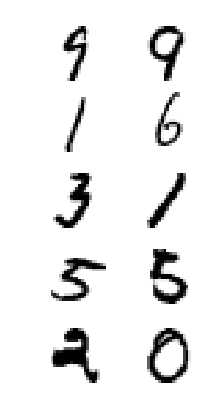

In [64]:
plt.figure(figsize=(3, 3 * batch_size))
plt.subplot(121)
plt.imshow(X_batch[:,0].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.subplot(122)
plt.imshow(X_batch[:,1].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.show()

In [65]:
y_batch

array([[1],
       [0],
       [0],
       [1],
       [0]])

In [66]:
X_test1, y_test1 = generate_batch(X_test, y_test, batch_size=len(X_test))

开始训练

In [67]:
n_epochs = 100
batch_size = 500

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(len(X_train1) // batch_size):
            X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)
            loss_val, _ = sess.run([loss, training_op], feed_dict={X: X_batch, y: y_batch})
        print(epoch, "Train loss:", loss_val)
        if epoch % 5 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_digit_comparison_model.ckpt")

0 Train loss: 0.6910327
0 Test accuracy: 0.542
1 Train loss: 0.6035354
2 Train loss: 0.54946035
3 Train loss: 0.47047248
4 Train loss: 0.4060757
5 Train loss: 0.38308156
5 Test accuracy: 0.824
6 Train loss: 0.3904727
7 Train loss: 0.3390794
8 Train loss: 0.32106707
9 Train loss: 0.31792688
10 Train loss: 0.2449429
10 Test accuracy: 0.8881
11 Train loss: 0.29292354
12 Train loss: 0.23225448
13 Train loss: 0.23180932
14 Train loss: 0.19877928
15 Train loss: 0.2006546
15 Test accuracy: 0.9203
16 Train loss: 0.19700494
17 Train loss: 0.18893136
18 Train loss: 0.1996545
19 Train loss: 0.24071646
20 Train loss: 0.18882026
20 Test accuracy: 0.9367
21 Train loss: 0.124191955
22 Train loss: 0.14013414
23 Train loss: 0.120789446
24 Train loss: 0.15721141
25 Train loss: 0.115078606
25 Test accuracy: 0.948
26 Train loss: 0.13891111
27 Train loss: 0.15260816
28 Train loss: 0.12343675
29 Train loss: 0.11543136
30 Train loss: 0.11402824
30 Test accuracy: 0.9507
31 Train loss: 0.11897089
32 Train loss

重用和冻结隐藏层，然后添加softmax

In [68]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
# 冻结
dnn_outputs = dnn(X, name="DNN_A")
frozen_outputs = tf.stop_gradient(dnn_outputs)

logits = tf.layers.dense(frozen_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

只在5000的样本上训练

In [69]:
n_epochs = 100
batch_size = 50

with tf.Session() as sess:
    init.run()
    # 读取模型参数
    restore_saver.restore(sess, "./my_digit_comparison_model.ckpt")

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_digit_comparison_model.ckpt
0 Test accuracy: 0.9724
10 Test accuracy: 0.9743
20 Test accuracy: 0.9738
30 Test accuracy: 0.9726
40 Test accuracy: 0.9734
50 Test accuracy: 0.9728
60 Test accuracy: 0.973
70 Test accuracy: 0.973
80 Test accuracy: 0.9726
90 Test accuracy: 0.9732


重新训练

In [70]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

In [71]:
n_epochs = 150
batch_size = 50

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

0 Test accuracy: 0.8694
10 Test accuracy: 0.9276
20 Test accuracy: 0.9366
30 Test accuracy: 0.9404
40 Test accuracy: 0.9466
50 Test accuracy: 0.9467
60 Test accuracy: 0.9465
70 Test accuracy: 0.9463
80 Test accuracy: 0.9462
90 Test accuracy: 0.9461
100 Test accuracy: 0.946
110 Test accuracy: 0.946
120 Test accuracy: 0.946
130 Test accuracy: 0.9461
140 Test accuracy: 0.9462
